# An√°lise Final La Msion Brasil

## Bibliotecas

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
import statsmodels.api as sm
import scikit_posthocs as sp

In [7]:
# Define que o pandas n√£o deve limitar o n√∫mero de colunas exibidas
pd.set_option("display.max_columns", None)

# B√îNUS: Voc√™ tamb√©m pode fazer o mesmo para as linhas
pd.set_option("display.max_rows", None)

# B√îNUS: E aumentar a largura da exibi√ß√£o para evitar quebras de linha
pd.set_option("display.width", 1000)

In [8]:
# --- Bloco de Estilo para TCC (Colocar no in√≠cio do seu c√≥digo) ---

# Define o tema do Seaborn
sns.set_theme(
    style="whitegrid",  # Estilo com fundo branco e grades cinzas claras e sutis.
    # Outras op√ß√µes √≥timas: 'white' (sem grades) ou 'ticks' (com marca√ß√µes nos eixos).
    context="paper",  # Contexto que otimiza os tamanhos de fonte e linhas para artigos/publica√ß√µes.
    palette="colorblind",  # Paleta de cores s√≥bria e acess√≠vel.
)

# Configura√ß√µes adicionais com Matplotlib (opcional, mas recomendado)
plt.rcParams["font.family"] = (
    "serif"  # Usa uma fonte com serifa, que √© mais cl√°ssica em textos acad√™micos.
)
plt.rcParams["figure.figsize"] = (
    10,
    5,
)  # Define um tamanho padr√£o para as figuras (largura, altura em polegadas).
plt.rcParams["axes.spines.top"] = False  # Remove a linha (espinha) de cima do gr√°fico.
plt.rcParams["axes.spines.right"] = (
    False  # Remove a linha (espinha) da direita do gr√°fico.
)

# --------------------------------------------------------------------

## Carregando os dados

In [9]:
df_completo = pd.read_csv("Dados/df_completo_final.csv", sep=",")
df_completo.head(10)

Nome Atleta    sexo faixa_etaria           peso   ano  km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo
0  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       1.0               285             2023               13.0               -9.0
1  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       2.0               298             2023               88.0                0.0
2  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       3.0               295             2023               58.0                0.0
3  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       4.0               363             2023               46.0              -81.0
4  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       5.0               357             2023               41.0              -58.0
5  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       6.0               670             2023              128.0              -11.0
6  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       7.0               258             2023              228.0               -7.0
7  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       8.0               211             2023                1.0             -243.0
8  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       9.0               338             2023                1.0             -122.0
9  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023      10.0               544             2023                9.0              -69.0

In [10]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Nome Atleta        3880 non-null   object 
 1   sexo               3880 non-null   object 
 2   faixa_etaria       3880 non-null   object 
 3   peso               3880 non-null   object 
 4   ano                3880 non-null   int64  
 5   km_prova           3880 non-null   float64
 6   tempo_por_km_seg   3880 non-null   int64  
 7   ano_mais_antigo    3880 non-null   int64  
 8   desnivel_positivo  3880 non-null   float64
 9   desnivel_negativo  3880 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 303.3+ KB


In [11]:
df_completo.describe()

ano     km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo
count  3880.000000  3880.000000       3880.000000      3880.000000        3880.000000        3880.000000
mean   2022.519588    18.302835        711.316237      2022.519588          78.211598         -78.093814
std       0.499681    10.281036        502.194156         0.499681          93.670162          85.562874
min    2022.000000     1.000000         23.000000      2022.000000           0.000000        -329.000000
25%    2022.000000     9.000000        401.000000      2022.000000           6.000000        -137.000000
50%    2023.000000    18.000000        558.000000      2023.000000          44.000000         -42.000000
75%    2023.000000    27.000000        834.000000      2023.000000         143.000000         -11.000000
max    2023.000000    36.000000       4463.000000      2023.000000         354.000000           0.000000

## An√°lise Explorat√≥ria dos dados

Vamos come√ßar analisando o desempenho geral dos atletas. Para isso devemos trasnformar nosso dataframe onde cada linha √© um km do atleta, para um novo onde cada linha dever uma √∫nica observa√ß√£o do atleta e as vari√°veis v√£o ser um resumo.

In [12]:
df_agregado_por_atleta = (
    df_completo.groupby("Nome Atleta")
    .agg(
        # Pega a informa√ß√£o demogr√°fica (que √© a mesma em todas as linhas do atleta)
        sexo=("sexo", "first"),
        faixa_etaria=("faixa_etaria", "first"),
        peso=("peso", "first"),
        ano_corrida=("ano", "first"),  # Pega o ano da corrida
        # Calcula as m√©tricas de desempenho e estrat√©gia
        Tempo_Final_seg=("tempo_por_km_seg", "sum"),
        Ritmo_Medio_seg=("tempo_por_km_seg", "mean"),
        Variabilidade_Ritmo_std=(
            "tempo_por_km_seg",
            "std",
        ),  # Desvio padr√£o do ritmo por km
        # Calcula as m√©tricas de esfor√ßo relacionadas ao percurso
        Total_Desnivel_Positivo=("desnivel_positivo", "sum"),
        Total_Desnivel_negativo=("desnivel_negativo", "sum"),
    )
    .reset_index()
)

# Para facilitar a interpreta√ß√£o, vamos converter segundos para minutos
df_agregado_por_atleta["Tempo_Final_min"] = (
    df_agregado_por_atleta["Tempo_Final_seg"] / 60
)
df_agregado_por_atleta["Ritmo_Medio_min"] = (
    df_agregado_por_atleta["Ritmo_Medio_seg"] / 60
)
df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] = (
    df_agregado_por_atleta["Variabilidade_Ritmo_std"] / 60
)

# Vamos ver como ficou
df_agregado_por_atleta.head()

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993
3          Alex Junior Aj  Homens      20 a 24  65 a 74 kg         2022            18496       513.777778               261.647539                   2787.0                  -2790.0       308.266667         8.562963                     4.360792
4      Alexandre Santiago  Homens      35 a 44  55 a 64 kg         2022            14626       417.885714               195.390826                   2779.0                  -2781.0       243.766667         6.964762                     3.256514

In [13]:
df_agregado_por_atleta.describe()

ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std
count   109.000000       109.000000       109.000000               109.000000               109.000000               109.000000       109.000000       109.000000                   109.000000
mean   2022.522936     25320.247706       712.080833               421.113491              2784.045872             -2779.853211       422.004128        11.868014                     7.018558
std       0.501781      7378.201520       210.163355               195.872922                 3.996261                33.268221       122.970025         3.502723                     3.264549
min    2022.000000     14184.000000       394.000000               174.153463              2777.000000             -2790.000000       236.400000         6.566667                     2.902558
25%    2022.000000     19740.000000       559.285714               277.364479              2779.000000             -2790.000000       329.000000         9.321429                     4.622741
50%    2023.000000     23389.000000       649.694444               338.790751              2787.000000             -2790.000000       389.816667        10.828241                     5.646513
75%    2023.000000     31520.000000       886.055556               575.846688              2787.000000             -2781.000000       525.333333        14.767593                     9.597445
max    2023.000000     47456.000000      1355.885714               990.812630              2787.000000             -2630.000000       790.933333        22.598095                    16.513544

### An√°lises gr√°ficas

#### Dstribui√ß√£o do tempo final

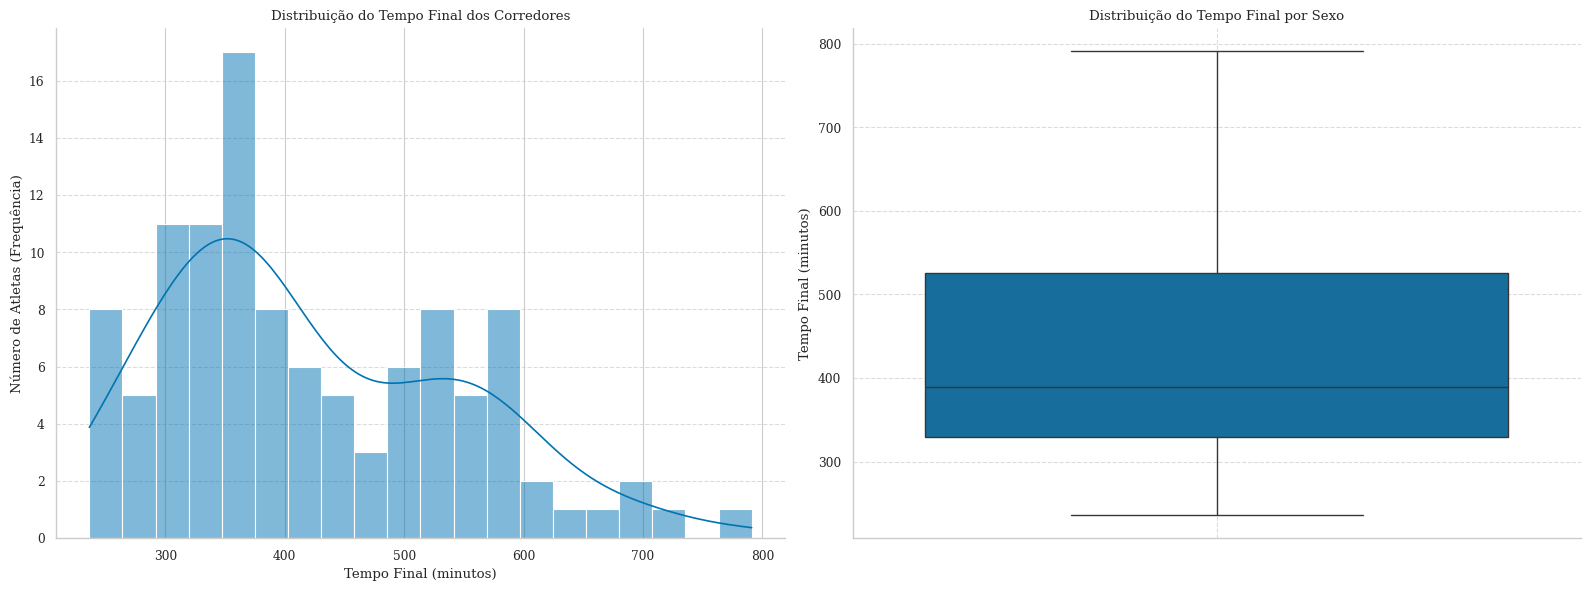

count    109.000000
mean     422.004128
std      122.970025
min      236.400000
25%      329.000000
50%      389.816667
75%      525.333333
max      790.933333
Name: Tempo_Final_min, dtype: float64

 count     1.816667
mean      7.033402
std       2.049500
min       3.940000
25%       5.483333
50%       6.496944
75%       8.755556
max      13.182222
Name: Tempo_Final_min, dtype: float64


In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(
    data=df_agregado_por_atleta,
    x="Tempo_Final_min",
    kde=True,
    bins=20,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Tempo Final dos Corredores")
axes[0].set_xlabel("Tempo Final (minutos)")  # Adicionando r√≥tulo ao eixo x
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.boxplot(
    data=df_agregado_por_atleta,
    y="Tempo_Final_min",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Distribui√ß√£o do Tempo Final por Sexo")
axes[1].set_ylabel("Tempo Final (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

# Tamb√©m √© √∫til ver as estat√≠sticas descritivas
print(df_agregado_por_atleta["Tempo_Final_min"].describe())

print("\n", df_agregado_por_atleta["Tempo_Final_min"].describe() / 60)

#### An√°lise do Sexo

In [15]:
df_agregado_por_atleta["sexo"].value_counts()

sexo
Homens      78
Mulheres    31
Name: count, dtype: int64

- Aqui podemos observar a que a quantidade de participantes homens √© maior que a participa√ß√£o de mulheres.

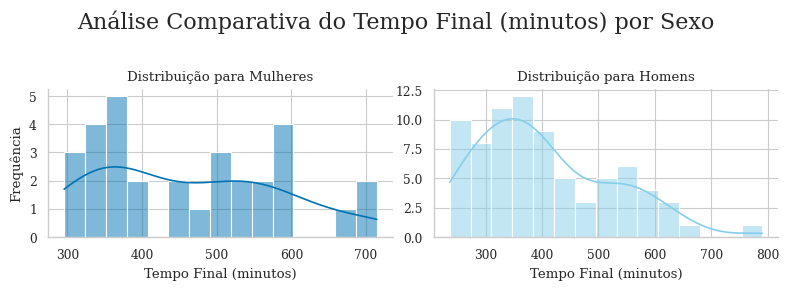

--- Estat√≠sticas Descritivas Comparativas ---
       Mulheres  Homens
count     31.00   78.00
mean     463.71  405.43
std      123.35  119.60
min      295.48  236.40
25%      358.56  314.38
50%      444.42  374.14
75%      557.38  497.77
max      714.43  790.93


In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# T√≠tulo principal para a figura inteira
fig.suptitle("An√°lise Comparativa do Tempo Final (minutos) por Sexo", fontsize=16)


# 2. Plote o histograma das Mulheres no primeiro eixo (axes[0])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    ax=axes[0],
)  # A chave √© especificar o eixo aqui!
axes[0].set_title("Distribui√ß√£o para Mulheres")
axes[0].set_xlabel("Tempo Final (minutos)")
axes[0].set_ylabel("Frequ√™ncia")


# 3. Plote o histograma dos Homens no segundo eixo (axes[1])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    color="skyblue",  # Mudar a cor ajuda na diferencia√ß√£o
    ax=axes[1],
)  # E aqui tamb√©m!
axes[1].set_title("Distribui√ß√£o para Homens")
axes[1].set_xlabel("Tempo Final (minutos)")
axes[1].set_ylabel("")  # Pode remover o label do eixo Y para um visual mais limpo


# 4. Exiba os gr√°ficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para evitar sobreposi√ß√£o
plt.show()


# ======================================================================
# PARTE 2: ESTAT√çSTICAS (.DESCRIBE()) LADO A LADO
# ======================================================================

# 1. Calcule o describe() para cada grupo separadamente
desc_mulheres = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"][
    "Tempo_Final_min"
].describe()
desc_homens = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"][
    "Tempo_Final_min"
].describe()


# 2. Use pd.concat para unir as duas sa√≠das como colunas de um novo DataFrame
# axis=1 indica que a concatena√ß√£o deve ser feita pelas colunas (lado a lado).
# keys=[] define os nomes das novas colunas.
estatisticas_comparativas = pd.concat(
    [desc_mulheres, desc_homens], axis=1, keys=["Mulheres", "Homens"]
)


# 3. Imprima a tabela comparativa final
print("--- Estat√≠sticas Descritivas Comparativas ---")
print(
    estatisticas_comparativas.round(2)
)  # .round(2) para formatar com 2 casas decimais


In [17]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("sexo")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
            "Variabilidade_Ritmo_min_std": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Sexo ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Sexo ---
                                      count    mean     std     min  median     max
sexo                                                                               
Homens   Ritmo_Medio_min                 78   11.37    3.37    6.57   10.39   22.60
         Tempo_Final_min                 78  405.43  119.60  236.40  374.14  790.93
         Variabilidade_Ritmo_min_std     78    6.63    3.08    2.90    5.13   16.40
Mulheres Ritmo_Medio_min                 31   13.11    3.56    8.21   12.49   20.41
         Tempo_Final_min                 31  463.71  123.35  295.48  444.42  714.43
         Variabilidade_Ritmo_min_std     31    7.99    3.56    3.90    7.16   16.51


C:\Users\Home\AppData\Local\Temp\ipykernel_3328\3671722932.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


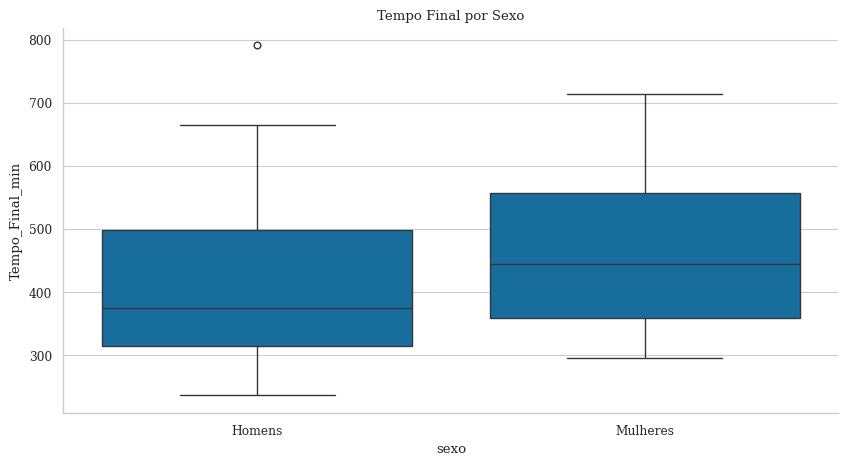

In [18]:
# Sexo vs. Tempo Final
sns.boxplot(data=df_agregado_por_atleta, x="sexo", y="Tempo_Final_min")
plt.title("Tempo Final por Sexo")
plt.show()


1. Tempo Final da Prova (Tempo_Final_min)

Desempenho M√©dio: Os homens terminaram a prova, em m√©dia, cerca de 1 hora mais r√°pido que as mulheres (mean de 406 min para homens vs. 465 min para mulheres). A mediana (o valor do meio) confirma essa tend√™ncia, mostrando que o corredor "mediano" masculino tamb√©m foi consideravelmente mais r√°pido.

Dispers√£o: A dispers√£o dos tempos √© alta e relativamente parecida para ambos os grupos (std de 119 min para homens e 124 min para mulheres). Isso indica que, em ambos os sexos, havia uma grande variedade de n√≠veis de habilidade, desde os corredores mais r√°pidos at√© os que levaram mais tempo. Podendo existir n√≠veis entre os corredores, indo de corredores mais experientes e profissionais ate corredores amadores e menos experientes.

2. Ritmo M√©dio (Ritmo_Medio_min)

Velocidade M√©dia: Confirmando o dado anterior, o ritmo m√©dio dos homens foi mais baixo (mais r√°pido), com uma m√©dia de 11.36 min/km contra 13.07 min/km das mulheres.

Melhores e Piores Ritmos: O homem mais r√°pido teve um ritmo m√©dio de 6.57 min/km, enquanto a mulher mais r√°pida teve um ritmo m√©dio de 8.21 min/km. Ambos os grupos tiveram atletas com ritmos m√©dios bem mais lentos (22.60 e 20.41 min/km), o que √© comum em corridas de montanha devido √† dificuldade do percurso.

3. Variabilidade do Ritmo (Variabilidade_Ritmo_min_std)

Consist√™ncia da Prova: Esta √© talvez a m√©trica mais interessante. Em m√©dia, os homens tiveram uma menor variabilidade de ritmo dentro da sua prova (mean de 6.63) em compara√ß√£o com as mulheres (mean de 7.98).

#####  T'este de Hip√≥tese: Tempo de Prova entre Homens e Mulheres
> Pergunta: "A diferen√ßa no tempo m√©dio de prova (Tempo_Final_min) entre homens e mulheres √© estatisticamente significativa?"

- Teste Proposto: Teste T de Student para amostras independentes. Correto, este √© o teste ideal para comparar as m√©dias de dois grupos independentes.

Passos Detalhados:
- Hip√≥teses:
> H0: : A m√©dia do tempo final de prova para homens √© igual √† m√©dia do tempo final de prova para mulheres (Œº*homens* = Œº*mulheres*)

> H1 : A m√©dia do tempo final de prova 'para homens √© diferente da m√©dia do tempo final de prova para mulheres (Œº*homens* != Œº*mulheres*)

- N√≠vel de Signific√¢ncia: Œ±=0.05.

###### Verificando Normalidade
Um dos pressupostos e fator que nos ajuda a saber qual teste utilizar √© se as distribui√ß√µes seguem normalidade. Vamos usar o teste Shapiro-wilk para verificar essa nromalidade.

In [19]:
# Defina o n√≠vel de signific√¢ncia (alfa)
alfa = 0.05

tempo_homens = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"][
    "Tempo_Final_min"
]
tempo_mulheres = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"][
    "Tempo_Final_min"
]

print(f"\nTamanho da amostra - Homens: {len(tempo_homens)}")
print(f"Tamanho da amostra - Mulheres: {len(tempo_mulheres)}")

print("\n--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---")
stat_shapiro_h, p_shapiro_h = stats.shapiro(tempo_homens)
stat_shapiro_m, p_shapiro_m = stats.shapiro(tempo_mulheres)

print(f"P-valor para o grupo Homens: {p_shapiro_h:.4f}")
print(f"P-valor para o grupo Mulheres: {p_shapiro_m:.4f}")

# Avalia√ß√£o da normalidade
is_normal_h = p_shapiro_h > alfa
is_normal_m = p_shapiro_m > alfa

if is_normal_h and is_normal_m:
    print("Conclus√£o: Ambos os grupos parecem seguir uma distribui√ß√£o normal.")
else:
    print(
        "Conclus√£o: Pelo menos um dos grupos n√£o segue uma distribui√ß√£o normal. Um teste n√£o-param√©trico √© recomendado."
    )


Tamanho da amostra - Homens: 78
Tamanho da amostra - Mulheres: 31

--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---
P-valor para o grupo Homens: 0.0008
P-valor para o grupo Mulheres: 0.0360
Conclus√£o: Pelo menos um dos grupos n√£o segue uma distribui√ß√£o normal. Um teste n√£o-param√©trico √© recomendado.


Como pelo menos um, no nosso caso ambos, n√£o seguem normalidade devemos adotar um teste n√£o-param√©trico para comparar as duas distribui√ß√µes.

###### Teste N√£o-Param√©trico : Mann-Whitney

Verificando a Homogeneidade das Vari√¢nicias.

In [20]:
print(
    "\n--- Verificando Pressuposto de Homogeneidade das Vari√¢ncias (Teste de Levene) ---"
)
stat_levene, p_levene = stats.levene(tempo_homens, tempo_mulheres)

print(f"P-valor do Teste de Levene: {p_levene:.4f}")

# Avalia√ß√£o da homogeneidade
are_variances_equal = p_levene > alfa

if are_variances_equal:
    print("Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas homog√™neas (iguais).")
else:
    print(
        "Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas heterog√™neas (diferentes)."
    )


--- Verificando Pressuposto de Homogeneidade das Vari√¢ncias (Teste de Levene) ---
P-valor do Teste de Levene: 0.4402
Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas homog√™neas (iguais).


Teste Mann-Whitney U

In [21]:
stat_final, p_final = stats.mannwhitneyu(
    tempo_homens, tempo_mulheres, alternative="two-sided"
)
nome_teste = "Mann-Whitney U"


print("\n--- Resultados Finais ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estat√≠stica do teste: {stat_final:.4f}")
print(f"P-valor final: {p_final:.4f}")

if p_final < alfa:
    print(f"\nConclus√£o (com alfa={alfa}): Rejeitamos a hip√≥tese nula.")
    print(
        "Existe uma diferen√ßa estatisticamente significativa no tempo final de prova entre homens e mulheres."
    )
else:
    print(f"\nConclus√£o (com alfa={alfa}): N√£o rejeitamos a hip√≥tese nula.")
    print(
        "N√£o h√° evid√™ncias estat√≠sticas suficientes para afirmar que existe uma diferen√ßa no tempo final de prova entre homens e mulheres."
    )


--- Resultados Finais ---
Teste Realizado: Mann-Whitney U
Estat√≠stica do teste: 889.0000
P-valor final: 0.0319

Conclus√£o (com alfa=0.05): Rejeitamos a hip√≥tese nula.
Existe uma diferen√ßa estatisticamente significativa no tempo final de prova entre homens e mulheres.


**Interpreta√ß√£o do Teste de Hip√≥teses: Tempo de Prova vs. Sexo**

* **Objetivo:** Verificar se existe uma diferen√ßa estatisticamente significativa no tempo final de prova (`Tempo_Final_min`) entre corredores do sexo masculino e feminino.

* **Metodologia e Verifica√ß√£o de Pressupostos:**
    1.  **Normalidade:** O Teste de Shapiro-Wilk foi aplicado a ambos os grupos. O resultado indicou que os dados de tempo para homens (p < 0.05) e para mulheres (p < 0.05) **n√£o seguem uma distribui√ß√£o normal**.
    2.  **Escolha do Teste:** Devido √† quebra do pressuposto de normalidade, o teste n√£o-param√©trico **Mann-Whitney U** foi selecionado em vez do Teste T de Student.
    3.  **Homogeneidade de Vari√¢ncias:** O Teste de Levene foi realizado e seu resultado (p > 0.05) indicou que **as vari√¢ncias s√£o homog√™neas** entre os grupos. Esta verifica√ß√£o √© importante pois nos permite interpretar o resultado do Mann-Whitney U como uma compara√ß√£o de **medianas**.

* **Resultado do Teste:**
    * O Teste de Mann-Whitney U resultou em um **p-valor de 0.0319**.

* **Conclus√£o:**
    * Como o p-valor (0.0319) √© menor que o nosso n√≠vel de signific√¢ncia (Œ± = 0.05), **rejeitamos a hip√≥tese nula**.
    * **Interpreta√ß√£o Pr√°tica:** Existem evid√™ncias estat√≠sticas para afirmar que h√° uma diferen√ßa significativa no desempenho entre homens e mulheres nesta prova. Especificamente, as **medianas** do tempo de prova s√£o diferentes entre os dois grupos. (Os dados descritivos iniciais sugerem que os homens, em geral, tiveram um tempo de prova menor).

#### An√°lise por Faixa et√°ria

In [22]:
df_agregado_por_atleta["faixa_etaria"].value_counts()

faixa_etaria
35 a 44    45
25 a 34    34
45 a 54    20
20 a 24     6
55 a 64     4
Name: count, dtype: int64

In [23]:
df_agregado_por_atleta["faixa_etaria"].value_counts() / len(df_agregado_por_atleta)

faixa_etaria
35 a 44    0.412844
25 a 34    0.311927
45 a 54    0.183486
20 a 24    0.055046
55 a 64    0.036697
Name: count, dtype: float64

- Aqui podemos notar uma grande concetra√ß√£o em corredores de 35 a 44 anos, seguindo de corredores mais jovens de 25 a 34 anos. Temos um acumo de 90% dos participantes indo de 25 a 55 anos.

In [24]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("faixa_etaria")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Faixa Etaria---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Faixa Etaria---
                              count    mean     std     min  median     max
faixa_etaria                                                               
20 a 24      Ritmo_Medio_min      6    8.47    1.29    6.57    8.68   10.39
             Tempo_Final_min      6  301.96   45.69  236.40  308.18  373.98
25 a 34      Ritmo_Medio_min     34   11.40    3.58    6.92   10.75   20.09
             Tempo_Final_min     34  405.87  124.37  249.02  381.65  698.52
35 a 44      Ritmo_Medio_min     45   12.15    3.72    6.96   11.17   22.60
             Tempo_Final_min     45  432.96  131.54  243.77  390.90  790.93
45 a 54      Ritmo_Medio_min     20   12.47    2.59    8.50   12.07   16.88
             Tempo_Final_min     20  441.71   93.07  306.05  416.48  590.77
55 a 64      Ritmo_Medio_min      4   14.71    3.49   10.15   15.26   18.18
             Tempo_Final_min      4  517.36  117.68  365.28  533.94  636.28


C:\Users\Home\AppData\Local\Temp\ipykernel_3328\2259748986.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


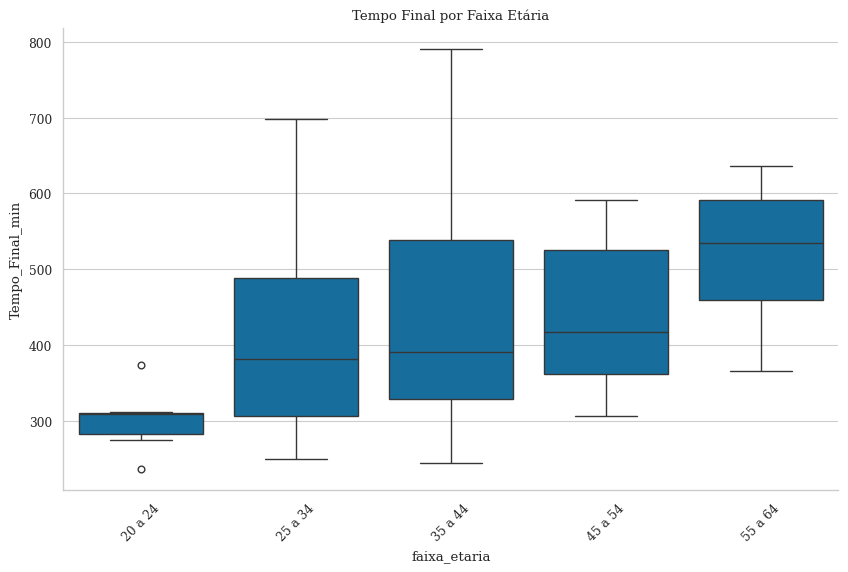

In [25]:
# Faixa Et√°ria vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Tempo_Final_min",
    order=faixa_etaria_order,
)
plt.title("Tempo Final por Faixa Et√°ria")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para n√£o sobrepor
plt.show()

- Tend√™ncia Geral: O gr√°fico evidencia uma tend√™ncia geral de aumento do tempo mediano de conclus√£o da prova com o avan√ßo da idade. Contudo, essa rela√ß√£o n√£o se mostra perfeitamente linear.

- Melhor Desempenho: A faixa et√°ria de 20 a 24 anos se destaca com o menor tempo mediano e a menor dispers√£o (caixa mais compacta). Isso sugere que este grupo n√£o s√≥ foi o mais r√°pido, em m√©dia, mas tamb√©m o mais homog√™neo em termos de performance.

- Maior Variabilidade: O grupo de 35 a 44 anos apresenta a maior amplitude interquartil (a "altura" da caixa), indicando a maior variabilidade nos tempos de conclus√£o. Isso pode sugerir que esta faixa cont√©m uma mistura mais heterog√™nea de atletas, desde os muito experientes at√© os iniciantes.

- Ponto de Inflex√£o: Nota-se um ponto , que a cada mudan√ßa de faixa etaria, tem uma certa tendencia em aumentar a mediana no tempo total da prova.

- Outlier: √â importante destacar a presen√ßa de um outlier no grupo de 20 a 24 anos, indicando um atleta com um tempo de prova atipicamente superior ao de seus pares na mesma faixa et√°ria.

Comparando pelo tempo m√©dio por km

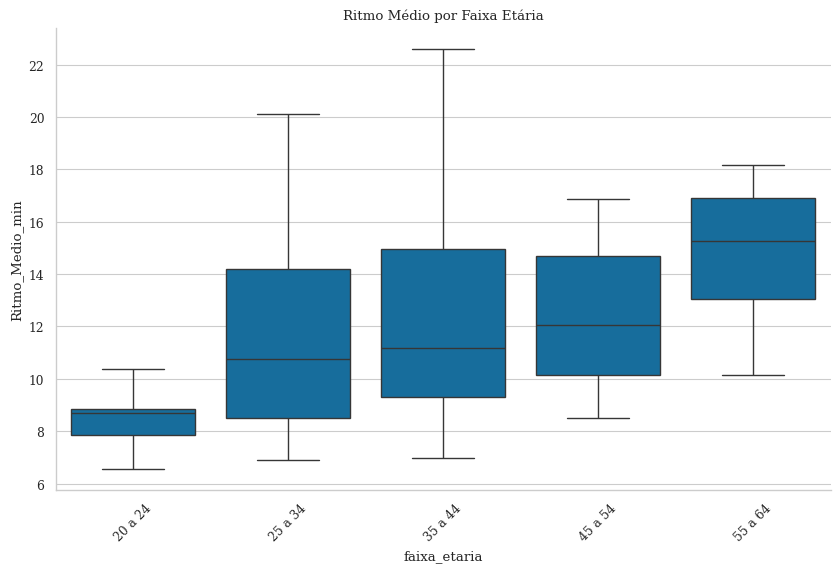

In [26]:
# Faixa Et√°ria vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Ritmo_Medio_min",
    order=faixa_etaria_order,
)
plt.title("Ritmo M√©dio por Faixa Et√°ria")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para n√£o sobrepor
plt.show()

##### Teste de Hip√≥tese: Tempo de Prova entre Faixas Et√°rias

> Pergunta: "Existe uma diferen√ßa estatisticamente significativa no tempo m√©dio de prova (Tempo_Final_min) entre as diferentes faixas et√°rias?"

- **Teste Proposto:** An√°lise de Vari√¢ncia (ANOVA) ou seu equivalente n√£o param√©trico.
O teste inicial planejado √© a **ANOVA de um fator**, ideal para comparar as m√©dias de tr√™s ou mais grupos independentes. Contudo, sua validade depende de certos pressupostos (principalmente normalidade dos dados e homogeneidade das vari√¢ncias). Caso esses pressupostos n√£o sejam satisfeitos, utilizaremos o teste n√£o param√©trico equivalente, o **Teste de Kruskal-Wallis**, que compara as distribui√ß√µes dos grupos.

**Passos Detalhados:**

- **Hip√≥teses:**
> **H‚ÇÄ:** As m√©dias do tempo final de prova s√£o iguais para todas as faixas et√°rias (Œº_faixa1 = Œº_faixa2 = ... = Œº_faixaK).

> **H‚ÇÅ:** Pelo menos uma das m√©dias do tempo final de prova √© diferente das demais.

- **N√≠vel de Signific√¢ncia:** Œ± = 0.05.

Nesta etapa, o objetivo √© determinar se existe uma diferen√ßa estatisticamente significativa no tempo final de prova entre as diferentes faixas et√°rias dos competidores.




Teste Normalidade

In [27]:
alfa = 0.05

faixas_etarias_unicas = df_agregado_por_atleta["faixa_etaria"].unique()
grupos_por_idade = [
    df_agregado_por_atleta["Tempo_Final_min"][
        df_agregado_por_atleta["faixa_etaria"] == faixa
    ]
    for faixa in faixas_etarias_unicas
]


print("\nTamanho das amostras por grupo:")
for i, faixa in enumerate(faixas_etarias_unicas):
    print(f"- {faixa}: {len(grupos_por_idade[i])} atletas")


# --- PASSO 2: TESTAR O PRESSUPOSTO DE NORMALIDADE ---
print("\n--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---")
print("Aten√ß√£o: Teste pouco confi√°vel para grupos com n pequeno.")
todos_normais = True
for i, faixa in enumerate(faixas_etarias_unicas):
    stat, p_valor = stats.shapiro(grupos_por_idade[i])
    print(f"P-valor para o grupo '{faixa}': {p_valor:.4f}")
    if p_valor < alfa:
        todos_normais = False

if todos_normais:
    print("Conclus√£o: Nenhum grupo rejeitou a hip√≥tese de normalidade.")
else:
    print(
        "Conclus√£o: Pelo menos um grupo n√£o segue uma distribui√ß√£o normal. Um teste n√£o-param√©trico √© recomendado."
    )


Tamanho das amostras por grupo:
- 45 a 54: 20 atletas
- 25 a 34: 34 atletas
- 20 a 24: 6 atletas
- 35 a 44: 45 atletas
- 55 a 64: 4 atletas

--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---
Aten√ß√£o: Teste pouco confi√°vel para grupos com n pequeno.
P-valor para o grupo '45 a 54': 0.0828
P-valor para o grupo '25 a 34': 0.0271
P-valor para o grupo '20 a 24': 0.6433
P-valor para o grupo '35 a 44': 0.0121
P-valor para o grupo '55 a 64': 0.8331
Conclus√£o: Pelo menos um grupo n√£o segue uma distribui√ß√£o normal. Um teste n√£o-param√©trico √© recomendado.


Como o pressuposto de normalidade n√£o foi atendido em todos os grupos (verificado pelo teste de Shapiro-Wilk), o teste n√£o param√©trico de **Kruskal-Wallis** √© a escolha apropriada em vez da ANOVA.

- **Ponto de Aten√ß√£o Metodol√≥gico:**
Foi observado que o tamanho da amostra em alguns grupos √© pequeno (especificamente, n=6 e n=4). O teste de Kruskal-Wallis, em sua forma padr√£o, utiliza uma aproxima√ß√£o da distribui√ß√£o qui-quadrado para calcular o p-valor, um m√©todo que perde precis√£o com amostras pequenas. Portanto, embora o teste padr√£o seja executado inicialmente, ser√° necess√°ria uma valida√ß√£o posterior com uma t√©cnica mais robusta para garantir a confiabilidade da conclus√£o.

In [28]:
# --- PASSO 3: TESTAR O PRESSUPOSTO DE HOMOGENEIDADE DAS VARI√ÇNCIAS ---
print(
    "\n--- Verificando Pressuposto de Homogeneidade das Vari√¢ncias (Teste de Levene) ---"
)
stat_levene, p_levene = stats.levene(*grupos_por_idade)
print(f"P-valor do Teste de Levene: {p_levene:.4f}")

if p_levene > alfa:
    print("Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas homog√™neas.")
else:
    print("Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas heterog√™neas.")


# --- PASSO 4: ESCOLHER E EXECUTAR O TESTE APROPRIADO ---
print("\n--- Executando o Teste de Hip√≥teses Principal ---")

print("Escolha: Teste de Kruskal-Wallis (n√£o-param√©trico).")
stat_final, p_final = stats.kruskal(*grupos_por_idade)
nome_teste = "Kruskal-Wallis"

print("\n--- Resultados do Teste Principal ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estat√≠stica do teste: {stat_final:.4f}")
print(f"P-valor final: {p_final:.4f}")


--- Verificando Pressuposto de Homogeneidade das Vari√¢ncias (Teste de Levene) ---
P-valor do Teste de Levene: 0.2048
Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas homog√™neas.

--- Executando o Teste de Hip√≥teses Principal ---
Escolha: Teste de Kruskal-Wallis (n√£o-param√©trico).

--- Resultados do Teste Principal ---
Teste Realizado: Kruskal-Wallis
Estat√≠stica do teste: 11.5814
P-valor final: 0.0208


O resultado do teste de Kruskal-Wallis padr√£o indicou um p-valor de **0.0208**, o que sugere uma diferen√ßa estatisticamente significativa entre os grupos.

**No entanto**, conforme mencionado anteriormente, este p-valor √© baseado em uma aproxima√ß√£o que pode ser imprecisa devido √† presen√ßa de grupos com poucas amostras (n < 5). Para garantir a robustez de nossa conclus√£o e confirmar se este resultado se mant√©m, realizaremos a seguir um **Teste de Permuta√ß√£o**.

Este m√©todo n√£o depende de aproxima√ß√µes te√≥ricas e ir√° calcular um p-valor emp√≠rico, baseado na distribui√ß√£o dos pr√≥prios dados, fornecendo um resultado mais confi√°vel para o nosso cen√°rio.

**Refer√™ncias e Justificativa Metodol√≥gica**

A decis√£o de utilizar um **Teste de Permuta√ß√£o** para validar o resultado do Kruskal-Wallis, em vez de confiar apenas na aproxima√ß√£o qui-quadrado, √© fundamentada nas recomenda√ß√µes da literatura estat√≠stica para casos com amostras pequenas. As seguintes refer√™ncias apoiam essa abordagem cuidadosa:

* **Siegel, S., & Castellan, N. J., Jr. (2006). *Estat√≠stica n√£o param√©trica para ci√™ncias do comportamento* (2¬™ ed.). Artmed.**
    > Esta obra cl√°ssica √© uma refer√™ncia fundamental na √°rea e discute as condi√ß√µes de aplica√ß√£o dos testes n√£o param√©tricos, destacando a necessidade de cautela e o uso de m√©todos exatos ou de permuta√ß√£o para amostras pequenas, garantindo a validade do p-valor.

* **University of Virginia Library - Getting Started with the Kruskal-Wallis Test**
    > [Link para o artigo](https://library.virginia.edu/data/articles/getting-started-with-the-kruskal-wallis-test)
    >
    > Este guia de uma biblioteca universit√°ria refor√ßa a premissa de que a aproxima√ß√£o qui-quadrado √© mais confi√°vel quando cada grupo possui um tamanho de amostra adequado (geralmente n ‚â• 5), justificando a busca por alternativas mais precisas em cen√°rios com amostras menores.

* **QuestionPro Blog - Teste Kruskal-Wallis: O que √© e quando us√°-lo?**
    > [Link para o post](https://www.questionpro.com/blog/pt-br/teste-kruskal-wallis/)
    >
    > Um guia pr√°tico que resume as condi√ß√µes de uso do teste e serve como material de consulta r√°pida para a aplica√ß√£o do Kruskal-Wallis, mencionando as bases para sua utiliza√ß√£o correta.

In [29]:
# EXECUTAR O TESTE DE PERMUTA√á√ÉO PARA KRUSKAL-WALLIS ---
print("\n--- Executando o Teste de Hip√≥teses Principal ---")
print(
    "Escolha: Teste de Permuta√ß√£o para Kruskal-Wallis (abordagem robusta para amostras pequenas)."
)


# 1. Definimos a estat√≠stica que queremos calcular em cada permuta√ß√£o.
#    Neste caso, √© a estat√≠stica H do teste de Kruskal-Wallis.
def kruskal_statistic(*args):
    """Calcula a estat√≠stica H de Kruskal-Wallis."""
    stat, _ = stats.kruskal(*args)
    return stat


# 2. Executamos o teste de permuta√ß√£o.
#    - 'grupos_por_idade': seus dados, em uma lista de arrays/s√©ries.
#    - 'kruskal_statistic': a fun√ß√£o que calcula a estat√≠stica de interesse.
#    - 'n_resamples': o n√∫mero de permuta√ß√µes. 9999 √© um valor excelente.
#    - 'random_state': garante que o resultado seja o mesmo se voc√™ rodar o c√≥digo de novo.
res = stats.permutation_test(
    grupos_por_idade,
    kruskal_statistic,
    n_resamples=9999,
    random_state=np.random.default_rng(seed=42),
)

# Extra√≠mos a estat√≠stica original e o p-valor da permuta√ß√£o
stat_final = res.statistic
p_final = res.pvalue
nome_teste = "Kruskal-Wallis (via Teste de Permuta√ß√£o)"

print("\n--- Resultados do Teste Principal ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estat√≠stica H original: {stat_final:.4f}")
print(f"P-valor (calculado por permuta√ß√£o): {p_final:.4f}")


--- Executando o Teste de Hip√≥teses Principal ---
Escolha: Teste de Permuta√ß√£o para Kruskal-Wallis (abordagem robusta para amostras pequenas).

--- Resultados do Teste Principal ---
Teste Realizado: Kruskal-Wallis (via Teste de Permuta√ß√£o)
Estat√≠stica H original: 11.5814
P-valor (calculado por permuta√ß√£o): 0.0360


In [30]:
# --- PASSO 5: AN√ÅLISE POST-HOC (SE O RESULTADO FOR SIGNIFICATIVO) ---
print("\n--- An√°lise Post-Hoc ---")
if p_final < alfa:
    print(
        f"O p-valor ({p_final:.4f}) √© significativo. Realizando teste Post-Hoc para identificar quais grupos s√£o diferentes."
    )

    # O Teste de Dunn √© o post-hoc apropriado para Kruskal-Wallis.
    # Usamos 'bonferroni' para um ajuste conservador e seguro das m√∫ltiplas compara√ß√µes.
    dunn_results = sp.posthoc_dunn(
        df_agregado_por_atleta,
        val_col="Tempo_Final_min",
        group_col="faixa_etaria",
        p_adjust="bonferroni",
    )

    print(
        "\nMatriz de p-valores do Teste Post-Hoc de Dunn (com corre√ß√£o de Bonferroni):"
    )
    print(
        "C√©lulas com p < 0.05 indicam uma diferen√ßa significativa entre o par de grupos."
    )
    print(dunn_results)

else:
    print(
        f"O p-valor ({p_final:.4f}) n√£o √© significativo. N√£o h√° necessidade de um teste post-hoc."
    )
    print(
        "N√£o h√° evid√™ncias de uma diferen√ßa estatisticamente significativa no tempo de prova entre as diferentes faixas et√°rias."
    )



--- An√°lise Post-Hoc ---
O p-valor (0.0360) √© significativo. Realizando teste Post-Hoc para identificar quais grupos s√£o diferentes.

Matriz de p-valores do Teste Post-Hoc de Dunn (com corre√ß√£o de Bonferroni):
C√©lulas com p < 0.05 indicam uma diferen√ßa significativa entre o par de grupos.
          20 a 24   25 a 34   35 a 44   45 a 54   55 a 64
20 a 24  1.000000  0.313633  0.080202  0.042338  0.036381
25 a 34  0.313633  1.000000  1.000000  1.000000  0.804720
35 a 44  0.080202  1.000000  1.000000  1.000000  1.000000
45 a 54  0.042338  1.000000  1.000000  1.000000  1.000000
55 a 64  0.036381  0.804720  1.000000  1.000000  1.000000


**Conclus√£o Final da An√°lise**

A an√°lise foi conduzida para investigar se o tempo de conclus√£o da prova varia entre as diferentes faixas et√°rias. A seguir, os principais pontos observados e a conclus√£o final:

1.  **Escolha Metodol√≥gica:** Devido √† n√£o normalidade dos dados, o teste de Kruskal-Wallis foi selecionado. A presen√ßa de grupos com amostras pequenas (n=4 e n=6) exigiu uma valida√ß√£o do p-valor padr√£o.

2.  **Resultado Robusto:** O **Teste de Permuta√ß√£o** foi aplicado para obter um p-valor mais preciso, resultando em **p = 0.0360**. Este valor, sendo inferior a 0.05, confirma de forma robusta a exist√™ncia de uma diferen√ßa estatisticamente significativa entre os tempos m√©dios de prova das diferentes faixas et√°rias.

3.  **Identifica√ß√£o das Diferen√ßas (Post-Hoc):** A an√°lise post-hoc com o Teste de Dunn (com corre√ß√£o de Bonferroni) foi utilizada para identificar quais pares de grupos espec√≠ficos apresentavam diferen√ßas. As compara√ß√µes significativas foram:
    * O grupo **`20 a 24`** foi significativamente mais r√°pido que o grupo **`45 a 54`** (p=0.042).
    * O grupo **`20 a 24`** foi tamb√©m significativamente mais r√°pido que o grupo **`55 a 64`** (p=0.036).

**Conclus√£o:**
A an√°lise estat√≠stica demonstrou que a idade tem uma influ√™ncia significativa no tempo de finaliza√ß√£o da prova. Especificamente, os atletas mais jovens (`20 a 24 anos`) apresentam tempos de prova que s√£o estatisticamente distintos dos atletas em faixas et√°rias mais avan√ßadas (`45 a 54 anos` e `55 a 64 anos`). As diferen√ßas de desempenho entre as faixas et√°rias intermedi√°rias (`25-34`, `35-44`, `45-54`) n√£o foram estatisticamente significativas entre si.

#### An√°lise por faixa de peso

In [31]:
df_agregado_por_atleta["peso"].value_counts()

peso
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
N√£o informado      8
85 a 94 kg         7
95 kg a 104 kg     2
Name: count, dtype: int64

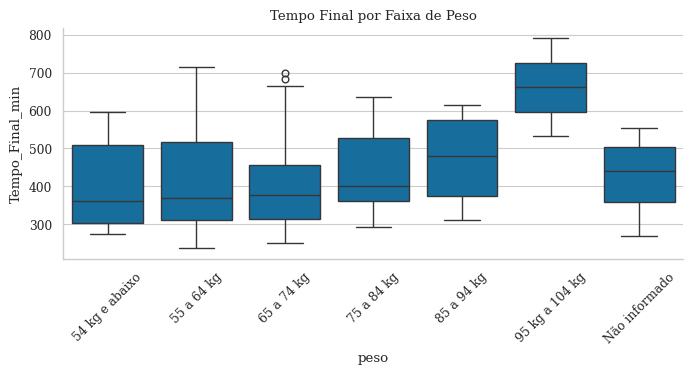

In [32]:
# Peso vs. Tempo Final
plt.figure(figsize=(8, 3))
# Remove None values before sorting to avoid TypeError
peso_order = sorted(
    [x for x in df_agregado_por_atleta["peso"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta, x="peso", y="Tempo_Final_min", order=peso_order
)
plt.title("Tempo Final por Faixa de Peso")
plt.xticks(rotation=45)
plt.show()

- Tend√™ncia Principal: Fica clara a correla√ß√£o entre o aumento da faixa de peso e o aumento no tempo mediano de prova. Atletas mais leves tenderam a ser mais r√°pidos.

- Desempenho nos Extremos: O grupo de 54 kg e abaixo obteve os melhores tempos, enquanto a faixa de 95 a 104 kg registrou o desempenho m√©dio mais lento.

- Variabilidade: As faixas de peso intermedi√°rias (55 a 74 kg) mostram a maior dispers√£o nos resultado, indicando uma grande varia√ß√£o de performance nesses grupos.

- Dados n√£o informados: O grupo "N√£o informado" apresenta um desempenho mediano, posicionando-se de forma similar √†s categorias de peso intermedi√°rias.

##### Teste de Hip√≥tese: Tempo de Prova entre Faixas de Peso

Agora, investigaremos se existe uma diferen√ßa estatisticamente significativa no tempo de prova entre as diferentes faixas de peso dos atletas.

**Pr√©-processamento e Estrat√©gia de An√°lise**

Antes de realizar o teste, foram necess√°rios dois passos de prepara√ß√£o dos dados para garantir a validade e a relev√¢ncia da an√°lise:

1.  **Exclus√£o de Dados Ausentes:** Atletas com peso "N√£o informado" (n=8) foram removidos desta an√°lise espec√≠fica, pois a vari√°vel de interesse (peso) √© desconhecida para eles.
2.  **Agrupamento de Categorias:** Foi identificado um grupo com tamanho de amostra muito pequeno ('95 kg a 104 kg', n=2). Para solucionar essa quest√£o, optou-se por agrupar esta categoria com a faixa de peso adjacente ('85 a 94 kg', n=7). A nova categoria, denominada **"85 kg e acima"**, passa a ter um tamanho amostral robusto (n=9) e representa o grupo de atletas mais pesados. Esta abordagem √© prefer√≠vel a um teste de permuta√ß√£o neste contexto, pois o agrupamento √© logicamente consistente e simplifica a interpreta√ß√£o dos resultados.

Com os dados devidamente tratados, podemos prosseguir com o teste de hip√≥teses.

---

> **Pergunta:** "Ap√≥s o agrupamento, existe uma diferen√ßa estatisticamente significativa no tempo de prova entre as diferentes faixas de peso?"

- **Teste Proposto:** ANOVA ou seu equivalente n√£o param√©trico (Kruskal-Wallis), a ser decidido ap√≥s a verifica√ß√£o dos pressupostos nos novos grupos de dados.

**Passos Detalhados:**

- **Hip√≥teses:**
> **H‚ÇÄ:** As m√©dias (ou distribui√ß√µes) do tempo final de prova s√£o iguais para todas as faixas de peso.

> **H‚ÇÅ:** Pelo menos uma das m√©dias (ou distribui√ß√µes) do tempo final de prova √© diferente das demais.

- **N√≠vel de Signific√¢ncia:** Œ± = 0.05.

In [33]:
# --- PASSO 1: PREPARA√á√ÉO DOS DADOS PARA AN√ÅLISE DE PESO ---

print("Contagem original das faixas de peso:")
print(df_agregado_por_atleta["peso"].value_counts())

# Criar uma c√≥pia do dataframe para esta an√°lise espec√≠fica
df_peso = df_agregado_por_atleta.copy()

# 1. Excluir a categoria 'N√£o informado'
df_peso = df_peso[df_peso["peso"] != "N√£o informado"]

# 2. Agrupar as duas categorias de maior peso em uma nova categoria '85 kg e acima'
# Usamos .replace() para mapear os valores antigos para o novo
df_peso["peso_agrupada"] = df_peso["peso"].replace(
    {"85 a 94 kg": "85 kg e acima", "95 kg a 104 kg": "85 kg e acima"}
)

print("\nContagem das novas faixas de peso agrupadas:")
print(df_peso["peso_agrupada"].value_counts())

Contagem original das faixas de peso:
peso
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
N√£o informado      8
85 a 94 kg         7
95 kg a 104 kg     2
Name: count, dtype: int64

Contagem das novas faixas de peso agrupadas:
peso_agrupada
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
85 kg e acima      9
Name: count, dtype: int64


Verificando Normalidade

In [34]:
alfa = 0.05

pesos_unicas = df_peso["peso_agrupada"].unique()
grupos_por_peso = [
    df_peso["Tempo_Final_min"][df_peso["peso_agrupada"] == pesos]
    for pesos in pesos_unicas
]


print("\nTamanho das amostras por grupo:")
for i, pesos in enumerate(pesos_unicas):
    print(f"- {pesos}: {len(grupos_por_peso[i])} atletas")


# --- PASSO 2: TESTAR O PRESSUPOSTO DE NORMALIDADE ---
print("\n--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---")
todos_normais = True
for i, pesos in enumerate(pesos_unicas):
    stat, p_valor = stats.shapiro(grupos_por_peso[i])
    print(f"P-valor para o grupo '{pesos}': {p_valor:.4f}")
    if p_valor < alfa:
        todos_normais = False

if todos_normais:
    print("Conclus√£o: Nenhum grupo rejeitou a hip√≥tese de normalidade.")
else:
    print(
        "Conclus√£o: Pelo menos um grupo n√£o segue uma distribui√ß√£o normal. Um teste n√£o-param√©trico √© recomendado."
    )


Tamanho das amostras por grupo:
- 75 a 84 kg: 25 atletas
- 65 a 74 kg: 34 atletas
- 55 a 64 kg: 21 atletas
- 85 kg e acima: 9 atletas
- 54 kg e abaixo: 12 atletas

--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---
P-valor para o grupo '75 a 84 kg': 0.0400
P-valor para o grupo '65 a 74 kg': 0.0077
P-valor para o grupo '55 a 64 kg': 0.0882
P-valor para o grupo '85 kg e acima': 0.8493
P-valor para o grupo '54 kg e abaixo': 0.0277
Conclus√£o: Pelo menos um grupo n√£o segue uma distribui√ß√£o normal. Um teste n√£o-param√©trico √© recomendado.


Como o pressuposto de normalidade n√£o foi atendido em todos os grupos (verificado pelo teste de Shapiro-Wilk), o teste n√£o param√©trico de **Kruskal-Wallis** √© a escolha apropriada em vez da ANOVA.

In [35]:
# --- PASSO 3: TESTAR O PRESSUPOSTO DE HOMOGENEIDADE DAS VARI√ÇNCIAS ---
print(
    "\n--- Verificando Pressuposto de Homogeneidade das Vari√¢ncias (Teste de Levene) ---"
)
stat_levene, p_levene = stats.levene(*grupos_por_peso)
print(f"P-valor do Teste de Levene: {p_levene:.4f}")

if p_levene > alfa:
    print("Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas homog√™neas.")
else:
    print("Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas heterog√™neas.")


print("\n--- Executando o Teste de Hip√≥teses Principal ---")

print("Teste de Kruskal-Wallis (n√£o-param√©trico).")
stat_final, p_final = stats.kruskal(*grupos_por_peso)
nome_teste = "Kruskal-Wallis"


print("\n--- Resultados do Teste Principal ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estat√≠stica do teste: {stat_final:.4f}")
print(f"P-valor final: {p_final:.4f}")


--- Verificando Pressuposto de Homogeneidade das Vari√¢ncias (Teste de Levene) ---
P-valor do Teste de Levene: 0.7324
Conclus√£o: As vari√¢ncias dos grupos s√£o consideradas homog√™neas.

--- Executando o Teste de Hip√≥teses Principal ---
Teste de Kruskal-Wallis (n√£o-param√©trico).

--- Resultados do Teste Principal ---
Teste Realizado: Kruskal-Wallis
Estat√≠stica do teste: 6.2538
P-valor final: 0.1810


**Conclus√£o da An√°lise por Faixa de Peso**
Ap√≥s o tratamento dos dados, que incluiu a exclus√£o de valores n√£o informados e o agrupamento de categorias de peso com poucas amostras, foi realizado o teste de Kruskal-Wallis para comparar os tempos de prova, uma vez que o pressuposto de normalidade n√£o foi atendido por todos os grupos.

> O resultado do teste foi um **p-valor** de **0.1810**.

Como o p-valor obtido (0.1810) √© maior que o n√≠vel de signific√¢ncia de 0.05, n√£o rejeitamos a hip√≥tese nula. Isso indica que n√£o h√° evid√™ncias estat√≠sticas suficientes para afirmar que existe uma diferen√ßa no tempo de conclus√£o da prova entre as diferentes faixas de peso analisadas.

- **Conclus√£o Final**:
Com base nos dados desta competi√ß√£o, o peso dos atletas n√£o parece ser um fator que influencia de maneira estatisticamente significativa o tempo final de prova. Diferentemente da faixa et√°ria, as faixas de peso n√£o apresentaram diferen√ßas em suas distribui√ß√µes de tempo. Portanto, n√£o h√° necessidade de realizar uma an√°lise post-hoc.

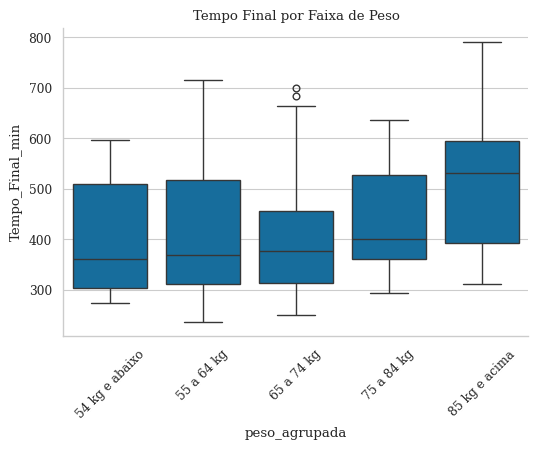

In [36]:
# Peso vs. Tempo Final
plt.figure(figsize=(6, 4))
# Remove None values before sorting to avoid TypeError
peso_order = sorted([x for x in df_peso["peso_agrupada"].unique() if x is not None])
sns.boxplot(data=df_peso, x="peso_agrupada", y="Tempo_Final_min", order=peso_order)
plt.title("Tempo Final por Faixa de Peso")
plt.xticks(rotation=45)
plt.show()


#### An√°lise da Variabilidade de Ritmo

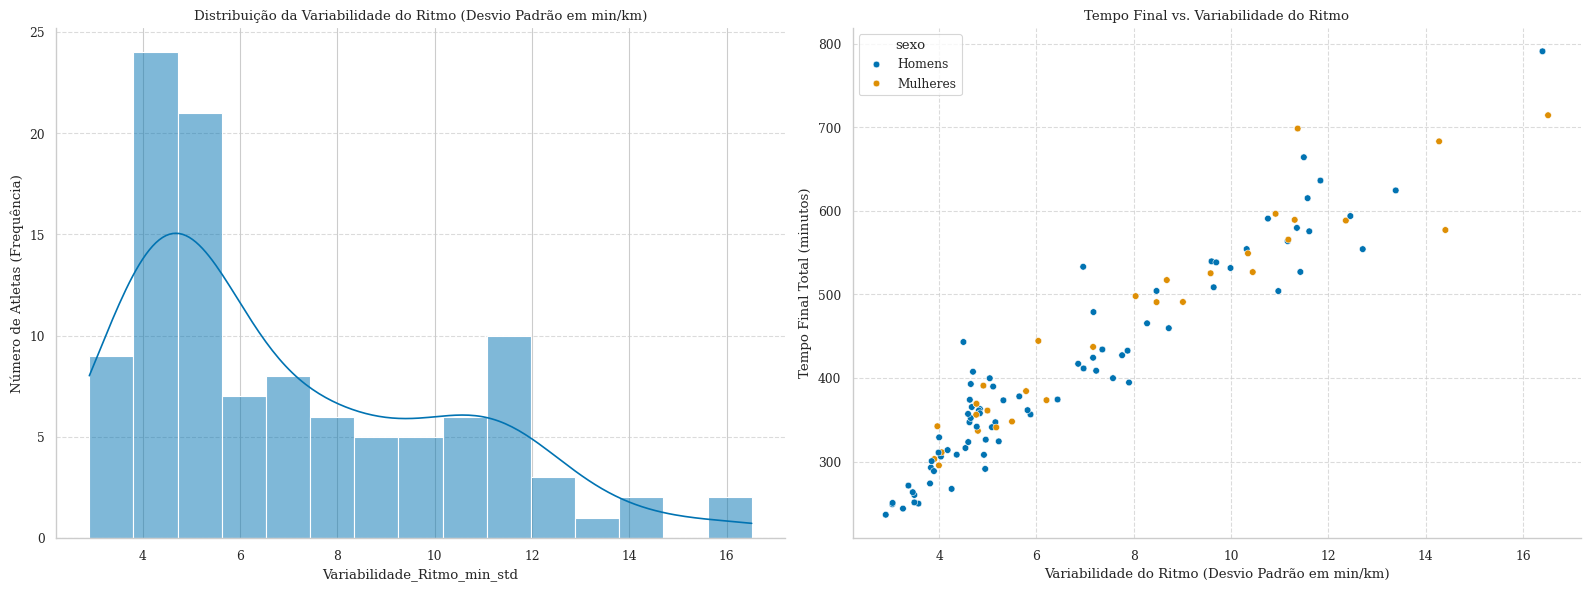

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o da Variabilidade do Ritmo (Desvio Padr√£o em min/km)")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Variabilidade do Ritmo")
axes[1].set_xlabel("Variabilidade do Ritmo (Desvio Padr√£o em min/km)")
axes[1].set_ylabel("Tempo Final Total (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

- Correla√ß√£o Positiva Evidente: O gr√°fico mostra uma clara e forte correla√ß√£o positiva entre as duas vari√°veis. Isso significa que, √† medida que a variabilidade do ritmo aumenta (eixo X), o tempo final da prova tamb√©m tende a aumentar (eixo Y).

- Interpreta√ß√£o Pr√°tica: Em termos simples, os atletas que mantiveram um ritmo mais constante e com menos oscila√ß√µes foram, em geral, os que terminaram a prova mais r√°pido. A consist√™ncia no ritmo parece ser um indicador chave para um bom desempenho.

- Comparativo entre Sexos: Ambos os grupos, homens e mulheres, seguem a mesma tend√™ncia linear. N√£o h√° uma separa√ß√£o clara dos grupos, indicando que essa rela√ß√£o entre consist√™ncia e performance √© v√°lida para ambos. No entanto, √© poss√≠vel notar que os pontos com o melhor desempenho combinado (canto inferior esquerdo, com baixo tempo e baixa variabilidade) s√£o, em sua maioria, de atletas masculinos.

- Conclus√£o: A consist√™ncia do ritmo √© um fator crucial para o desempenho nesta prova. Atletas menos eficientes em manter um passo est√°vel, provavelmente devido ao terreno ou √† estrat√©gia, acabaram com tempos de conclus√£o significativamente mais altos.

In [38]:
df_agregado_por_atleta[df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] > 16]

Nome Atleta      sexo faixa_etaria            peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std
31  Evelyn Carboneiro  Mulheres      35 a 44      55 a 64 kg         2023            42866      1224.742857               990.812630                   2779.0                  -2781.0       714.433333        20.412381                    16.513544
94     Robson Ribeiro    Homens      35 a 44  95 kg a 104 kg         2023            47456      1355.885714               983.911814                   2779.0                  -2781.0       790.933333        22.598095                    16.398530

In [39]:
df_filtro_atleta = df_completo.loc[
    df_completo["Nome Atleta"] == "Evelyn Carboneiro",
    ["Nome Atleta", "tempo_por_km_seg", "desnivel_positivo", "desnivel_negativo"],
]
df_filtro_atleta["Minutos"] = df_filtro_atleta["tempo_por_km_seg"] / 60
df_filtro_atleta

Nome Atleta  tempo_por_km_seg  desnivel_positivo  desnivel_negativo    Minutos
1946  Evelyn Carboneiro               367               13.0               -9.0   6.116667
1947  Evelyn Carboneiro               617               88.0                0.0  10.283333
1948  Evelyn Carboneiro               594               58.0                0.0   9.900000
1949  Evelyn Carboneiro               808               46.0              -81.0  13.466667
1950  Evelyn Carboneiro              1689               41.0              -58.0  28.150000
1951  Evelyn Carboneiro              1717              128.0              -11.0  28.616667
1952  Evelyn Carboneiro               667              228.0               -7.0  11.116667
1953  Evelyn Carboneiro               394                1.0             -243.0   6.566667
1954  Evelyn Carboneiro               558                1.0             -122.0   9.300000
1955  Evelyn Carboneiro              1486                9.0              -69.0  24.766667
1956  Evelyn Carboneiro               709              193.0              -37.0  11.816667
1957  Evelyn Carboneiro               848               68.0              -27.0  14.133333
1958  Evelyn Carboneiro               811               79.0              -18.0  13.516667
1959  Evelyn Carboneiro               597               83.0                0.0   9.950000
1960  Evelyn Carboneiro              2397               50.0              -15.0  39.950000
1961  Evelyn Carboneiro              4451              161.0              -26.0  74.183333
1962  Evelyn Carboneiro              4463              354.0               -2.0  74.383333
1963  Evelyn Carboneiro              2247              167.0              -42.0  37.450000
1964  Evelyn Carboneiro              1632              299.0              -30.0  27.200000
1965  Evelyn Carboneiro               835               15.0             -329.0  13.916667
1966  Evelyn Carboneiro              2722                7.0             -162.0  45.366667
1967  Evelyn Carboneiro              1503              149.0              -17.0  25.050000
1968  Evelyn Carboneiro               797              271.0              -13.0  13.283333
1969  Evelyn Carboneiro              1023               20.0             -145.0  17.050000
1970  Evelyn Carboneiro              1177                6.0             -137.0  19.616667
1971  Evelyn Carboneiro              1074               39.0             -136.0  17.900000
1972  Evelyn Carboneiro               682                3.0             -247.0  11.366667
1973  Evelyn Carboneiro               665                0.0             -251.0  11.083333
1974  Evelyn Carboneiro               613                1.0             -122.0  10.216667
1975  Evelyn Carboneiro               817                0.0             -141.0  13.616667
1976  Evelyn Carboneiro              1055                1.0              -79.0  17.583333
1977  Evelyn Carboneiro               921               44.0               -1.0  15.350000
1978  Evelyn Carboneiro              1065              143.0               -1.0  17.750000
1979  Evelyn Carboneiro               489               11.0              -52.0   8.150000
1980  Evelyn Carboneiro               376                2.0             -151.0   6.266667

In [40]:
df_coef_var = df_agregado_por_atleta.copy()
df_coef_var["coef_var"] = (
    df_coef_var["Variabilidade_Ritmo_min_std"] / df_coef_var["Ritmo_Medio_min"]
)
df_coef_var.head()

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  coef_var
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189  0.479953
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947  0.470002
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993  0.712763
3          Alex Junior Aj  Homens      20 a 24  65 a 74 kg         2022            18496       513.777778               261.647539                   2787.0                  -2790.0       308.266667         8.562963                     4.360792  0.509262
4      Alexandre Santiago  Homens      35 a 44  55 a 64 kg         2022            14626       417.885714               195.390826                   2779.0                  -2781.0       243.766667         6.964762                     3.256514  0.467570

In [41]:
df_coef_var.loc[
    df_coef_var["Nome Atleta"] == "Evelyn Carboneiro",
    [
        "Nome Atleta",
        "Tempo_Final_min",
        "Ritmo_Medio_min",
        "Variabilidade_Ritmo_min_std",
        "coef_var",
    ],
]

Nome Atleta  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  coef_var
31  Evelyn Carboneiro       714.433333        20.412381                    16.513544  0.808996

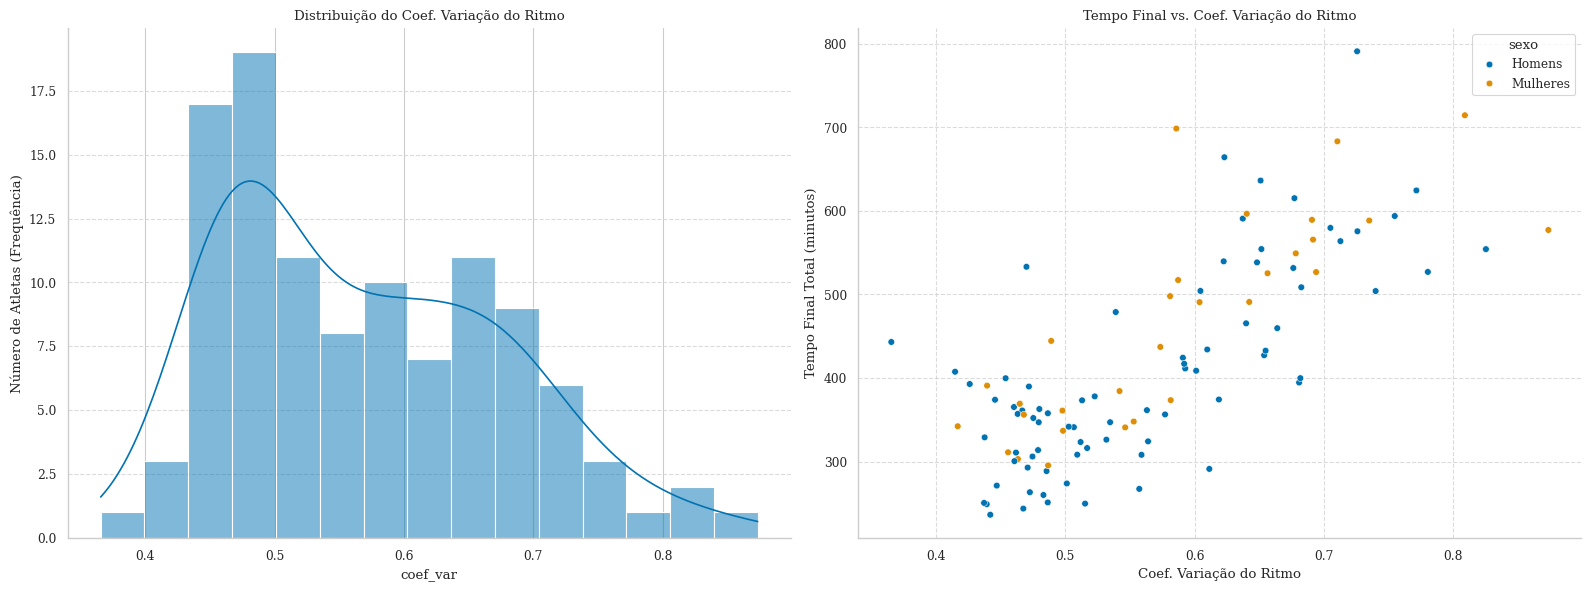

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(
    data=df_coef_var,
    x="coef_var",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Coef. Varia√ß√£o do Ritmo")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_coef_var,
    x="coef_var",
    y="Tempo_Final_min",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Coef. Varia√ß√£o do Ritmo")
axes[1].set_xlabel("Coef. Varia√ß√£o do Ritmo")
axes[1].set_ylabel("Tempo Final Total (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

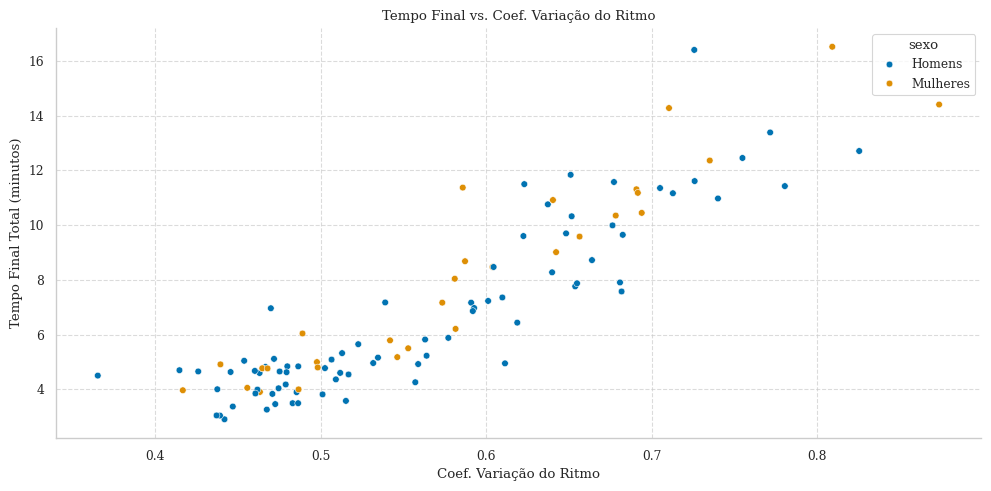

In [43]:
sns.scatterplot(
    data=df_coef_var,
    x="coef_var",
    y="Variabilidade_Ritmo_min_std",
    hue="sexo",  # Direciona o plot para o segundo eixo
)
plt.title("Tempo Final vs. Coef. Varia√ß√£o do Ritmo")
plt.xlabel("Coef. Varia√ß√£o do Ritmo")
plt.ylabel("Tempo Final Total (minutos)")
plt.grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

###### Teste de Associa√ß√£o: Tempo Final vs. Variabilidade do Ritmo

Nesta an√°lise, o foco √© determinar se a consist√™ncia do ritmo de um atleta tem impacto em seu desempenho final. Especificamente, buscaremos responder √† pergunta: "Uma maior variabilidade no ritmo (Variabilidade_Ritmo_min_std) est√° correlacionada com um tempo final de prova pior?". Nossa expectativa inicial √© encontrar uma correla√ß√£o positiva, onde um ritmo mais inconstante leva a um tempo maior.

Para validar esta hip√≥tese, realizaremos os seguintes passos:

Defini√ß√£o das Hip√≥teses:

> H0: N√£o h√° correla√ß√£o entre o tempo final e a variabilidade do ritmo.

> H1: Existe correla√ß√£o entre o tempo final e a variabilidade do ritmo.

- An√°lise Visual: Gera√ß√£o de um gr√°fico de dispers√£o para inspecionar a forma, a dire√ß√£o e a presen√ßa de outliers na rela√ß√£o entre as duas vari√°veis.

- Escolha do Teste: Com base na an√°lise visual e na verifica√ß√£o de pressupostos (como a normalidade dos dados), selecionaremos o teste de correla√ß√£o mais adequado ‚Äî Pearson para rela√ß√µes lineares e dados normais, ou Spearman para rela√ß√µes monot√¥nicas ou dados n√£o-normais.

- Interpreta√ß√£o: Analisaremos o coeficiente de correla√ß√£o (de -1 a 1) e o p-valor para determinar a for√ßa, a dire√ß√£o e a signific√¢ncia estat√≠stica da associa√ß√£o.

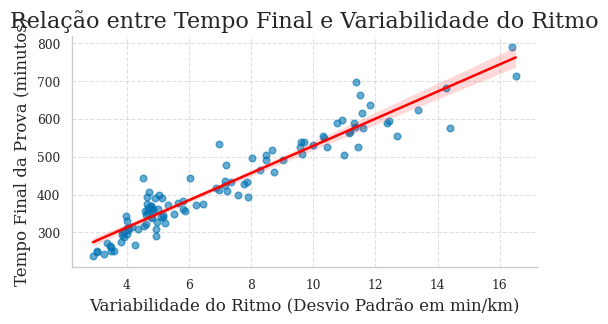

In [44]:
plt.figure(figsize=(6, 3))

sns.regplot(
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    data=df_agregado_por_atleta,
    scatter_kws={"alpha": 0.6},  # Deixa os pontos um pouco transparentes
    line_kws={"color": "red"},  # Deixa a linha de tend√™ncia vermelha
)

plt.title("Rela√ß√£o entre Tempo Final e Variabilidade do Ritmo", fontsize=16)
plt.xlabel("Variabilidade do Ritmo (Desvio Padr√£o em min/km)", fontsize=12)
plt.ylabel("Tempo Final da Prova (minutos)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

- O grafico gerado mostra uma rela√ß√£o claramente positiva (a linha sobe da esquerda para a direita) e fortemente linear (os pontos se ajustam muito bem √† linha de regress√£o vermelha).

- Interpreta√ß√£o visual: Fica evidente que, √† medida que a variabilidade do ritmo de um atleta aumenta, seu tempo final de prova tamb√©m tende a aumentar. Isso suporta visualmente a sua hip√≥tese.

Verfica√ß√£o da Normalidade das Variaveis

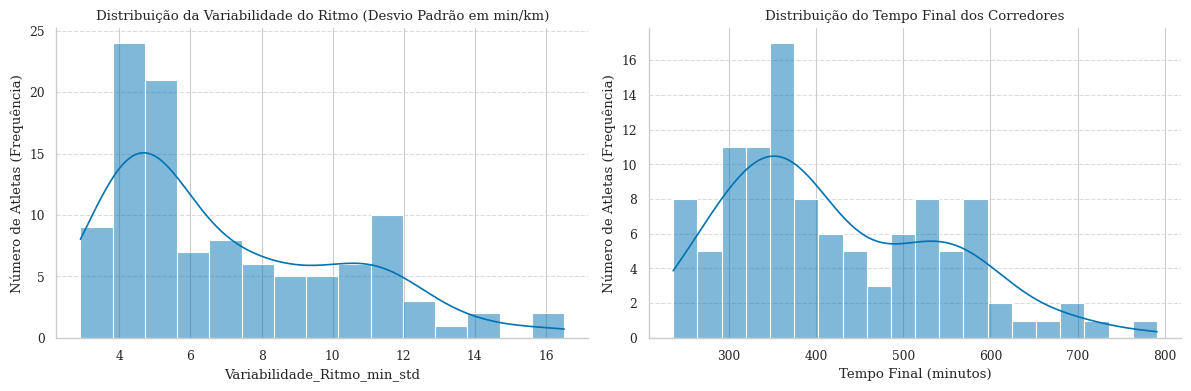

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o da Variabilidade do Ritmo (Desvio Padr√£o em min/km)")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.histplot(
    data=df_agregado_por_atleta,
    x="Tempo_Final_min",
    kde=True,
    bins=20,
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Distribui√ß√£o do Tempo Final dos Corredores")
axes[1].set_xlabel("Tempo Final (minutos)")  # Adicionando r√≥tulo ao eixo x
axes[1].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

In [46]:
print("\n--- Verificando Pressuposto de Normalidade das Vari√°veis ---")

# Vari√°vel 1: Tempo Final
stat_tempo, p_shapiro_tempo = stats.shapiro(df_agregado_por_atleta["Tempo_Final_min"])
print(f"P-valor do Teste de Shapiro-Wilk para 'Tempo_Final_min': {p_shapiro_tempo:.4f}")

# Vari√°vel 2: Variabilidade do Ritmo
stat_var, p_shapiro_var = stats.shapiro(
    df_agregado_por_atleta["Variabilidade_Ritmo_min_std"]
)
print(
    f"P-valor do Teste de Shapiro-Wilk para 'Variabilidade_Ritmo_min_std': {p_shapiro_var:.4f}"
)

# Avalia√ß√£o da normalidade
if p_shapiro_tempo > 0.05 and p_shapiro_var > 0.05:
    print("\nConclus√£o: Ambas as vari√°veis parecem seguir uma distribui√ß√£o normal.")
else:
    print(
        "\nConclus√£o: Pelo menos uma das vari√°veis N√ÉO segue uma distribui√ß√£o normal."
    )



--- Verificando Pressuposto de Normalidade das Vari√°veis ---
P-valor do Teste de Shapiro-Wilk para 'Tempo_Final_min': 0.0002
P-valor do Teste de Shapiro-Wilk para 'Variabilidade_Ritmo_min_std': 0.0000

Conclus√£o: Pelo menos uma das vari√°veis N√ÉO segue uma distribui√ß√£o normal.


**Observa√ß√£o Metodol√≥gica: Escolha do Coeficiente de Correla√ß√£o**

A an√°lise de correla√ß√£o entre o **Tempo Final da Prova** e a **Variabilidade do Ritmo** exige a escolha de um coeficiente apropriado. Embora a Correla√ß√£o de Pearson (r) seja amplamente utilizada para avaliar a for√ßa de uma associa√ß√£o linear, seu uso pressup√µe que os dados de ambas as vari√°veis seguem uma distribui√ß√£o normal.

Nesta an√°lise, o pressuposto de normalidade foi formalmente testado para cada vari√°vel utilizando o Teste de Shapiro-Wilk. Os resultados indicaram uma viola√ß√£o clara deste pressuposto para ambas as vari√°veis:
* `Tempo_Final_min` (p < 0.001)
* `Variabilidade_Ritmo_min_std` (p < 0.001)

Conforme as diretrizes para o uso apropriado de coeficientes de correla√ß√£o, quando a suposi√ß√£o de normalidade n√£o √© atendida, o uso da Correla√ß√£o de Pearson pode levar a conclus√µes inv√°lidas. A literatura estat√≠stica, como o guia proposto por Mukaka (2012), recomenda o uso de alternativas n√£o-param√©tricas em tais cen√°rios para garantir a validade dos resultados.

Portanto, para assegurar a robustez da an√°lise, optou-se pela **Correla√ß√£o de Spearman (œÅ)**. Este m√©todo, por ser baseado em postos (ranks), n√£o exige a normalidade dos dados e √© adequado para medir a for√ßa de uma rela√ß√£o monot√¥nica (que consistentemente aumenta ou diminui), como a observada no gr√°fico de dispers√£o.

**Refer√™ncia:**
* Mukaka MM. Statistics corner: A guide to appropriate use of correlation coefficient in medical research. Malawi Med J. 2012 Sep;24(3):69-71. PMID: 23638278; PMCID: PMC3576830.

In [47]:
# Extraindo as duas vari√°veis para o teste
tempo_final = df_agregado_por_atleta["Tempo_Final_min"]
variabilidade_ritmo = df_agregado_por_atleta["Variabilidade_Ritmo_min_std"]

# Calculando a Correla√ß√£o de Spearman
coeficiente_rho, p_valor = stats.spearmanr(tempo_final, variabilidade_ritmo)

print("--- Resultados do Teste de Correla√ß√£o de Spearman ---")
print(f"Coeficiente de Correla√ß√£o de Spearman (rho): {coeficiente_rho:.4f}")
print(f"P-valor: {p_valor}")

# --- Interpreta√ß√£o dos Resultados ---
print("\n--- Interpreta√ß√£o ---")
# Interpretando a for√ßa da correla√ß√£o
if abs(coeficiente_rho) >= 0.8:
    forca = "muito forte"
elif abs(coeficiente_rho) >= 0.6:
    forca = "forte"
elif abs(coeficiente_rho) >= 0.4:
    forca = "moderada"
else:
    forca = "fraca"

# Interpretando a dire√ß√£o
if coeficiente_rho > 0:
    direcao = "positiva"
else:
    direcao = "negativa"

print(f"O resultado mostra uma correla√ß√£o {direcao} e {forca} entre as vari√°veis.")

# Interpretando a signific√¢ncia estat√≠stica
alfa = 0.05
if p_valor < alfa:
    print(
        f"Como o p-valor ({p_valor:.4g}) √© menor que {alfa}, a correla√ß√£o √© estatisticamente significativa."
    )
    print("Rejeitamos a hip√≥tese nula de que n√£o h√° associa√ß√£o entre as vari√°veis.")
else:
    print(
        f"Como o p-valor ({p_valor:.4g}) √© maior que {alfa}, a correla√ß√£o N√ÉO √© estatisticamente significativa."
    )
    print("N√£o podemos rejeitar a hip√≥tese nula.")

--- Resultados do Teste de Correla√ß√£o de Spearman ---
Coeficiente de Correla√ß√£o de Spearman (rho): 0.9388
P-valor: 2.4385592785121793e-51

--- Interpreta√ß√£o ---
O resultado mostra uma correla√ß√£o positiva e muito forte entre as vari√°veis.
Como o p-valor (2.439e-51) √© menor que 0.05, a correla√ß√£o √© estatisticamente significativa.
Rejeitamos a hip√≥tese nula de que n√£o h√° associa√ß√£o entre as vari√°veis.


**Conclus√£o Final: Correla√ß√£o entre Tempo e Variabilidade de Ritmo**

A an√°lise de correla√ß√£o foi realizada para investigar a associa√ß√£o entre o tempo final de prova de um atleta (`Tempo_Final_min`) e a sua consist√™ncia de ritmo (`Variabilidade_Ritmo_min_std`). Com base nos resultados, podemos concluir que:

* **For√ßa e Dire√ß√£o da Rela√ß√£o:** O teste de Correla√ß√£o de Spearman revelou um coeficiente **(œÅ) de 0.94**. Este valor indica uma **correla√ß√£o positiva muito forte** entre as duas vari√°veis.

* **Signific√¢ncia Estat√≠stica:** O p-valor obtido foi extremamente baixo (p ‚âà 2.44 x 10‚Åª‚Åµ¬π), muito inferior ao n√≠vel de signific√¢ncia de 0.05. Isso nos permite **rejeitar a hip√≥tese nula** com grande confian√ßa, confirmando que a correla√ß√£o observada n√£o se deve ao acaso.

* **Interpreta√ß√£o Pr√°tica:** A forte correla√ß√£o positiva responde diretamente √† pergunta de pesquisa. Existe uma associa√ß√£o estatisticamente significativa onde uma **maior variabilidade no ritmo est√° associada a um tempo final de prova pior (maior)**. Em outras palavras, os atletas que mantiveram um ritmo mais constante ao longo da corrida tenderam a obter melhores tempos, enquanto aqueles cujo ritmo oscilou mais tiveram um desempenho inferior. Este achado sugere que a consist√™ncia √© um fator crucial para o bom desempenho nesta prova de corrida de montanha.

### Analisando Partes da Prova

Vamos analisar o tempo m√©dio entre primeira metade e segunda metade da prova.

- (Split Positivo): Significa que o ritmo na segunda metade foi mais alto (mais lento)
- (Split Negativo): Seria o caso de um atleta que correu a segunda metade mais r√°pido que a primeira.

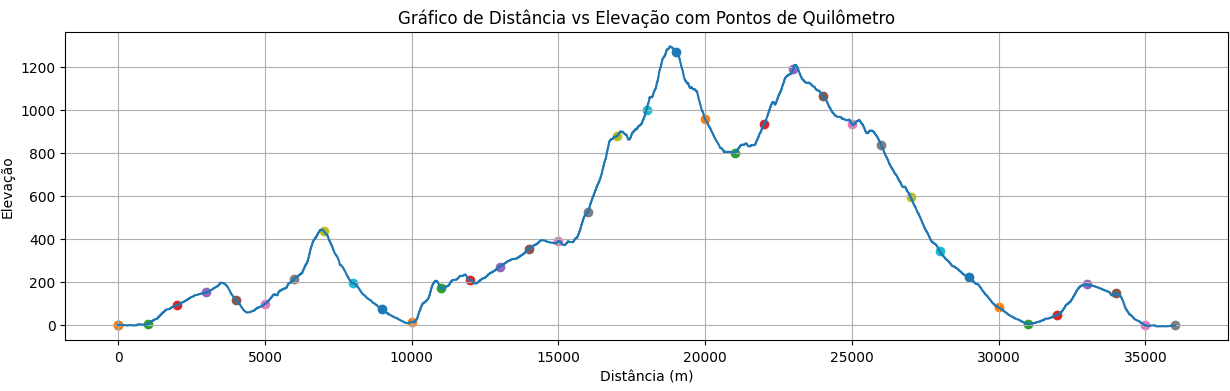

In [48]:
df_metade = df_completo.copy()
df_metade["Metade_Prova"] = "Primeira Metade"
df_metade.loc[df_metade["km_prova"] > 18.0, "Metade_Prova"] = "Segunda Metade"
df_metade.head(5)

Nome Atleta    sexo faixa_etaria           peso   ano  km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo     Metade_Prova
0  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       1.0               285             2023               13.0               -9.0  Primeira Metade
1  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       2.0               298             2023               88.0                0.0  Primeira Metade
2  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       3.0               295             2023               58.0                0.0  Primeira Metade
3  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       4.0               363             2023               46.0              -81.0  Primeira Metade
4  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       5.0               357             2023               41.0              -58.0  Primeira Metade

In [49]:
df_kms = (
    df_metade[["km_prova", "desnivel_positivo", "desnivel_negativo", "Metade_Prova"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_kms.head()

km_prova  desnivel_positivo  desnivel_negativo     Metade_Prova
0       1.0               13.0               -9.0  Primeira Metade
1       2.0               88.0                0.0  Primeira Metade
2       3.0               58.0                0.0  Primeira Metade
3       4.0               46.0              -81.0  Primeira Metade
4       5.0               41.0              -58.0  Primeira Metade

In [50]:
estatisticas_describe = ["sum", "mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = (
    df_kms.groupby("Metade_Prova")
    .agg(
        {
            "desnivel_positivo": estatisticas_describe,
            "desnivel_negativo": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Parte da Prova ---
                                      sum    mean    std    min  median    max
Metade_Prova                                                                  
Primeira Metade desnivel_negativo  -767.0  -42.61  60.04 -243.0   -22.0    0.0
                desnivel_positivo  1768.0   98.22  92.83    1.0    73.5  354.0
Segunda Metade  desnivel_negativo -2023.0 -112.39  96.21 -329.0  -129.0   -1.0
                desnivel_positivo  1019.0   56.61  94.61    0.0     9.5  299.0


C:\Users\Home\AppData\Local\Temp\ipykernel_3328\4073048671.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


Primeira Metade: A Fase de "Conquista"
Ganho de Eleva√ß√£o Total (sum): Voc√™ sobe 1768 metros.

Perfil Predominante: √â majoritariamente subida. O ganho de eleva√ß√£o (+1768m) √© mais que o dobro da perda (-767m).

Dificuldade M√©dia (mean/median): Um quil√¥metro t√≠pico tem uma subida brutal. A m√©dia de ganho √© de 98.2m por km, e a mediana √© de 73.5m, indicando subidas constantes e √≠ngremes.

Pico de Dificuldade (max): Existe pelo menos um quil√¥metro com 354 metros de subida, uma verdadeira "parede".

Segunda Metade: A Fase de "Descida e Velocidade"
Perda de Eleva√ß√£o Total (sum): Voc√™ desce -2023 metros.

Perfil Predominante: √â majoritariamente descida. A perda de eleva√ß√£o (-2023m) √© o dobro do ganho (+1019m).

Dificuldade M√©dia (mean/median): Um quil√¥metro t√≠pico √© quase plano. A mediana de ganho de apenas 9.5m revela que a maioria dos quil√¥metros tem pouca ou nenhuma subida, permitindo um ritmo muito mais r√°pido.

Pico de Dificuldade (max): Ainda existem subidas duras (m√°ximo de 299m), mas s√£o mais pontuais e menos frequentes que na primeira metade.

Resumo Comparativo Final
Balan√ßo (Subida vs. Descida):

Primeira Metade: Saldo positivo de +1001 metros (muito mais sobe do que desce).

Segunda Metade: Saldo negativo de -1004 metros (muito mais desce do que sobe).

Esses n√∫meros provam que a estrat√©gia correta √© ser extremamente conservador no in√≠cio, pois a maior parte do esfor√ßo de subida est√° concentrada na primeira metade, enquanto a segunda metade oferece um terreno muito mais favor√°vel para correr.

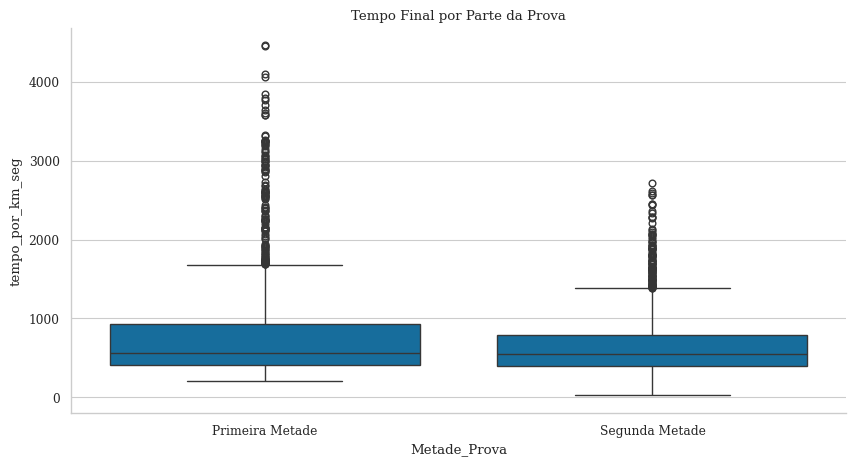

In [51]:
sns.boxplot(data=df_metade, x="Metade_Prova", y="tempo_por_km_seg")
plt.title("Tempo Final por Parte da Prova")
plt.show()

In [52]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = (
    df_metade.groupby("Metade_Prova")
    .agg({"tempo_por_km_seg": estatisticas_describe})
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Parte da Prova ---
                                    mean     std  min  median   max
Metade_Prova                                                       
Primeira Metade tempo_por_km_seg  773.61  591.85  200   565.0  4463
Segunda Metade  tempo_por_km_seg  647.59  379.41   23   546.5  2722


C:\Users\Home\AppData\Local\Temp\ipykernel_3328\3022996380.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


- Primeira Metade (Com mais subidas):

Ritmo mais lento e variado: A grande quantidade de subidas for√ßa os atletas a desacelerar, o que explica os tempos mais altos e a maior varia√ß√£o de performance.

Quil√¥metros mais dif√≠ceis: Os tempos extremamente lentos (outliers) confirmam que as subidas mais brutais est√£o nesta parte.

- Segunda Metade (Com menos subidas):

Ritmo mais r√°pido e consistente: Com um terreno mais favor√°vel, os atletas conseguem impor um ritmo mais forte e constante.

Prova de perfil assim√©trico: O gr√°fico n√£o mostra que os atletas est√£o menos cansados, mas sim que a maior dificuldade da prova est√° concentrada no in√≠cio.

In [53]:
ritmo_por_metade = df_metade.groupby(["Nome Atleta", "Metade_Prova"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_metade.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para n√£o alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = [
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Tempo_Total_Primeira_Metade",
    "Tempo_Total_Segunda_Metade",
]
for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a convers√£o (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


comparativo_splits_flat["Diferenca_Media_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Ritmo_Medio_Segunda_Metade_min"]
    - comparativo_splits_flat["Ritmo_Medio_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat["Diferenca_total_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Tempo_Total_Segunda_Metade_min"]
    - comparativo_splits_flat["Tempo_Total_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat.head(5)

Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri
Nome Atleta                                                                                                                                                                                                                                                                                                                             
ALFREDO GUIMARAES                        667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76
Albert Melo                              942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66
Alessandro Sousa(all√™)                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47
Alex Junior Aj                           598.944444                  428.611111                        10781                        7715                             9.98                            7.14                           179.68                          128.58                          -2.84                         -51.10
Alexandre Santiago                       467.722222                  365.117647                         8419                        6207                             7.80                            6.09                           140.32                          103.45                          -1.71                         -36.87

In [54]:
# Vamos unir as duas tabelas
df_final_completo = pd.merge(
    left=df_agregado_por_atleta,  # A tabela principal, da esquerda
    right=comparativo_splits_flat,  # A tabela com os splits, da direita
    left_on="Nome Atleta",  # A chave na tabela da esquerda √© a COLUNA 'Nome Atleta'
    right_index=True,  # A chave na tabela da direita √© o √çNDICE (que tamb√©m √© o nome do atleta)
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo.head()
df_final_completo.to_csv("Dados/df_agregado_por_atleta.csv", sep=";")

In [55]:
df_final_completo.head(3)

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947                   942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47

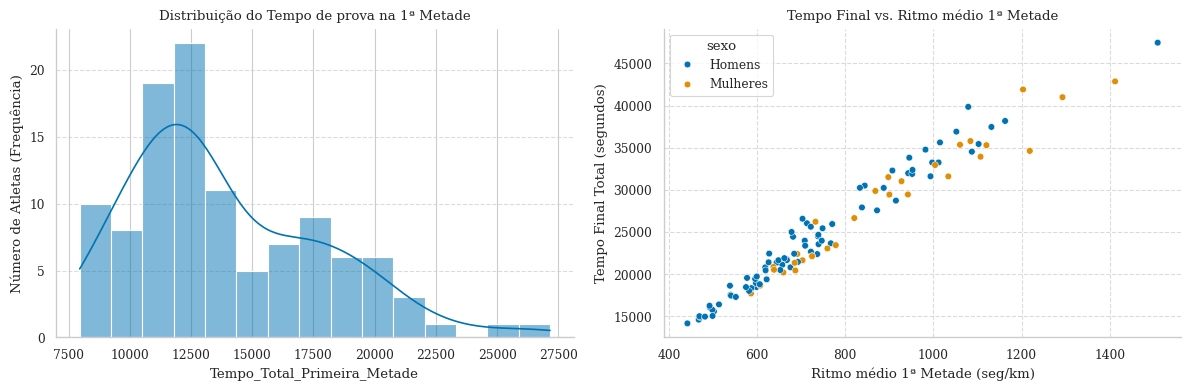

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_completo,
    x="Tempo_Total_Primeira_Metade",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Tempo de prova na 1¬™ Metade")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Primeira_Metade",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Ritmo m√©dio 1¬™ Metade")
axes[1].set_xlabel("Ritmo m√©dio 1¬™ Metade (seg/km)")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

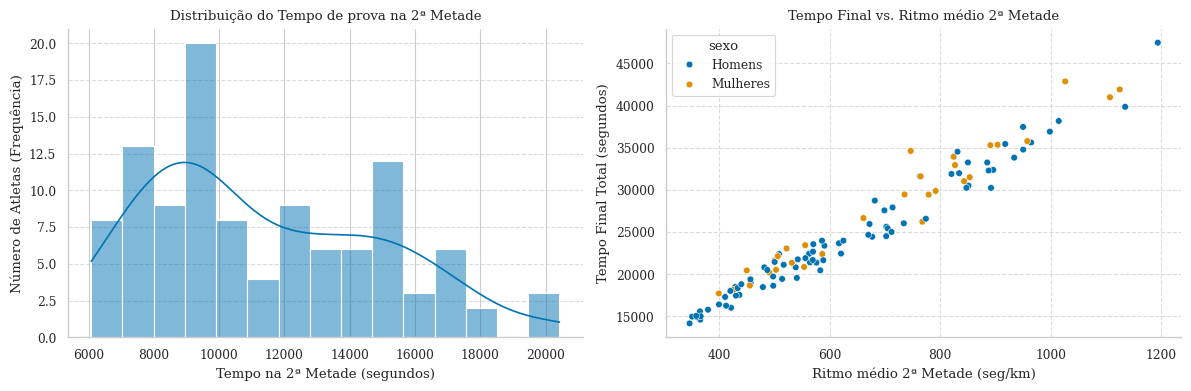

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(
    data=df_final_completo,
    x="Tempo_Total_Segunda_Metade",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Tempo de prova na 2¬™ Metade")
axes[0].set_xlabel("Tempo na 2¬™ Metade (segundos)")  # Adicionando r√≥tulo ao eixo x
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Segunda_Metade",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Ritmo m√©dio 2¬™ Metade")
axes[1].set_xlabel("Ritmo m√©dio 2¬™ Metade (seg/km)")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

- **Gr√°fico da 1¬™ Metade (Subidas)**: Os pontos parecem formar uma linha mais coesa e estreita. A rela√ß√£o parece muito forte e direta. A dispers√£o dos pontos em torno de uma linha de tend√™ncia imagin√°ria √© relativamente pequena.

- **Gr√°fico da 2¬™ Metade (Descidas)**: Os pontos ainda seguem uma tend√™ncia linear, mas parecem estar um pouco mais espalhados. A "nuvem" de pontos √© um pouco mais larga.

Ap√≥s estabelecermos a din√¢mica de 'split negativo' da prova, onde a segunda metade √© consistentemente mais r√°pida devido √† sua altimetria favor√°vel, uma nova quest√£o emerge: 

> **Qual dos dois segmentos da corrida √© mais decisivo para o resultado final de um atleta?**

Em outras palavras, o desempenho na primeira metade, marcada pelas subidas e pelo maior desgaste, √© um indicador mais forte do tempo final? Ou a performance na segunda metade, que exige t√©cnica e a capacidade de capitalizar nas descidas, tem uma influ√™ncia maior? A an√°lise a seguir busca quantificar a for√ßa da rela√ß√£o entre o ritmo de cada metade e o tempo total de prova para determinar qual fase √© mais preditiva do sucesso.

-  O "Porqu√™" por Tr√°s da Hip√≥tese
Isso faz total sentido no contexto de uma prova de montanha:

*A 1¬™ Metade (subidas) funciona como um "filtro" de condicionamento f√≠sico. Um atleta que n√£o tem um bom preparo f√≠sico registrar√° um tempo muito alto aqui, e ser√° praticamente imposs√≠vel compensar essa diferen√ßa, n√£o importa qu√£o bem ele des√ßa. O desempenho nesta fase estabelece uma "base" s√≥lida para o tempo final.*

*A 2¬™ Metade (descidas) introduz outras vari√°veis, como habilidade t√©cnica, coragem para arriscar e o n√≠vel de fadiga acumulado. Um atleta pode ser muito forte na subida, mas um descensor cauteloso, ou vice-versa. Isso cria uma variabilidade maior, enfraquecendo ligeiramente a correla√ß√£o direta com o tempo final.*

**Vamos fazer a correla√ß√£o de Pearson para medir essa rela√ß√£o e depois comparar se h√° diferen√ßa significativa entre os valores**

In [58]:
correlacoes = df_final_completo[
    ["Tempo_Final_seg", "Ritmo_Medio_Primeira_Metade", "Ritmo_Medio_Segunda_Metade"]
].corr()

print(correlacoes)

                             Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade
Tempo_Final_seg                     1.000000                     0.978312                    0.977793
Ritmo_Medio_Primeira_Metade         0.978312                     1.000000                    0.919045
Ritmo_Medio_Segunda_Metade          0.977793                     0.919045                    1.000000


- A an√°lise mostra que tanto o ritmo na primeira metade quanto na segunda s√£o preditores excepcionalmente fortes do tempo final, com correla√ß√µes quase perfeitas. Embora a primeira metade tenha uma correla√ß√£o marginalmente maior, a diferen√ßa √© t√£o trivial que n√£o √© estatisticamente significativa. Para todos os efeitos pr√°ticos, voc√™ pode concluir que o desempenho em ambas as metades da prova √© igualmente crucial e determinante para o resultado final do atleta.

- **Ponto de Aten√ß√£o**: Existe uma correla√ß√£o alta entre duas var√°iveis que podem vir a ser usadas numa futura modelagem.

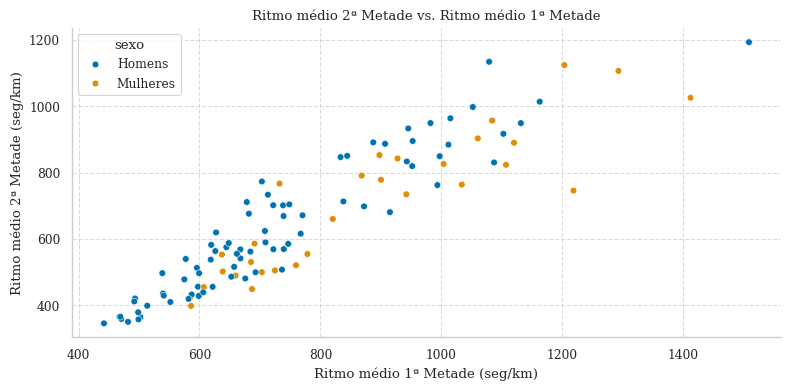

In [59]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Primeira_Metade",
    y="Ritmo_Medio_Segunda_Metade",
    hue="sexo",
)
plt.title("Ritmo m√©dio 2¬™ Metade vs. Ritmo m√©dio 1¬™ Metade")
plt.ylabel("Ritmo m√©dio 2¬™ Metade (seg/km)")
plt.xlabel("Ritmo m√©dio 1¬™ Metade (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### An√°lise do ritmo m√©dio por parte da prova

In [60]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_final_completo.groupby("sexo").agg(
    {
        "Ritmo_Medio_Primeira_Metade": estatisticas_describe,
        "Ritmo_Medio_Segunda_Metade": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Partes da prova e sexo ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Partes da prova e sexo ---
         Ritmo_Medio_Primeira_Metade                                  Ritmo_Medio_Segunda_Metade                                 
                                mean     std     min  median      max                       mean     std     min  median      max
sexo                                                                                                                             
Homens                        733.70  205.20  442.06  683.00  1508.89                     630.23  205.83  345.94  579.14  1193.88
Mulheres                      874.04  227.69  584.89  820.61  1412.22                     696.23  208.43  398.78  735.29  1124.94


In [61]:
820.61 - 735.29

85.32000000000005

In [62]:
683 - 579.14

103.86000000000001

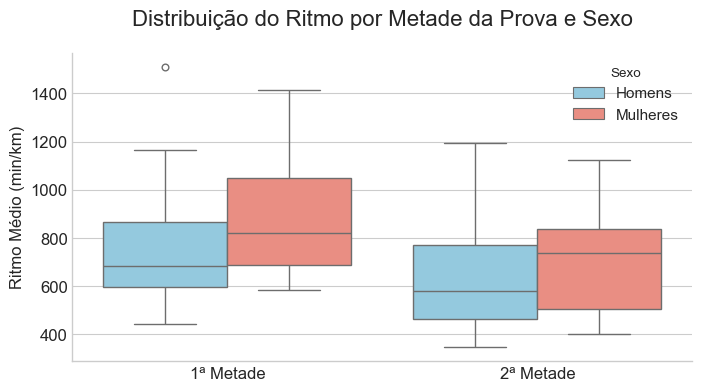

In [63]:
df_melted = pd.melt(
    df_final_completo,
    id_vars=["sexo"],
    value_vars=["Ritmo_Medio_Primeira_Metade", "Ritmo_Medio_Segunda_Metade"],
    var_name="Metade da Prova",
    value_name="Ritmo M√©dio (min/km)",
)

# Opcional: Renomear os valores para ficarem mais bonitos no gr√°fico
df_melted["Metade da Prova"] = df_melted["Metade da Prova"].replace(
    {
        "Ritmo_Medio_Primeira_Metade": "1¬™ Metade",
        "Ritmo_Medio_Segunda_Metade": "2¬™ Metade",
    }
)


# --- Passo 3: Criar o gr√°fico boxplot ---
plt.style.use("seaborn-v0_8-whitegrid")  # Estilo do gr√°fico
plt.figure(figsize=(8, 4))  # Tamanho do gr√°fico

sns.boxplot(
    data=df_melted,
    x="Metade da Prova",
    y="Ritmo M√©dio (min/km)",
    hue="sexo",
    palette={"Homens": "skyblue", "Mulheres": "salmon"},  # Cores personalizadas
)

# Adicionando T√≠tulos e R√≥tulos
plt.title("Distribui√ß√£o do Ritmo por Metade da Prova e Sexo", fontsize=16, pad=20)
plt.xlabel("")  # Eixo X n√£o precisa de r√≥tulo
plt.ylabel("Ritmo M√©dio (min/km)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Sexo", fontsize=11)


# Exibir o gr√°fico
plt.show()

**An√°lise da 1¬™ Metade (Subidas):**

- Desempenho M√©dio: A mediana do ritmo dos homens (linha no meio da caixa azul, ~680 seg/km ou 11:20 min/km) √© visivelmente mais baixa (mais r√°pida) que a das mulheres (~820 seg/km ou 13:40 min/km). Isso indica que, como esperado, o atleta homem mediano foi mais r√°pido na se√ß√£o de subida.

- Variabilidade: A caixa azul (Homens) √© mais "curta" que a caixa vermelha (Mulheres). Isso significa que a performance do grupo masculino foi mais homog√™nea; a diferen√ßa de ritmo entre os 25% mais r√°pidos e os 25% mais lentos do "miolo" do grupo √© menor. O desempenho das mulheres foi mais heterog√™neo, com uma maior dispers√£o de ritmos.

- Outlier: Existe um atleta homem que foi um outlier, com um ritmo significativamente mais lento que seus pares na primeira metade.

**An√°lise da 2¬™ Metade (Descidas):**
- Desempenho M√©dio: A diferen√ßa se mant√©m. A mediana dos homens (~580 seg/km ou 9:40 min/km) continua mais r√°pida que a das mulheres (~730 seg/km ou 12:10 min/km).

- Melhora de Performance: √â n√≠tido que ambos os grupos foram muito mais r√°pidos na segunda metade. Todas as caixas da direita est√£o posicionadas mais abaixo no gr√°fico do que as da esquerda, confirmando visualmente o forte "split negativo" para todos.

- Variabilidade: A variabilidade para ambos os grupos continua alta, como √© comum em trechos de descida que envolvem diferentes n√≠veis de t√©cnica e disposi√ß√£o ao risco. A performance masculina ainda parece um pouco mais concentrada que a feminina.

**Resumo das Conclus√µes**
- Desempenho Absoluto: Em termos de ritmo absoluto, os homens foram, em m√©dia, mais r√°pidos que as mulheres tanto na se√ß√£o de subida (1¬™ metade) quanto na de descida (2¬™ metade).

- Consist√™ncia do Grupo: O grupo masculino apresentou uma performance mais consistente e homog√™nea na primeira metade da prova, com menor varia√ß√£o de ritmo entre seus atletas em compara√ß√£o ao grupo feminino.

- Impacto do Percurso: O gr√°fico confirma de forma inequ√≠voca que o perfil do percurso (subidas e depois descidas) foi o fator dominante na estrat√©gia de ritmo, for√ßando todos os atletas, independentemente do sexo, a serem significativamente mais r√°pidos na segunda metade.

- Din√¢mica Universal: Embora os homens sejam em m√©dia mais r√°pidos, a din√¢mica geral da prova ‚Äî um in√≠cio mais lento e um final muito mais r√°pido ‚Äî √© uma caracter√≠stica universal para ambos os sexos.

##### Analise **Tempo de Prova** x **Diferen√ßa** entre primeira e segunda parte da prova.

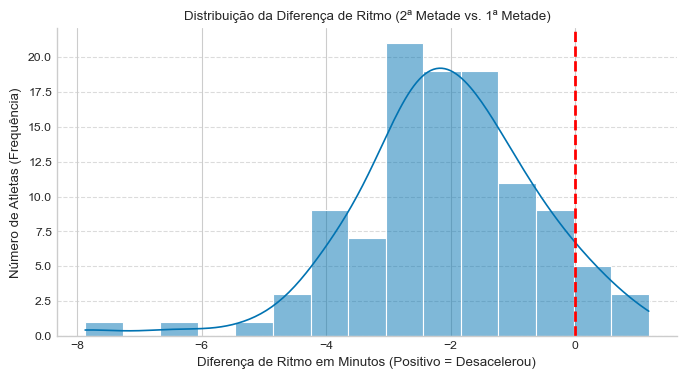

In [64]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_final_completo, x="Diferenca_Media_Seg_Menos_Pri", kde=True, bins=15
)

# Adiciona uma linha vertical em x=0 para ser nossa refer√™ncia
# √Ä esquerda da linha: atletas que aceleraram (split negativo)
# √Ä direita da linha: atletas que desaceleraram (split positivo)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2)

plt.title("Distribui√ß√£o da Diferen√ßa de Ritmo (2¬™ Metade vs. 1¬™ Metade)")
plt.xlabel("Diferen√ßa de Ritmo em Minutos (Positivo = Desacelerou)")
plt.ylabel("N√∫mero de Atletas (Frequ√™ncia)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

A an√°lise da distribui√ß√£o da diferen√ßa de ritmo entre a primeira e a segunda metade da prova (gr√°fico de histograma) revelou um insight fundamental sobre a natureza da competi√ß√£o. Observou-se que a grande maioria dos atletas concluintes apresentou um "split negativo", ou seja, um ritmo m√©dio mais r√°pido na segunda metade do percurso.

Este padr√£o, evidenciado pelo pico da distribui√ß√£o em valores negativos (-2 a -3 min/km), n√£o deve ser interpretado primariamente como uma escolha estrat√©gica deliberada dos atletas. A causa raiz mais prov√°vel √© o perfil altim√©trico do percurso, com uma concentra√ß√£o de subidas e maior dificuldade na primeira metade.

Dessa forma, a vari√°vel Diferenca_Seg_Menos_Pri transcende a simples no√ß√£o de estrat√©gia e se torna um √≠ndice de gest√£o de prova e de efici√™ncia do atleta. Ela quantifica a capacidade de cada indiv√≠duo de administrar seu esfor√ßo na se√ß√£o mais exigente para, ent√£o, capitalizar no trecho teoricamente mais favor√°vel. Uma diferen√ßa mais negativa pode indicar uma gest√£o de energia superior. Portanto, esta vari√°vel √© considerada relevante e ser√° incorporada em an√°lises subsequentes para investigar sua correla√ß√£o com o desempenho geral e outras m√©tricas dos atletas.

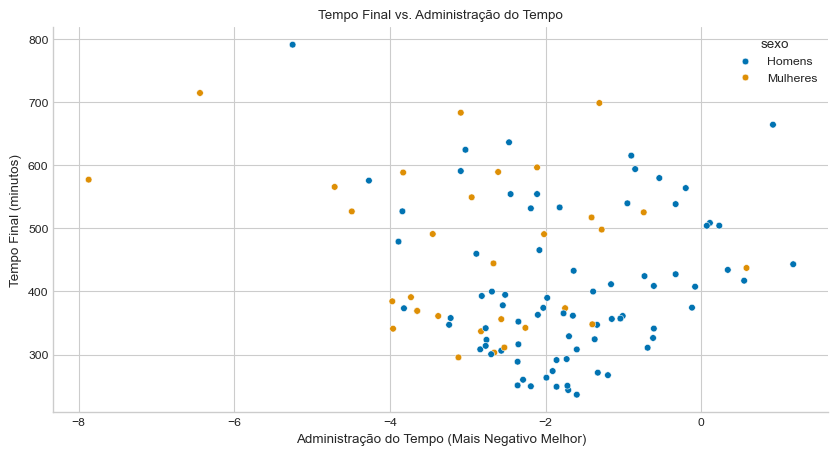

In [65]:
sns.scatterplot(
    data=df_final_completo,
    x="Diferenca_Media_Seg_Menos_Pri",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administra√ß√£o do Tempo")
plt.xlabel("Administra√ß√£o do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

A vari√°vel "Administra√ß√£o do Tempo" n√£o tem uma correla√ß√£o linear simples com o tempo final, mas ela atua como um fator qualificador ou limitante para o alto desempenho.

- Necess√°rio, mas n√£o Suficiente: Para conseguir um tempo final de elite nesta prova, √© necess√°rio que o atleta execute a prova dentro de uma faixa √≥tima de gest√£o de ritmo (neste caso, entre -4 e -1 min/km de diferen√ßa). Estar nessa faixa n√£o garante um bom tempo (voc√™ ainda precisa ser um atleta r√°pido), mas estar fora dela praticamente garantiza que voc√™ n√£o ter√° um tempo de elite.

- Indicador de Quebra: Valores muito negativos (<-5) ou positivos (>0) n√£o s√£o indicativos de uma "estrat√©gia diferente", mas sim de uma prov√°vel quebra de ritmo. O atleta com split de -7 provavelmente caminhou muito na primeira metade (gastando tempo) e por isso teve uma grande margem para "acelerar" na segunda. O atleta com split positivo provavelmente se esgotou completamente nas subidas e n√£o conseguiu se recuperar.

#### Criando fator de "Quebra"

- Vimos que a Diferenca_Seg_Menos_Pri √© √∫til, mas uma queda de 60 segundos no ritmo √© muito mais significativa para um atleta de elite (que corre a 300 seg/km) do que para um iniciante (que corre a 900 seg/km). Normalizar essa diferen√ßa pelo ritmo do pr√≥prio atleta nos d√° uma medida relativa do cansa√ßo.

In [66]:
df_final_completo["diff_relativa_segunda_primeira_parte"] = (
    (
        df_final_completo["Ritmo_Medio_Segunda_Metade"]
        - df_final_completo["Ritmo_Medio_Primeira_Metade"]
    )
    / df_final_completo["Ritmo_Medio_Primeira_Metade"]
).round(2)
df_final_completo.head()

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76                                 -0.19
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947                   942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66                                 -0.12
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47                                 -0.01
3          Alex Junior Aj  Homens      20 a 24  65 a 74 kg         2022            18496       513.777778               261.647539                   2787.0                  -2790.0       308.266667         8.562963                     4.360792                   598.944444                  428.611111                        10781                        7715                             9.98                            7.14                           179.68                          128.58                          -2.84                         -51.10                                 -0.28
4      Alexandre Santiago  Homens      35 a 44  55 a 64 kg         2022            14626       417.885714               195.390826                   2779.0                  -2781.0       243.766667         6.964762                     3.256514                   467.722222                  365.117647                         8419                        6207                             7.80                            6.09                           140.32                          103.45                          -1.71                         -36.87                                 -0.22

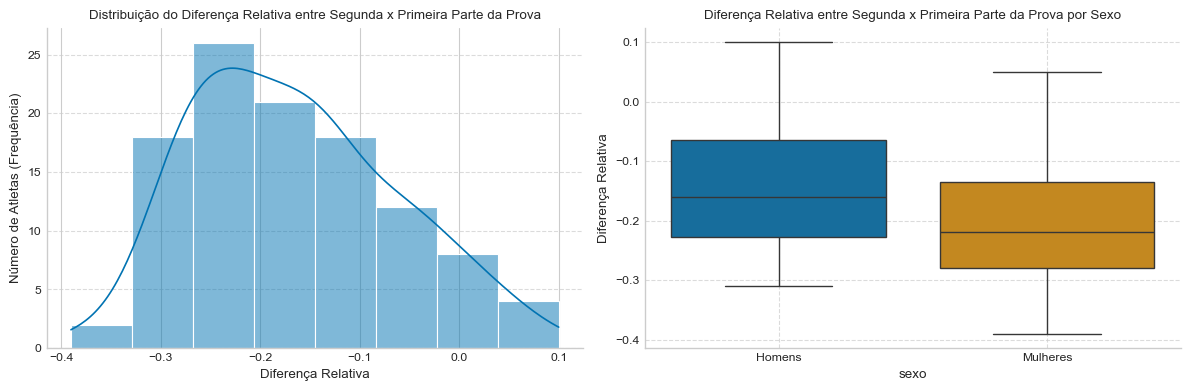

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(
    data=df_final_completo,
    x="diff_relativa_segunda_primeira_parte",
    kde=True,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title(
    "Distribui√ß√£o do Diferen√ßa Relativa entre Segunda x Primeira Parte da Prova"
)
axes[0].set_xlabel("Diferen√ßa Relativa")  # Adicionando r√≥tulo ao eixo x
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.boxplot(
    data=df_final_completo,
    x="sexo",
    y="diff_relativa_segunda_primeira_parte",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Diferen√ßa Relativa entre Segunda x Primeira Parte da Prova por Sexo")
axes[1].set_ylabel("Diferen√ßa Relativa")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

In [68]:
df_final_completo["diff_relativa_segunda_primeira_parte"].describe().round(2)

count    109.00
mean      -0.17
std        0.10
min       -0.39
25%       -0.25
50%       -0.17
75%       -0.09
max        0.10
Name: diff_relativa_segunda_primeira_parte, dtype: float64

**√â not√°vel que a grande maioria dos atletas (mais de 75%) conseguiu correr a segunda metade mais r√°pido.**

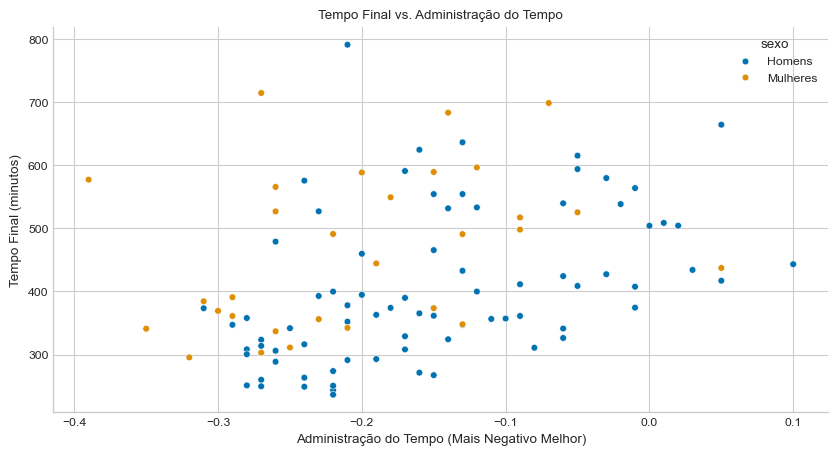

In [69]:
sns.scatterplot(
    data=df_final_completo,
    x="diff_relativa_segunda_primeira_parte",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administra√ß√£o do Tempo")
plt.xlabel("Administra√ß√£o do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

O perfil da prova, com a primeira metade focada em subidas e a segunda em descidas, √© o fator que define o desempenho.

- Regra da Prova: Acelerar na segunda metade n√£o √© uma estrat√©gia, √© uma consequ√™ncia do percurso. Em m√©dia, os atletas foram 17% mais r√°pidos na segunda metade (m√©dia de -0.17), como mostra a distribui√ß√£o normal no histograma.

- Fator de Sucesso: O gr√°fico de dispers√£o confirma que os atletas com os melhores tempos finais foram aqueles que mais conseguiram capitalizar nas descidas da segunda metade, ou seja, tiveram o √≠ndice mais negativo.

In [70]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_final_completo.groupby("sexo").agg(
    {
        "diff_relativa_segunda_primeira_parte": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Fator Quebra ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Fator Quebra ---
         diff_relativa_segunda_primeira_parte                        
                                         mean  std   min median   max
sexo                                                                 
Homens                                  -0.15  0.1 -0.31  -0.16  0.10
Mulheres                                -0.21  0.1 -0.39  -0.22  0.05


Mesmo compondo apenas 30% da amostra, os dados das mulheres mostram um desempenho relativo superior na din√¢mica da prova.

Desempenho M√©dio: As mulheres foram, em m√©dia, mais eficientes na segunda parte da prova. O √≠ndice delas foi de -0.21 (-21%), consideravelmente mais negativo que o dos homens, de -0.15 (-15%).

- Consist√™ncia: Os homens apresentaram os maiores casos de "quebra", com alguns chegando a ser 10% mais lentos na segunda parte da prova. As mulheres foram mais consistentes, com a maior queda de ritmo sendo de apenas 5%.

- Conclus√£o Direta: A prova exige a habilidade de subir na primeira metade e descer bem na segunda. A an√°lise sugere que, embora os homens representem 70% dos dados, as mulheres, como grupo, foram relativamente mais eficientes em converter a segunda parte da prova em um ganho de velocidade percentual em rela√ß√£o √† sua performance na primeira parte da prova.

**Conclus√£o**: A prova exige a habilidade de subir na primeira metade e descer bem na segunda. A an√°lise sugere que, embora os homens representem 70% dos dados, as mulheres, como grupo, foram relativamente mais eficientes em converter a se√ß√£o de descida em um ganho de velocidade percentual em rela√ß√£o √† sua performance na subida.

#### An√°lise Inclina√ß√£o da Prova

##### An√°lise Subida vs Descida

In [71]:
df_sobe_desc = df_completo.copy()
df_sobe_desc["Diff_Sob_Desc"] = (
    df_sobe_desc["desnivel_positivo"] + df_sobe_desc["desnivel_negativo"]
)
df_sobe_desc["percent_inclin_subida"] = df_sobe_desc["desnivel_positivo"] / 1000 * 100
df_sobe_desc["percent_inclin_descida"] = df_sobe_desc["desnivel_negativo"] / 1000 * 100
df_sobe_desc["perc_diff"] = (
    df_sobe_desc["desnivel_positivo"] / abs(df_sobe_desc["desnivel_negativo"]) - 1
)
df_sobe_desc.head()

Nome Atleta    sexo faixa_etaria           peso   ano  km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo  Diff_Sob_Desc  percent_inclin_subida  percent_inclin_descida  perc_diff
0  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       1.0               285             2023               13.0               -9.0            4.0                    1.3                    -0.9   0.444444
1  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       2.0               298             2023               88.0                0.0           88.0                    8.8                     0.0        inf
2  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       3.0               295             2023               58.0                0.0           58.0                    5.8                     0.0        inf
3  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       4.0               363             2023               46.0              -81.0          -35.0                    4.6                    -8.1  -0.432099
4  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       5.0               357             2023               41.0              -58.0          -17.0                    4.1                    -5.8  -0.293103

In [72]:
def Sob_Desc(diff, desnivel_positivo_km, desnivel_negativo_km):
    if desnivel_positivo_km < 20 and desnivel_negativo_km > -20:
        return "PLANO"
    elif diff >= -0.5 and diff <= 0.5:
        return "MISTO"
    elif diff < -0.5:
        return "DESCIDA"
    else:
        return "SUBIDA"


# Aplicando a fun√ß√£o ao DataFrame
df_sobe_desc["Sob_Desc"] = df_sobe_desc[
    ["perc_diff", "desnivel_positivo", "desnivel_negativo"]
].apply(lambda x: Sob_Desc(x[0], x[1], x[2]), axis=1)
df_sobe_desc.head(10)

C:\Users\Home\AppData\Local\Temp\ipykernel_3328\3829612325.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ].apply(lambda x: Sob_Desc(x[0], x[1], x[2]), axis=1)


Nome Atleta    sexo faixa_etaria           peso   ano  km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo  Diff_Sob_Desc  percent_inclin_subida  percent_inclin_descida  perc_diff Sob_Desc
0  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       1.0               285             2023               13.0               -9.0            4.0                    1.3                    -0.9   0.444444    PLANO
1  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       2.0               298             2023               88.0                0.0           88.0                    8.8                     0.0        inf   SUBIDA
2  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       3.0               295             2023               58.0                0.0           58.0                    5.8                     0.0        inf   SUBIDA
3  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       4.0               363             2023               46.0              -81.0          -35.0                    4.6                    -8.1  -0.432099    MISTO
4  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       5.0               357             2023               41.0              -58.0          -17.0                    4.1                    -5.8  -0.293103    MISTO
5  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       6.0               670             2023              128.0              -11.0          117.0                   12.8                    -1.1  10.636364   SUBIDA
6  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       7.0               258             2023              228.0               -7.0          221.0                   22.8                    -0.7  31.571429   SUBIDA
7  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       8.0               211             2023                1.0             -243.0         -242.0                    0.1                   -24.3  -0.995885  DESCIDA
8  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       9.0               338             2023                1.0             -122.0         -121.0                    0.1                   -12.2  -0.991803  DESCIDA
9  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023      10.0               544             2023                9.0              -69.0          -60.0                    0.9                    -6.9  -0.869565  DESCIDA

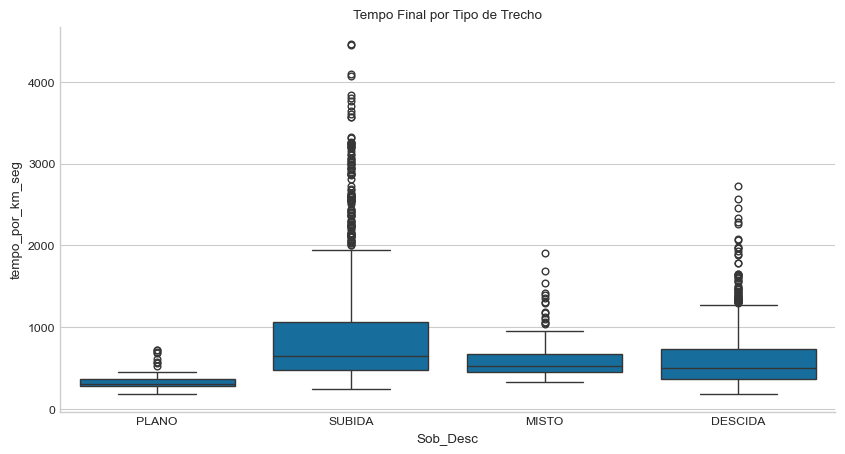

In [73]:
sns.boxplot(
    data=df_sobe_desc[df_sobe_desc["tempo_por_km_seg"] > 180],
    x="Sob_Desc",
    y="tempo_por_km_seg",
)
plt.title("Tempo Final por Tipo de Trecho")
plt.show()

In [74]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = (
    df_sobe_desc[df_sobe_desc["tempo_por_km_seg"] > 180]
    .groupby("Sob_Desc")
    .agg(
        {
            "tempo_por_km_seg": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Tipo Inclina√ß√£o ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Tipo Inclina√ß√£o ---
                             mean     std  min  median   max
Sob_Desc                                                    
DESCIDA  tempo_por_km_seg  592.08  316.43  183   504.0  2722
MISTO    tempo_por_km_seg  600.45  245.19  331   529.5  1908
PLANO    tempo_por_km_seg  331.29   92.40  188   311.0   724
SUBIDA   tempo_por_km_seg  869.99  613.09  246   652.0  4463


C:\Users\Home\AppData\Local\Temp\ipykernel_3328\557169805.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


- PLANO

Ritmo mais r√°pido de todos os trechos.

Maior consist√™ncia: Quase todos os atletas correm em um ritmo parecido.

- SUBIDA

Ritmo mais lento de forma disparada.

Maior varia√ß√£o de performance: √â o trecho que mais diferencia os atletas. Onde a prova √© "ganha" ou "perdida".

- MISTO

Ritmo intermedi√°rio, mais r√°pido que as subidas.

Quebra de ritmo: Terreno ondulado que exige varia√ß√£o constante de esfor√ßo.

- DESCIDA

Ritmo mais r√°pido que subidas, mas mais lento que o plano.

Exige t√©cnica: A varia√ß√£o nos tempos mostra que a dificuldade do terreno e a habilidade do atleta s√£o cruciais.

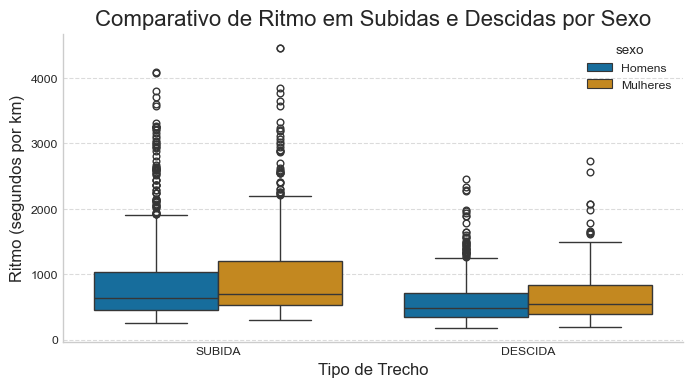

In [75]:
categorias_desejadas = ["SUBIDA", "DESCIDA"]
df_filtrado = df_sobe_desc[
    (df_sobe_desc["Sob_Desc"].isin(categorias_desejadas))
    & (df_sobe_desc["tempo_por_km_seg"] > 180)
]

# 2. Criar o gr√°fico
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualiza√ß√£o
sns.boxplot(
    data=df_filtrado,
    x="Sob_Desc",  # No eixo X, as categorias 'SUBIDA' e 'DESCIDA'
    y="tempo_por_km_seg",  # No eixo Y, o ritmo
    hue="sexo",  # O 'hue' separa os dados por sexo
)

# Adicionar t√≠tulos e formata√ß√£o
plt.title("Comparativo de Ritmo em Subidas e Descidas por Sexo", fontsize=16)
plt.xlabel("Tipo de Trecho", fontsize=12)
plt.ylabel("Ritmo (segundos por km)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [76]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_filtrado.groupby(["sexo", "Sob_Desc"]).agg(
    {
        "tempo_por_km_seg": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Subida/Descida e sexo ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Subida/Descida e sexo ---
                  tempo_por_km_seg                          
                              mean     std  min median   max
sexo     Sob_Desc                                           
Homens   DESCIDA            573.13  303.74  183  487.0  2453
         SUBIDA             831.87  580.91  246  628.0  4096
Mulheres DESCIDA            639.78  342.05  189  537.0  2722
         SUBIDA             965.91  678.61  293  697.0  4463


**Desempenho Absoluto**: Homens s√£o Mais R√°pidos em Ambos os Terrenos

- Tanto na **m√©dia** (*mean*) quanto na **mediana** (*median*), os homens apresentam um ritmo (tempo por km) inferior ao das mulheres.

- Na **Subida**: A mediana dos homens foi de 628 seg/km (~10:28 min/km), enquanto a das mulheres foi de 697 seg/km (~11:37 min/km).

- Na **Descida**: A mediana dos homens foi de 487 seg/km (~8:07 min/km), enquanto a das mulheres foi de 537 seg/km (~8:57 min/km).

- **Conclus√£o**: Em velocidade pura, os homens lideram em ambos os tipos de terreno.

**Variabilidade e Outliers**

- O gr√°fico mostra uma quantidade enorme de outliers (pontos circulares), especialmente nas subidas. Isso √© t√≠pico em corridas de montanha, onde trechos espec√≠ficos podem causar uma grande varia√ß√£o de ritmo (caminhada, dificuldades t√©cnicas, etc.).

- A variabilidade, medida pelo desvio padr√£o (std), √© muito alta para todos os grupos, mas ligeiramente maior para as mulheres, tanto na subida quanto na descida, indicando um grupo com desempenho um pouco mais heterog√™neo.

**Conclus√£o: A Diferen√ßa Crucial entre Desempenho Absoluto e Relativo**
A an√°lise do ritmo absoluto, que compara diretamente os segundos por quil√¥metro, estabelece um fato claro: os homens, como grupo, foram em m√©dia mais r√°pidos que as mulheres tanto nos trechos de subida quanto nos de descida. No entanto, essa vis√£o n√£o conta a hist√≥ria completa da performance e da estrat√©gia na prova.

Para entender a din√¢mica de como cada grupo aproveitou os diferentes terrenos, precisamos revisitar a an√°lise de desempenho relativo, que foi o ponto de partida de nosso estudo quando comparamos a *primeira* e a *segunda* metade da prova. Naquela an√°lise inicial, hav√≠amos identificado que as mulheres apresentavam uma melhora percentual de ritmo mais significativa, um insight que agora podemos confirmar com os dados mais precisos de subida e descida.

Para quantificar essa "efici√™ncia na transi√ß√£o" do terreno desfavor√°vel para o favor√°vel, calculamos a melhora relativa no ritmo de cada grupo usando a seguinte f√≥rmula:

> $$ \text{√çndice de Acelera√ß√£o } (\%) = \left( \frac{\text{Ritmo M√©dio na Descida} - \text{Ritmo M√©dio na Subida}}{\text{Ritmo M√©dio na Subida}} \right) \times 100 $$

Aplicando os valores m√©dios que encontramos, os resultados revelam uma nuance fundamental no desempenho:

>> Melhora Relativa dos Homens: (573.13 - 831.87) / 831.87 = -31.1%

>> Melhora Relativa das Mulheres: (639.78 - 965.91) / 965.91 = -33.8%

- Esses n√∫meros confirmam que, embora n√£o sejam mais r√°pidas em termos absolutos, as mulheres, como grupo, capitalizaram nas descidas de forma mais eficaz em rela√ß√£o ao seu pr√≥prio ritmo de subida. A acelera√ß√£o relativa delas foi superior √† dos homens.

Portanto, a conclus√£o final √© dupla: enquanto os homens foram dominantes em velocidade pura, a an√°lise relativa exp√µe que as mulheres demonstraram uma maior capacidade de maximizar seu ganho de velocidade nos trechos de descida, validando o padr√£o que hav√≠amos observado inicialmente e adicionando uma camada mais profunda de entendimento sobre as diferentes estrat√©gias de performance entre os sexos nesta prova.

##### Indice Diferen√ßa relativa entre Subida e Descida no Tempo m√©dio

In [77]:
df_sobe_desc.head(3)

Nome Atleta    sexo faixa_etaria           peso   ano  km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo  Diff_Sob_Desc  percent_inclin_subida  percent_inclin_descida  perc_diff Sob_Desc
0  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       1.0               285             2023               13.0               -9.0            4.0                    1.3                    -0.9   0.444444    PLANO
1  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       2.0               298             2023               88.0                0.0           88.0                    8.8                     0.0        inf   SUBIDA
2  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       3.0               295             2023               58.0                0.0           58.0                    5.8                     0.0        inf   SUBIDA

In [78]:
ritmo_por_nivel = df_sobe_desc.groupby(["Nome Atleta", "Sob_Desc"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)

# --- PASSO 2: Pivotar a tabela (unstack) ---
# Isso transforma as linhas de 'Sob_Desc' (PLANO, SUBIDA, etc.) em colunas.
# .fillna(0) √© importante para atletas que talvez n√£o tenham passado por um tipo de terreno.
comparativo_niveis = ritmo_por_nivel.unstack().fillna(0)


# --- PASSO 3: Achatar e renomear as colunas (mesma l√≥gica de antes) ---
multi_level_columns_nivel = comparativo_niveis.columns
# Adaptamos a l√≥gica para os n√≠veis de inclina√ß√£o
novos_nomes_colunas_nivel = [
    f"Ritmo_Medio_{nivel}" if metrica == "tempo_por_km_seg" else f"Tempo_Total_{nivel}"
    for metrica, nivel in multi_level_columns_nivel
]
comparativo_niveis.columns = novos_nomes_colunas_nivel


# --- PASSO 4: Converter as novas colunas de segundos para minutos ---
# A lista de colunas √© gerada dinamicamente
colunas_em_segundos_nivel = novos_nomes_colunas_nivel

for coluna in colunas_em_segundos_nivel:
    nova_coluna_min = coluna + "_min"
    comparativo_niveis[nova_coluna_min] = (comparativo_niveis[coluna] / 60).round(2)

comparativo_niveis = comparativo_niveis.reset_index()

Juntando as tabelas

In [79]:
df_final_completo.head(1)

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte
0  ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0            362.9        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                           -2.1                         -37.76                                 -0.19

In [80]:
df_final_nivel_inclinacao = pd.merge(
    left=df_final_completo,
    right=comparativo_niveis,
    on="Nome Atleta",
    how="left",
)

# Exibindo o resultado final
print("Tabela final com a an√°lise por n√≠vel de inclina√ß√£o:")
df_final_nivel_inclinacao.head(5)

Tabela final com a an√°lise por n√≠vel de inclina√ß√£o:


Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  Ritmo_Medio_DESCIDA_min  Ritmo_Medio_MISTO_min  Ritmo_Medio_PLANO_min  Ritmo_Medio_SUBIDA_min  Tempo_Total_DESCIDA_min  Tempo_Total_MISTO_min  Tempo_Total_PLANO_min  Tempo_Total_SUBIDA_min
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76                                 -0.19           522.933333              474.5              335.5          724.117647                 7844                949                671               12310                     8.72                   7.91                   5.59                   12.07                   130.73                  15.82                  11.18                  205.17
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947                   942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66                                 -0.12           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583                    13.17                  12.37                   8.92                   17.24                   197.48                  24.73                  17.83                  293.05
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47                                 -0.01           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729                    12.42                  10.47                   5.52                   20.32                   186.32                  20.93                  11.03                  345.48
3          Alex Junior Aj  Homens      20 a 24  65 a 74 kg         2022            18496       513.777778               261.647539                   2787.0                  -2790.0       308.266667         8.562963                     4.360792                   598.944

Criando Indice que compara:
- *Tempo M√©dio Subida* x *Tempo M√©dio Descida*
- *Tempo M√©dio Subida* x *Tempo M√©dio Total Prova*
- *Tempo M√©dio Descida* x *Tempo M√©dio Total Prova*

In [81]:
df_final_nivel_inclinacao["indice_subida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_seg"]
) / df_final_nivel_inclinacao["Ritmo_Medio_seg"]
df_final_nivel_inclinacao["indice_descida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_DESCIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_seg"]
) / df_final_nivel_inclinacao["Ritmo_Medio_seg"]
df_final_nivel_inclinacao["indice_descida_vs_subida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_DESCIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]
) / df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]

df_final_nivel_inclinacao.head(5)

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  Ritmo_Medio_DESCIDA_min  Ritmo_Medio_MISTO_min  Ritmo_Medio_PLANO_min  Ritmo_Medio_SUBIDA_min  Tempo_Total_DESCIDA_min  Tempo_Total_MISTO_min  Tempo_Total_PLANO_min  Tempo_Total_SUBIDA_min  indice_subida  indice_descida  indice_descida_vs_subida
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76                                 -0.19           522.933333              474.5              335.5          724.117647                 7844                949                671               12310                     8.72                   7.91                   5.59                   12.07                   130.73                  15.82                  11.18                  205.17       0.197218       -0.135409                 -0.277834
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947                   942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66                                 -0.12           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583                    13.17                  12.37                   8.92                   17.24                   197.48                  24.73                  17.83                  293.05       0.164090       -0.110936                 -0.236259
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47                                 -0.01           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729                    12.42                  10.47                   5.52                   20.32                   186.32                  20.93                  11.03                  345.48       0.297721       -0.206835                 -0.388802
3          Alex Junior Aj  Homens      20

##### Indice do Ritmo Subida vs Ritmo m√©dio Geral da prova
''
O √≠ndice criado`(Ritmo Subida - Ritmo Geral) / Ritmo Geral` √© uma √≥tima forma de medir a **especializa√ß√£o** de um atleta. Ele responde √† pergunta: 

"*O qu√£o mais lento um atleta √© na subida em compara√ß√£o com seu pr√≥prio desempenho m√©dio geral?*"
>
> - Um √≠ndice **baixo** indica um *bom escalador* (seu ritmo na subida √© pr√≥ximo do seu ritmo geral).
> - Um √≠ndice **alto** indica um atleta que *perde mais tempo* nas subidas em rela√ß√£o √† sua m√©dia, precisando compensar nas descidas ou planos.


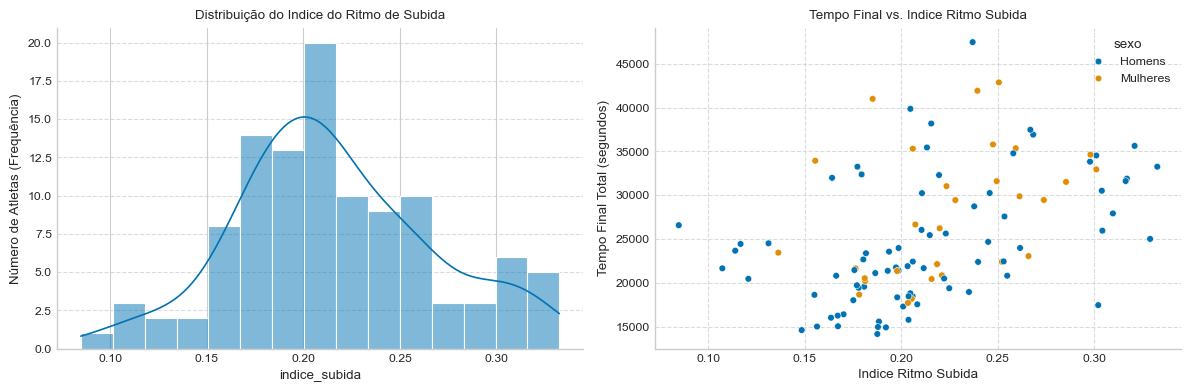

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Indice do Ritmo de Subida")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Subida")
axes[1].set_xlabel("Indice Ritmo Subida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [83]:
df_final_nivel_inclinacao["indice_subida"].describe().round(2)

count    109.00
mean       0.22
std        0.05
min        0.08
25%        0.18
50%        0.21
75%        0.25
max        0.33
Name: indice_subida, dtype: float64

1. **Histograma:**
   - Este gr√°fico mostra a distribui√ß√£o do seu "√çndice de Subida". Vemos que a maioria dos atletas se concentra na faixa de **0.15 a 0.25**.
   - **Tradu√ß√£o:** O perfil mais comum de atleta nesta prova √© aquele cujo ritmo de subida √© entre **15% e 25% mais lento** que seu ritmo m√©dio geral. Atletas com √≠ndice abaixo de 0.15 (bons escaladores) s√£o menos comuns, assim como atletas com √≠ndice acima de 0.25 (que perdem mais tempo na subida). A distribui√ß√£o √© aproximadamente normal, o que √© esperado.

2. **Gr√°fico de Dispers√£o:**
   - > Este √© o gr√°fico mais revelador. Ele mostra uma **clara correla√ß√£o positiva** entre o "√çndice de Subida" e o "Tempo Final".
   - **Tradu√ß√£o:** Quanto **maior** o √≠ndice de um atleta (ou seja, quanto pior for seu desempenho nas subidas em rela√ß√£o √† sua m√©dia), **maior** (pior) ser√° seu tempo final de prova.
   - **Conclus√£o:** Isso confirma de maneira visual e direta que **ser um bom escalador √© um fator decisivo para um bom resultado nesta prova**. Os atletas que conseguem manter seu ritmo de subida mais pr√≥ximo de seu ritmo geral (lado esquerdo do gr√°fico) s√£o os que terminam a corrida mais r√°pido.

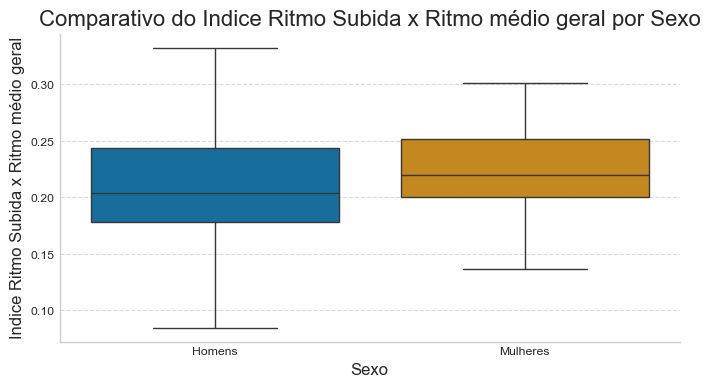

In [84]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualiza√ß√£o
sns.boxplot(data=df_final_nivel_inclinacao, x="sexo", y="indice_subida", hue="sexo")

# Adicionar t√≠tulos e formata√ß√£o
plt.title(
    "Comparativo do Indice Ritmo Subida x Ritmo m√©dio geral por Sexo", fontsize=16
)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Indice Ritmo Subida x Ritmo m√©dio geral", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [85]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print(
    "--- Resumo Estat√≠stico Detalhado por Indice Ritmo Subida x Ritmo m√©dio geral e sexo ---"
)
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Indice Ritmo Subida x Ritmo m√©dio geral e sexo ---
         indice_subida                         
                  mean   std   min median   max
sexo                                           
Homens            0.21  0.05  0.08   0.20  0.33
Mulheres          0.22  0.04  0.14   0.22  0.30


**Interpreta√ß√£o dos Resultados**

A principal conclus√£o deste gr√°fico √© a **not√°vel semelhan√ßa** entre os dois sexos quando normalizamos o desempenho na subida pelo ritmo geral de cada atleta.

- **Desempenho Relativo Quase Id√™ntico:**
  - Em m√©dia, o ritmo de subida dos **Homens** foi **21%** mais lento que o seu ritmo m√©dio geral (`mean: 0.21`).
  - Para as **Mulheres**, o ritmo de subida foi **22%** mais lento que o seu ritmo m√©dio geral (`mean: 0.22`).
  - As medianas (`0.20` para homens e `0.22` para mulheres) confirmam essa proximidade.

- **Conclus√£o:**
  > Apesar dos homens serem mais r√°pidos em termos *absolutos*, o "custo" de performance que as subidas imp√µem √© praticamente o mesmo para ambos os sexos. Proporcionalmente, homens e mulheres perdem uma quantidade similar de ritmo nos trechos de escalada em rela√ß√£o ao que conseguem manter no restante da prova. Isso sugere que, em termos de perfil de atleta (*escalador vs. n√£o-escalador*), os dois grupos s√£o muito parecidos.

##### Indice do Ritmo Descida vs Ritmo m√©dio Geral da prova

O √≠ndice criado`(Ritmo Descida - Ritmo Geral) / Ritmo Geral` √© uma √≥tima forma de medir a **especializa√ß√£o** de um atleta. Ele responde √† pergunta: 

"*O qu√£o mais r√°pido um atleta √© na descida em compara√ß√£o com seu pr√≥prio desempenho m√©dio geral?*"
>
> - Um √≠ndice **alto** indica um *perde mais tempo* (seu ritmo na descida √© pr√≥ximo do seu ritmo geral).
> - Um √≠ndice **baixo** indica o qu√£o o atleta √© *mais r√°pido* nas descida em rela√ß√£o √† sua m√©dia.


In [86]:
df_final_nivel_inclinacao.head()

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  Ritmo_Medio_DESCIDA_min  Ritmo_Medio_MISTO_min  Ritmo_Medio_PLANO_min  Ritmo_Medio_SUBIDA_min  Tempo_Total_DESCIDA_min  Tempo_Total_MISTO_min  Tempo_Total_PLANO_min  Tempo_Total_SUBIDA_min  indice_subida  indice_descida  indice_descida_vs_subida
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76                                 -0.19           522.933333              474.5              335.5          724.117647                 7844                949                671               12310                     8.72                   7.91                   5.59                   12.07                   130.73                  15.82                  11.18                  205.17       0.197218       -0.135409                 -0.277834
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947                   942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66                                 -0.12           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583                    13.17                  12.37                   8.92                   17.24                   197.48                  24.73                  17.83                  293.05       0.164090       -0.110936                 -0.236259
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47                                 -0.01           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729                    12.42                  10.47                   5.52                   20.32                   186.32                  20.93                  11.03                  345.48       0.297721       -0.206835                 -0.388802
3          Alex Junior Aj  Homens      20

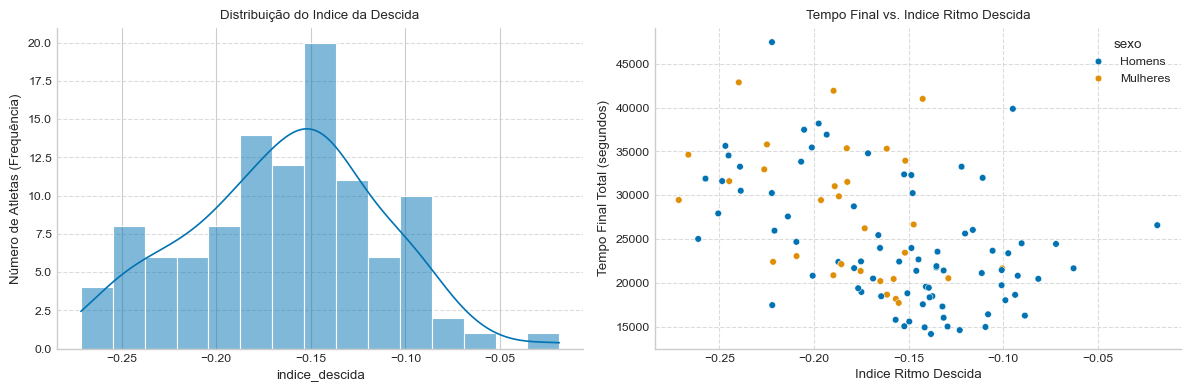

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Indice da Descida")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Descida")
axes[1].set_xlabel("Indice Ritmo Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [88]:
df_final_nivel_inclinacao["indice_descida"].describe().round(2)

count    109.00
mean      -0.16
std        0.05
min       -0.27
25%       -0.20
50%       -0.16
75%       -0.13
max       -0.02
Name: indice_descida, dtype: float64

**Interpreta√ß√£o do √çndice de Descida**

1. **Histograma e Estat√≠sticas Descritivas:**
    - A an√°lise confirma que o atleta m√©dio tem um ritmo de descida **16% mais r√°pido** que seu ritmo m√©dio geral (`mean: -0.16`). A distribui√ß√£o √© bastante normal e sim√©trica, como mostra o histograma.
    - O perfil do atleta t√≠pico nesta prova √© muito consistente: a maioria (o miolo de 50% do campo, entre os quartis de 25% e 75%) tem um ritmo de descida entre **13% e 20%** mais r√°pido que sua m√©dia geral.
    - √â interessante notar que o "pior" descensor (`max: -0.02`) ainda foi 2% mais r√°pido que sua pr√≥pria m√©dia, confirmando a natureza veloz da segunda metade da prova para todos.

2. **Gr√°fico de Dispers√£o (Tempo Final vs. √çndice de Descida):**
    - O gr√°fico mostra uma correla√ß√£o negativa clara: √† medida que o √≠ndice vai da esquerda para a direita (de mais negativo para menos negativo), o tempo final tende a descer. Ou seja, quanto maior o indice da descida (mais lento em rela√ß√£o ao ritmo m√©dio geral) menor tempo final.


In [89]:
correlacoes = df_final_nivel_inclinacao[["Tempo_Final_seg", "indice_descida"]].corr()

print(correlacoes)

                 Tempo_Final_seg  indice_descida
Tempo_Final_seg         1.000000       -0.457405
indice_descida         -0.457405        1.000000



Para interpretar o gr√°fico e a correl√ßa√µ,vamos dividir em tr√™s partes: o sinal, a magnitude e o que isso significa no contexto da prova.

1.  **O Sinal (`-`):**
    - Um sinal negativo indica uma **correla√ß√£o inversa**. Isso significa que, √† medida que uma vari√°vel **aumenta**, a outra tende a **diminuir**.
    - No nosso caso: √Ä medida que o `√çndice de Descida` **aumenta** (ou seja, fica *menos negativo*, indo de -0.25 em dire√ß√£o a 0), o `Tempo Final` tende a **diminuir** (ficar mais r√°pido).

2.  **A Magnitude (`0.457`):**
    - O valor de 0.457, em valor absoluto, √© considerado uma **correla√ß√£o moderada**. N√£o √© fraca, mas tamb√©m n√£o √© forte como a que vimos para a subida. A rela√ß√£o existe e √© estatisticamente relevante, mas n√£o √© t√£o direta e preditiva.

3.  **A Conclus√£o (O "O que quer dizer?"):**
    > Juntando o sinal e a magnitude, o resultado √© surpreendente e nos diz algo novo sobre a estrat√©gia da prova:
    >
    > Surpreendentemente, atletas que s√£o **especialistas extremos** em descida (com um √≠ndice muito negativo, no lado esquerdo do gr√°fico) **n√£o foram necessariamente os mais r√°pidos no geral**. A correla√ß√£o sugere que os atletas com um perfil mais **equilibrado** ‚Äî cujo ritmo de descida √© r√°pido, mas n√£o *extremamente* discrepante de sua m√©dia geral ‚Äî tenderam a ter os melhores tempos.
    >
    > **Por que isso faria sentido?** Uma hip√≥tese √© que um atleta com um √≠ndice de descida extremo pode ser um escalador muito fraco, perdendo muito mais tempo na subida do que consegue compensar na descida. O resultado favorece o atleta mais completo, e n√£o o especialista em apenas um terreno.
    >
    > **Resumindo:** Ser um bom descensor ajuda, mas ser *demasiado* especialista nisso (em detrimento de outras habilidades, como a subida) parece n√£o ser a estrat√©gia vencedora nesta prova. Isso refor√ßa nossa conclus√£o anterior de que a **subida √© o fator mais decisivo**.

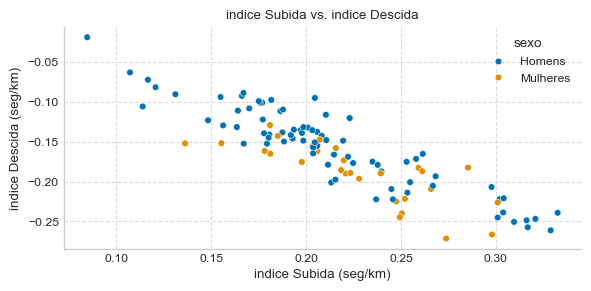

In [90]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
    data=df_final_nivel_inclinacao, x="indice_subida", y="indice_descida", hue="sexo"
)
plt.title("indice Subida vs. indice Descida")
plt.ylabel("indice Descida (seg/km)")
plt.xlabel("indice Subida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

Estamos vendo um comportamento real dos atletas ou um artefato matem√°tico?

A resposta √©: **provavelmente os dois, e seu gr√°fico comprova isso brilhantemente.**

Vamos por partes.



1.  Esse gr√°fico mostra uma clara **correla√ß√£o negativa**: atletas que s√£o escaladores piores (mais √† direita no eixo X, com `√≠ndice Subida` alto) tendem a ser descensores melhores (mais para baixo no eixo Y, com `√≠ndice Descida` bem negativo). A "nuvem" de pontos vai claramente do canto superior esquerdo para o inferior direito.

2.  Podemos observar que h√°, de fato, um **efeito matem√°tico parcial**: um atleta muito lento na subida ter√° um ritmo m√©dio geral (`Ritmo_Medio_seg`) mais alto. Esse ritmo geral mais alto, quando usado como base de compara√ß√£o, far√° com que seu ritmo de descida pare√ßa percentualmente ainda melhor (mais negativo), mesmo que a velocidade absoluta da descida n√£o seja espetacular.
    - **Contudo, a tend√™ncia √© forte e clara demais para ser *apenas* matem√°tica.** O que o gr√°fico realmente revela s√£o os **perfis de atleta** e a estrat√©gia de **compensa√ß√£o**. Atletas que sabem que n√£o s√£o bons escaladores muitas vezes se poupam na subida para poderem "gastar tudo" na descida, onde t√™m mais habilidade t√©cnica ou confian√ßa.

A Conclus√£o da An√°lise

> Este gr√°fico √© a s√≠ntese perfeita de toda a nossa investiga√ß√£o. Ele mostra que o desempenho nesta prova n√£o √© linear; √© um jogo de **equil√≠brio e compensa√ß√£o**.
>
> - No **canto superior esquerdo**, temos os atletas mais *equilibrados*: s√£o bons escaladores (√≠ndice de subida baixo) e, consequentemente, n√£o precisam ser descensores extremos para obter um bom resultado.
> - No **canto inferior direito**, temos os *especialistas/compensadores*: s√£o atletas que perdem mais tempo na subida, mas compensam essa "fraqueza" sendo excelentes descensores, com uma melhora relativa de ritmo muito acentuada na descida.
>
> **Em resumo:** O gr√°fico confirma que existe um *trade-off* (uma troca) claro entre a performance de subida e de descida. Voc√™ validou com sucesso que atletas mais fracos na subida tendem a compensar com uma performance relativa superior na descida.

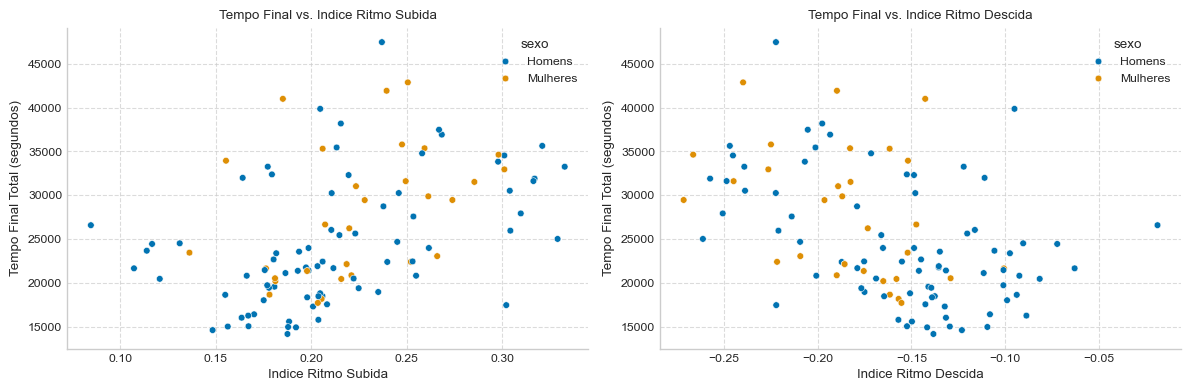

In [91]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Tempo Final vs. Indice Ritmo Subida")
axes[0].set_xlabel("Indice Ritmo Subida")
axes[0].set_ylabel("Tempo Final Total (segundos)")
axes[0].grid(linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Descida")
axes[1].set_xlabel("Indice Ritmo Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [92]:
correlacoes = df_final_nivel_inclinacao[
    ["Tempo_Final_seg", "indice_subida", "indice_descida"]
].corr()

print(correlacoes)

                 Tempo_Final_seg  indice_subida  indice_descida
Tempo_Final_seg         1.000000       0.439045       -0.457405
indice_subida           0.439045       1.000000       -0.884126
indice_descida         -0.457405      -0.884126        1.000000


**Comparativo Final: Subida vs. Descida**

Agora podemos responder √† pergunta final da nossa an√°lise.

> Ambas as especializa√ß√µes, subida e descida, s√£o importantes para um bom resultado. No entanto, ao comparar visualmente o gr√°fico de dispers√£o do *√çndice de Subida* com este novo do *√çndice de Descida*, a nuvem de pontos para a descida parece um pouco mais dispersa.
>
> **Conclus√£o Geral:** A an√°lise sugere que, embora ser um bom descensor n√£o contribua para um tempo final mais r√°pido, ser um **escalador de elite (ou seja, n√£o perder muito tempo na subida em rela√ß√£o √† sua m√©dia) tem um impacto ainda mais decisivo no resultado final**. A subida parece atuar como o principal "filtro" de desempenho e o maior preditor de sucesso nesta competi√ß√£o.
> **Mas principalmente ser um atleta mais equilbrado entre subidas e descidas**

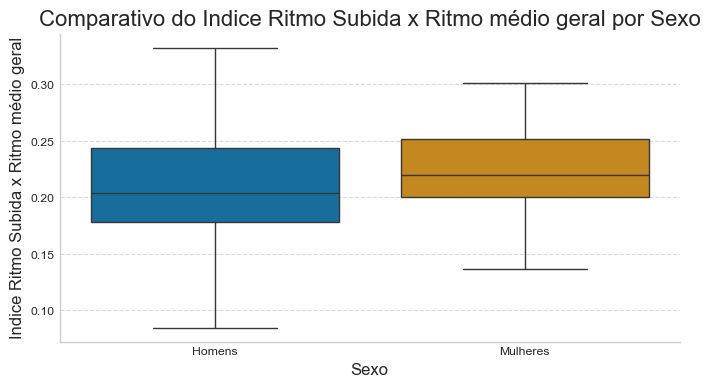

In [93]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualiza√ß√£o
sns.boxplot(data=df_final_nivel_inclinacao, x="sexo", y="indice_subida", hue="sexo")

# Adicionar t√≠tulos e formata√ß√£o
plt.title(
    "Comparativo do Indice Ritmo Subida x Ritmo m√©dio geral por Sexo", fontsize=16
)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Indice Ritmo Subida x Ritmo m√©dio geral", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [94]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print(
    "--- Resumo Estat√≠stico Detalhado por Indice Ritmo Subida x Ritmo m√©dio geral e sexo ---"
)
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Indice Ritmo Subida x Ritmo m√©dio geral e sexo ---
         indice_subida                         
                  mean   std   min median   max
sexo                                           
Homens            0.21  0.05  0.08   0.20  0.33
Mulheres          0.22  0.04  0.14   0.22  0.30


**Interpreta√ß√£o dos Resultados**

A principal conclus√£o deste gr√°fico √© a **not√°vel semelhan√ßa** entre os dois sexos quando normalizamos o desempenho na subida pelo ritmo geral de cada atleta.

- **Desempenho Relativo Quase Id√™ntico:**
  - Em m√©dia, o ritmo de subida dos **Homens** foi **21%** mais lento que o seu ritmo m√©dio geral (`mean: 0.21`).
  - Para as **Mulheres**, o ritmo de subida foi **22%** mais lento que o seu ritmo m√©dio geral (`mean: 0.22`).
  - As medianas (`0.20` para homens e `0.22` para mulheres) confirmam essa proximidade.

- **Conclus√£o:**
  > Apesar dos homens serem mais r√°pidos em termos *absolutos*, o "custo" de performance que as subidas imp√µem √© praticamente o mesmo para ambos os sexos. Proporcionalmente, homens e mulheres perdem uma quantidade similar de ritmo nos trechos de escalada em rela√ß√£o ao que conseguem manter no restante da prova. Isso sugere que, em termos de perfil de atleta (*escalador vs. n√£o-escalador*), os dois grupos s√£o muito parecidos.

##### Indice do Ritmo Descida vs Ritmo Subida

Este √≠ndice, que podemos chamar de **"√çndice de Acelera√ß√£o Relativa"**, √© a m√©trica mais direta para compararmos a performance de um atleta nos dois terrenos principais da prova. Ele responde √† pergunta:

"*Qual o ganho percentual de velocidade que um atleta obt√©m na descida em compara√ß√£o direta com seu desempenho na subida?*"
>
> - Um √≠ndice **mais alto** (pr√≥ximo de zero) indica um atleta mais *equilibrado*, com menor diferen√ßa de ritmo entre subida e descida.
> - Um √≠ndice **mais baixo** (mais negativo) indica um atleta *especialista/compensador*, com uma acelera√ß√£o muito maior na descida em rela√ß√£o √† sua subida.

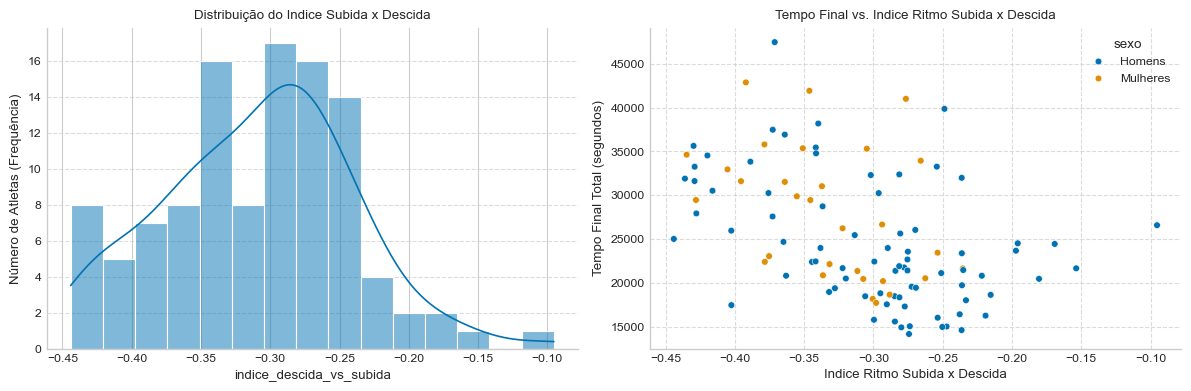

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida_vs_subida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribui√ß√£o do Indice Subida x Descida")
axes[0].set_ylabel("N√∫mero de Atletas (Frequ√™ncia)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida_vs_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Subida x Descida")
axes[1].set_xlabel("Indice Ritmo Subida x Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [96]:
df_final_nivel_inclinacao["indice_descida_vs_subida"].describe().round(2)

count    109.00
mean      -0.31
std        0.07
min       -0.44
25%       -0.36
50%       -0.30
75%       -0.27
max       -0.10
Name: indice_descida_vs_subida, dtype: float64

In [97]:
corr = df_final_nivel_inclinacao[["Tempo_Final_seg", "indice_descida_vs_subida"]].corr()
corr

Tempo_Final_seg  indice_descida_vs_subida
Tempo_Final_seg                  1.000000                 -0.455566
indice_descida_vs_subida        -0.455566                  1.000000

Estes gr√°ficos nos permitem consolidar a an√°lise e desenhar o perfil do atleta de maior sucesso nesta prova.

1.  **Distribui√ß√£o do √çndice (Gr√°fico da Esquerda):**
    - O histograma mostra a distribui√ß√£o do "√çndice de Acelera√ß√£o" (`Descida vs. Subida`). A maioria dos atletas se concentra em uma faixa de melhora relativa entre **-0.20 (20%) e -0.35 (35%)**.
    - Isso nos mostra o comportamento *t√≠pico* da prova: √© normal e esperado que um atleta seja de 20% a 35% mais r√°pido na descida. Perfis mais "equilibrados" (√≠ndice > -0.20) ou de "especialistas extremos" (√≠ndice < -0.35) s√£o menos comuns.

2.  **Rela√ß√£o com o Tempo Final (Gr√°fico da Direita):**
    - Este gr√°fico de dispers√£o √© a pe√ßa-chave. Ele n√£o mostra uma correla√ß√£o linear simples, indicando que a rela√ß√£o entre o √≠ndice e o sucesso n√£o √© "quanto mais, melhor".
    - A an√°lise visual revela o que podemos chamar de **"Faixa de Ouro"** do desempenho. Os atletas com os melhores tempos finais (pontos mais baixos no gr√°fico) n√£o est√£o espalhados aleatoriamente, mas sim concentrados em um intervalo espec√≠fico do √≠ndice, aproximadamente entre **-0.35 e -0.20**.

**Conclus√£o**

> A hip√≥tese de que o atleta mais "equilibrado" (com menor diferen√ßa entre ritmos) seria o mais r√°pido n√£o se confirma. Na verdade, ser *pouco* agressivo na descida est√° associado a tempos finais mais lentos.
>
> Da mesma forma, ser um *especialista extremo* (com a maior acelera√ß√£o relativa poss√≠vel) tamb√©m n√£o garante o sucesso, sugerindo que isso vem ao custo de um desempenho muito fraco na subida, que √© irrecuper√°vel.
>
> **A conclus√£o final √© que o sucesso nesta prova reside em uma "especializa√ß√£o otimizada". Os atletas de elite s√£o aqueles que encontram o ponto ideal: eles aplicam uma acelera√ß√£o significativa e agressiva nas descidas (melhora de 20% a 35%), mas sem que essa estrat√©gia canibalize seu desempenho a ponto de criar um d√©ficit impag√°vel nas subidas.**

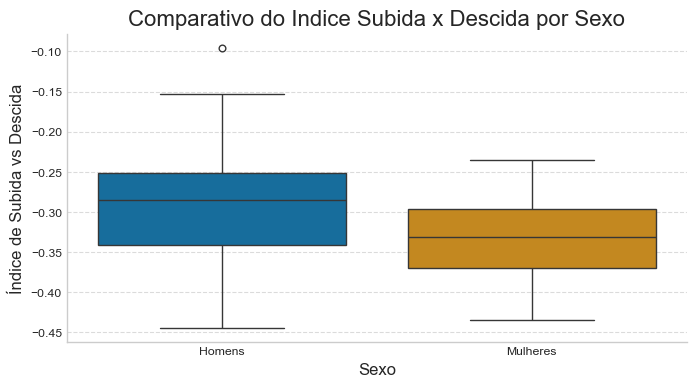

In [98]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualiza√ß√£o
sns.boxplot(
    data=df_final_nivel_inclinacao, x="sexo", y="indice_descida_vs_subida", hue="sexo"
)

# Adicionar t√≠tulos e formata√ß√£o
plt.title("Comparativo do Indice Subida x Descida por Sexo", fontsize=16)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("√çndice de Subida vs Descida", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [99]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_descida_vs_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Indice Subida/Descida e sexo ---")
print(resumo_completo.round(3))

--- Resumo Estat√≠stico Detalhado por Indice Subida/Descida e sexo ---
         indice_descida_vs_subida                            
                             mean    std    min median    max
sexo                                                         
Homens                     -0.300  0.072 -0.444 -0.285 -0.095
Mulheres                   -0.332  0.051 -0.435 -0.332 -0.235


**Interpreta√ß√£o dos Resultados**

Com a nova f√≥rmula, o √≠ndice agora representa o **ganho percentual de velocidade** (ou a *redu√ß√£o do pace*) da subida para a descida. Um n√∫mero mais negativo significa uma acelera√ß√£o relativa maior e, portanto, um desempenho relativo melhor.

1. **Desempenho Relativo Superior das Mulheres:**
    - O resultado √© inequ√≠voco. Tanto a m√©dia (`-0.332`) quanto a mediana (`-0.332`) das mulheres s√£o **mais negativas** que a m√©dia (`-0.300`) e a mediana (`-0.285`) dos homens.
    - **Tradu√ß√£o:** Em m√©dia, as mulheres foram **33.2% mais r√°pidas** nas descidas em rela√ß√£o √†s suas pr√≥prias subidas. Os homens, por sua vez, registraram uma melhora de **30.0%**.

2. **Consist√™ncia e Variabilidade:**
    - A an√°lise da dispers√£o dos dados revela um insight fundamental. O desvio padr√£o (`std`) do grupo feminino (`0.051`) √© consideravelmente **menor** que o do grupo masculino (`0.072`).
    - **Tradu√ß√£o:** O grupo feminino √© notavelmente **mais consistente e homog√™neo** nesta m√©trica. Em contrapartida, o grupo masculino √© mais heterog√™neo, com maior varia√ß√£o na habilidade de converter o ritmo de subida em um ritmo de descida eficiente.

**Conclus√£o Final**

> A cria√ß√£o e an√°lise desta vari√°vel final nos permite consolidar a principal descoberta da an√°lise comparativa de desempenho:
>
> Enquanto os homens s√£o, em termos *absolutos*, mais r√°pidos tanto nas subidas quanto nas descidas, a an√°lise de desempenho *relativo* revela que **as mulheres demonstram uma capacidade superior e mais consistente de acelerar nos trechos de descida** em rela√ß√£o ao seu pr√≥prio ritmo de subida.
>
> Este achado sugere diferentes perfis estrat√©gicos ou fisiol√≥gicos entre os sexos nesta prova, uma nuance que permaneceria oculta se analis√°ssemos apenas os tempos absolutos ou finais.

##### Avaliando o Ritmo m√©dio Subida Absoluto vs tempo final

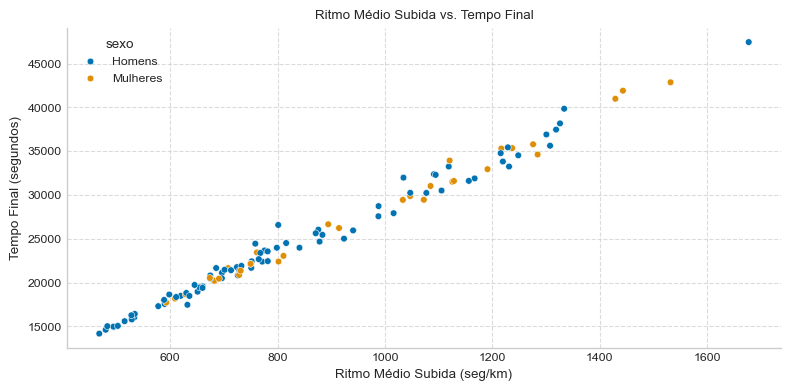

In [100]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="Ritmo_Medio_SUBIDA",
    y="Tempo_Final_seg",
    hue="sexo",
)
plt.title("Ritmo M√©dio Subida vs. Tempo Final")
plt.ylabel("Tempo Final (segundos)")
plt.xlabel("Ritmo M√©dio Subida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Avaliando o Ritmo m√©dio Descida Absoluto vs tempo final

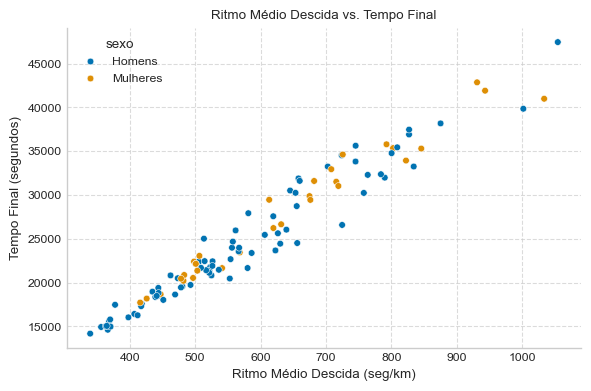

In [101]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="Ritmo_Medio_DESCIDA",
    y="Tempo_Final_seg",
    hue="sexo",
)
plt.title("Ritmo M√©dio Descida vs. Tempo Final")
plt.ylabel("Tempo Final (segundos)")
plt.xlabel("Ritmo M√©dio Descida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Corr Ritmos Subida/Descidas Abs x Tempo Prova

In [102]:
correlacoes = df_final_nivel_inclinacao[
    ["Tempo_Final_seg", "Ritmo_Medio_SUBIDA", "Ritmo_Medio_DESCIDA"]
].corr()

print(correlacoes)

                     Tempo_Final_seg  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
Tempo_Final_seg             1.000000            0.993332             0.973078
Ritmo_Medio_SUBIDA          0.993332            1.000000             0.944208
Ritmo_Medio_DESCIDA         0.973078            0.944208             1.000000


- A an√°lise mostra que tanto o ritmo m√©dio na **Subida** quanto na **Descida** s√£o preditores excepcionalmente fortes do tempo final, com correla√ß√µes quase perfeitas. Embora o ritmo m√©dio na **Subida** tenha uma correla√ß√£o marginalmente maior, a diferen√ßa √© t√£o trivial que n√£o √© estatisticamente significativa. Para todos os efeitos pr√°ticos, voc√™ pode concluir que o desempenho em ambas as inclina√ß√£o da prova √© igualmente crucial e determinante para o resultado final do atleta.

- **Ponto de Aten√ß√£o**: Existe uma correla√ß√£o alta entre duas var√°iveis que podem vir a ser usadas numa futura modelagem.

#### Analise distribui√ß√£o partes das provas

##### Dividindo em Partes de 5 em 5km

In [103]:
df_segmentado = df_completo.copy()
df_segmentado["Trecho_5km"] = df_segmentado["km_prova"].apply(
    lambda km: f"Trecho {int((km - 1) // 5) * 5}-{int((km - 1) // 5) * 5 + 5} km"
)
df_segmentado.head()

Nome Atleta    sexo faixa_etaria           peso   ano  km_prova  tempo_por_km_seg  ano_mais_antigo  desnivel_positivo  desnivel_negativo     Trecho_5km
0  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       1.0               285             2023               13.0               -9.0  Trecho 0-5 km
1  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       2.0               298             2023               88.0                0.0  Trecho 0-5 km
2  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       3.0               295             2023               58.0                0.0  Trecho 0-5 km
3  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       4.0               363             2023               46.0              -81.0  Trecho 0-5 km
4  Andr√© Mapa  Homens      35 a 44  N√£o informado  2023       5.0               357             2023               41.0              -58.0  Trecho 0-5 km

In [104]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = (
    df_segmentado.groupby("Trecho_5km")
    .agg(
        {
            "tempo_por_km_seg": estatisticas_describe,
            "desnivel_positivo": estatisticas_describe,
            "desnivel_negativo": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por Parte da Prova ---
                                      mean     std    min  median     max
Trecho_5km                                                               
Trecho 0-5 km   desnivel_negativo   -29.60   33.57  -81.0    -9.0     0.0
                desnivel_positivo    49.20   24.40   13.0    46.0    88.0
                tempo_por_km_seg    479.35  196.66  262.0   439.0  1908.0
Trecho 10-15 km desnivel_negativo   -19.40   12.38  -37.0   -18.0     0.0
                desnivel_positivo    94.60   50.56   50.0    79.0   193.0
                tempo_por_km_seg    683.62  341.78  295.0   597.0  2988.0
Trecho 15-20 km desnivel_negativo   -85.80  122.40 -329.0   -30.0    -2.0
                desnivel_positivo   199.20  118.72   15.0   167.0   354.0
                tempo_por_km_seg   1350.08  800.02  246.0  1175.0  4463.0
Trecho 20-25 km desnivel_negativo   -94.80   65.73 -162.0  -137.0   -13.0
                desnivel_positivo    90.60  105.06    6

C:\Users\Home\AppData\Local\Temp\ipykernel_3328\2559900150.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


- O Trecho Mais Dif√≠cil (15-20 km): Este √©, sem d√∫vida, o "cora√ß√£o" da prova e o trecho mais brutal. Possui a maior m√©dia de ganho de eleva√ß√£o (mean 199.20m por km) e, consequentemente, o tempo m√©dio mais lento de todos (mean 1350s, ou 22min30s por km). √â o divisor de √°guas da corrida.

- A Subida Progressiva (0-15 km): A dificuldade da prova aumenta gradualmente at√© o pico. O ritmo fica progressivamente mais lento do trecho 0-5 km ao 10-15 km, √† medida que a altimetria m√©dia aumenta.

- A Grande Descida (25-30 km): Ap√≥s o trecho mais dif√≠cil, esta √© a principal se√ß√£o de descida da prova (mean de -179.40m por km). O ganho de eleva√ß√£o √© m√≠nimo (mean 8.60m) e o ritmo volta a ser r√°pido (mean 554s).

- O Sprint Final (35-40 km): O final da prova √© extremamente r√°pido. Com pouqu√≠ssima varia√ß√£o de terreno, este √© de longe o trecho com o menor tempo m√©dio (mean 260s, ou 4min20s por km).

Em resumo: A prova concentra sua maior dificuldade em um bloco de subida brutal entre os quil√¥metros 15 e 20, seguido por uma longa se√ß√£o de descida e um final muito veloz e plano.

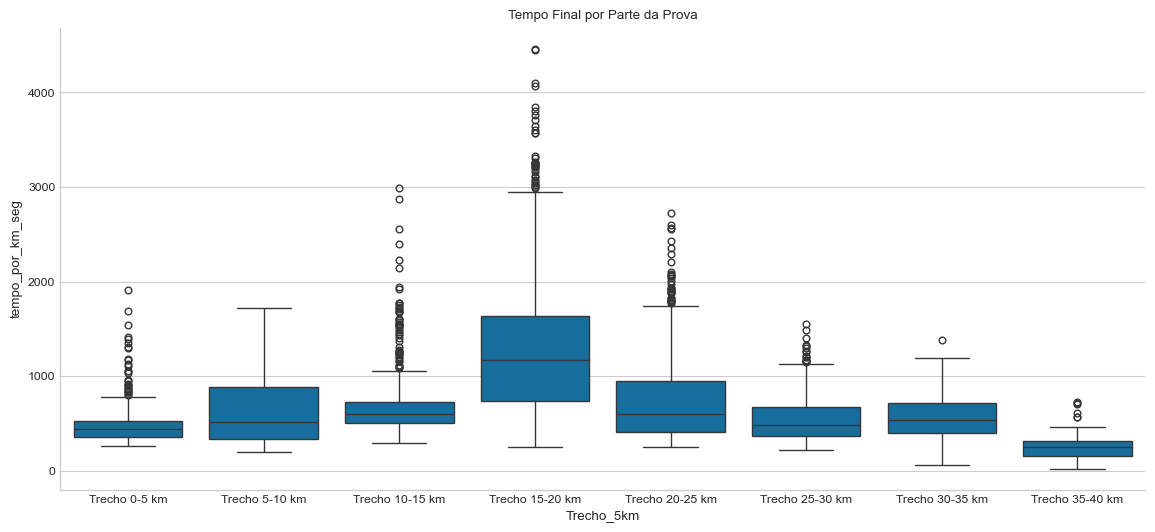

In [105]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_segmentado, x="Trecho_5km", y="tempo_por_km_seg")
plt.title("Tempo Final por Parte da Prova")
plt.show()

In [106]:
ritmo_por_5km = df_segmentado.groupby(["Nome Atleta", "Trecho_5km"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_5km.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para n√£o alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = novos_nomes_colunas

for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a convers√£o (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


df_split_5km = comparativo_splits_flat.reset_index()
df_split_5km.head(5)

Nome Atleta  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Ritmo_Medio_Trecho_35-40_km  Ritmo_Medio_Trecho_5-10_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Tempo_Total_Trecho_35-40_km  Tempo_Total_Trecho_5-10_km  Ritmo_Medio_Trecho_0-5_km_min  Ritmo_Medio_Trecho_10-15_km_min  Ritmo_Medio_Trecho_15-20_km_min  Ritmo_Medio_Trecho_20-25_km_min  Ritmo_Medio_Trecho_25-30_km_min  Ritmo_Medio_Trecho_30-35_km_min  Ritmo_Medio_Trecho_35-40_km_min  Ritmo_Medio_Trecho_5-10_km_min  Tempo_Total_Trecho_0-5_km_min  Tempo_Total_Trecho_10-15_km_min  Tempo_Total_Trecho_15-20_km_min  Tempo_Total_Trecho_20-25_km_min  Tempo_Total_Trecho_25-30_km_min  Tempo_Total_Trecho_30-35_km_min  Tempo_Total_Trecho_35-40_km_min  \
0       ALFREDO GUIMARAES                      419.0                        634.8                        983.0                        495.4                        539.8                        611.4                        357.0                       600.0                     2095.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0                        357.0                      3000.0                           6.98                            10.58                            16.38                             8.26                             9.00                            10.19                             5.95                           10.00                          34.92                            52.90                            81.92                            41.28                            44.98                            50.95                             5.95   
1             Albert Melo                      599.8                        825.4                       1442.8                        737.4                        825.0                        927.8                        701.0                       898.8                     2999.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0                        701.0                      4494.0                          10.00                            13.76                            24.05                            12.29                            13.75                            15.46                            11.68                           14.98                          49.98                            68.78                           120.23                            61.45                            68.75                            77.32                            11.68   
2  Alessandro Sousa(all√™)                      508.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                        271.0                       694.2                     2541.0                       3740.0                      10132.0                       6423.0                       3588.0                       3660.0                        271.0                      3471.0                           8.47                            12.47                            33.77                            21.41                            11.96                            12.20                             4.52                           11.57                          42.35                            62.33                           168.87                           107.05                            59.80                            61.00                             4.52   
3          Alex Junior Aj                      366.2                        568.6                        

##### Juntando as tabelas

In [107]:
# Vamos unir as duas tabelas
df_final_completo_split_5km = pd.merge(
    left=df_final_nivel_inclinacao,  # A tabela principal, da esquerda
    right=df_split_5km,  # A tabela com os splits, da direita
    on="Nome Atleta",  # A chave na tabela da esquerda √© a COLUNA 'Nome Atleta'
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo_split_5km.head()

Nome Atleta    sexo faixa_etaria        peso  ano_corrida  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Total_Desnivel_Positivo  Total_Desnivel_negativo  Tempo_Final_min  Ritmo_Medio_min  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Ritmo_Medio_Primeira_Metade_min  Ritmo_Medio_Segunda_Metade_min  Tempo_Total_Primeira_Metade_min  Tempo_Total_Segunda_Metade_min  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  Ritmo_Medio_DESCIDA_min  Ritmo_Medio_MISTO_min  Ritmo_Medio_PLANO_min  Ritmo_Medio_SUBIDA_min  Tempo_Total_DESCIDA_min  Tempo_Total_MISTO_min  Tempo_Total_PLANO_min  Tempo_Total_SUBIDA_min  indice_subida  indice_descida  indice_descida_vs_subida  \
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg         2022            21774       604.833333               290.291331                   2787.0                  -2790.0       362.900000        10.080556                     4.838189                   667.777778                  541.888889                        12020                        9754                            11.13                            9.03                           200.33                          162.57                          -2.10                         -37.76                                 -0.19           522.933333              474.5              335.5          724.117647                 7844                949                671               12310                     8.72                   7.91                   5.59                   12.07                   130.73                  15.82                  11.18                  205.17       0.197218       -0.135409                 -0.277834   
1             Albert Melo  Homens      25 a 34  75 a 84 kg         2022            31986       888.500000               417.596832                   2787.0                  -2790.0       533.100000        14.808333                     6.959947                   942.944444                  834.055556                        16973                       15013                            15.72                           13.90                           282.88                          250.22                          -1.82                         -32.66                                 -0.12           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583                    13.17                  12.37                   8.92                   17.24                   197.48                  24.73                  17.83                  293.05       0.164090       -0.110936                 -0.236259   
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg         2023            33826       939.611111               669.719569                   2787.0                  -2790.0       563.766667        15.660185                    11.161993                   945.388889                  933.833333                        17017                       16809                            15.76                           15.56                           283.62                          280.15                          -0.20                          -3.47                                 -0.01           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729                    12.42                  10.47                   5.52                   20.32                   186.32                  20.93                  11.03                  345.48       0.297721       -0.206835                 -0.388802   
3          Alex Junior Aj  Ho

### Selecionando as principais vari√°veis

In [108]:
df_final_com_tudo = df_final_completo_split_5km.copy()
df_selecionado = df_final_com_tudo[
    [
        "Nome Atleta",
        "sexo",
        "faixa_etaria",
        "peso",
        "Tempo_Final_seg",
        "Ritmo_Medio_seg",
        "Variabilidade_Ritmo_std",
        "Variabilidade_Ritmo_min_std",
        "Ritmo_Medio_Primeira_Metade",
        "Ritmo_Medio_Segunda_Metade",
        "Tempo_Total_Primeira_Metade",
        "Tempo_Total_Segunda_Metade",
        "Diferenca_Media_Seg_Menos_Pri",
        "Diferenca_total_Seg_Menos_Pri",
        "diff_relativa_segunda_primeira_parte",
        "Ritmo_Medio_Trecho_0-5_km",
        "Ritmo_Medio_Trecho_5-10_km",
        "Ritmo_Medio_Trecho_10-15_km",
        "Ritmo_Medio_Trecho_15-20_km",
        "Ritmo_Medio_Trecho_20-25_km",
        "Ritmo_Medio_Trecho_25-30_km",
        "Ritmo_Medio_Trecho_30-35_km",
        "Ritmo_Medio_Trecho_35-40_km",
        "Tempo_Total_Trecho_0-5_km",
        "Tempo_Total_Trecho_5-10_km",
        "Tempo_Total_Trecho_10-15_km",
        "Tempo_Total_Trecho_15-20_km",
        "Tempo_Total_Trecho_20-25_km",
        "Tempo_Total_Trecho_25-30_km",
        "Tempo_Total_Trecho_30-35_km",
        "Tempo_Total_Trecho_35-40_km",
        "Ritmo_Medio_DESCIDA",
        "Ritmo_Medio_MISTO",
        "Ritmo_Medio_PLANO",
        "Ritmo_Medio_SUBIDA",
        "Tempo_Total_DESCIDA",
        "Tempo_Total_MISTO",
        "Tempo_Total_PLANO",
        "Tempo_Total_SUBIDA",
        "indice_subida",
        "indice_descida_vs_subida",
        "indice_descida",
    ]
].copy()


df_selecionado.to_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_selecionado.head(10)

Nome Atleta      sexo faixa_etaria           peso  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Ritmo_Medio_Trecho_35-40_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_5-10_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Tempo_Total_Trecho_35-40_km  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  \
0            ALFREDO GUIMARAES    Homens      45 a 54     75 a 84 kg            21774       604.833333               290.291331                     4.838189                   667.777778                  541.888889                        12020                        9754                          -2.10                         -37.76                                 -0.19                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                       611.40                        357.0                     2095.0                      3000.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0                        357.0           522.933333              474.5              335.5          724.117647                 7844                949                671               12310   
1                  Albert Melo    Homens      25 a 34     75 a 84 kg            31986       888.500000               417.596832                     6.959947                   942.944444                  834.055556                        16973                       15013                          -1.82                         -32.66                                 -0.12                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                       927.80                        701.0                     2999.0                      4494.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0                        701.0           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583   
2       Alessandro Sousa(all√™)    Homens      45 a 54     65 a 74 kg            33826       939.611111               669.719569                    11.161993                   945.388889                  933.833333                        17017                       16809                          -0.20                          -3.47                                 -0.01                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                       732.00                        271.0                     2541.0                      3471.0                       3740.0                      10132.0                       6423.0                       3588.0                       3660.0                        271.0           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729   
3               Alex Junior Aj    Homens      20 a 24     

## Clusteriza√ß√£o

### Poucas variaveis

In [109]:
df_cluster = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_cluster.head(10)

Unnamed: 0                  Nome Atleta      sexo faixa_etaria           peso  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Ritmo_Medio_Trecho_35-40_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_5-10_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Tempo_Total_Trecho_35-40_km  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  \
0           0            ALFREDO GUIMARAES    Homens      45 a 54     75 a 84 kg            21774       604.833333               290.291331                     4.838189                   667.777778                  541.888889                        12020                        9754                          -2.10                         -37.76                                 -0.19                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                       611.40                        357.0                     2095.0                      3000.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0                        357.0           522.933333              474.5              335.5          724.117647                 7844                949                671   
1           1                  Albert Melo    Homens      25 a 34     75 a 84 kg            31986       888.500000               417.596832                     6.959947                   942.944444                  834.055556                        16973                       15013                          -1.82                         -32.66                                 -0.12                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                       927.80                        701.0                     2999.0                      4494.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0                        701.0           789.933333              742.0              535.0         1034.294118                11849               1484               1070   
2           2       Alessandro Sousa(all√™)    Homens      45 a 54     65 a 74 kg            33826       939.611111               669.719569                    11.161993                   945.388889                  933.833333                        17017                       16809                          -0.20                          -3.47                                 -0.01                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                       732.00                        271.0                     2541.0                      3471.0                       3740.0                      10132.0                       6423.0                       3588.0                       3660.0                        271.0           745.266667              628.0              331.0         1219.352941                11179               1256                662   
3           3               Alex Junior Aj    Homens      20 a 24     65 a

In [110]:
features_para_cluster = [
    "Tempo_Final_seg",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
]

# Criando um novo DataFrame apenas com as features selecionadas e sem dados faltantes
df_cluster = df_cluster[features_para_cluster].dropna()

# Guardando os nomes dos atletas (o √≠ndice) para usarmos depois
nomes_atletas = df_cluster.index

# --- 2. ESCALONAMENTO DOS DADOS (PASSO OBRIGAT√ìRIO) ---
# Todas as vari√°veis precisam estar na mesma escala de import√¢ncia
scaler = StandardScaler()
dados_escalonados = scaler.fit_transform(df_cluster)

print("Dados prontos e escalonados! Pr√≥ximo passo: encontrar o n√∫mero de clusters.")

Dados prontos e escalonados! Pr√≥ximo passo: encontrar o n√∫mero de clusters.


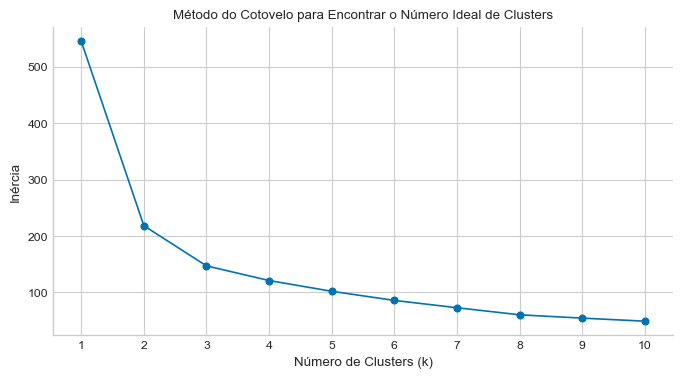

In [111]:
# --- 3. M√âTODO DO COTOVELO ---
inercia = []
range_clusters = range(1, 11)  # Vamos testar de 1 a 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_escalonados)
    inercia.append(kmeans.inertia_)

# Plotando o gr√°fico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inercia, marker="o")
plt.title("M√©todo do Cotovelo para Encontrar o N√∫mero Ideal de Clusters")
plt.xlabel("N√∫mero de Clusters (k)")
plt.ylabel("In√©rcia")
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

In [112]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o n√∫mero ideal de clusters que encontramos foi 3
numero_ideal_clusters = 3

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os r√≥tulos dos clusters de volta ao nosso DataFrame
df_cluster["cluster"] = kmeans_final.labels_


# --- 5. INTERPRETA√á√ÉO DOS CLUSTERS (PROFILING) ---
# Este √© o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a m√©dia de cada vari√°vel.
perfis_clusters = df_cluster.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
cluster                                                                                                                         
0               36414.87                                 -0.15                   729.28             1284.11               821.48
1               27812.03                                 -0.07                   473.29              962.87               647.21
2               19575.72                                 -0.22                   270.22              655.64               469.38


In [113]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o n√∫mero ideal de clusters que encontramos foi 3
numero_ideal_clusters = 4

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os r√≥tulos dos clusters de volta ao nosso DataFrame
df_cluster["cluster"] = kmeans_final.labels_


# --- 5. INTERPRETA√á√ÉO DOS CLUSTERS (PROFILING) ---
# Este √© o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a m√©dia de cada vari√°vel.
perfis_clusters = df_cluster.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
cluster                                                                                                                         
0               30920.55                                 -0.12                   560.84             1089.09               696.86
1               23152.81                                 -0.08                   359.93              782.43               562.58
2               19138.27                                 -0.25                   259.42              640.91               455.15
3               37460.33                                 -0.15                   752.88             1317.87               848.04


In [114]:
df_cluster["cluster"].value_counts()

cluster
2    44
1    27
0    20
3    18
Name: count, dtype: int64

##### Analisando os clusters

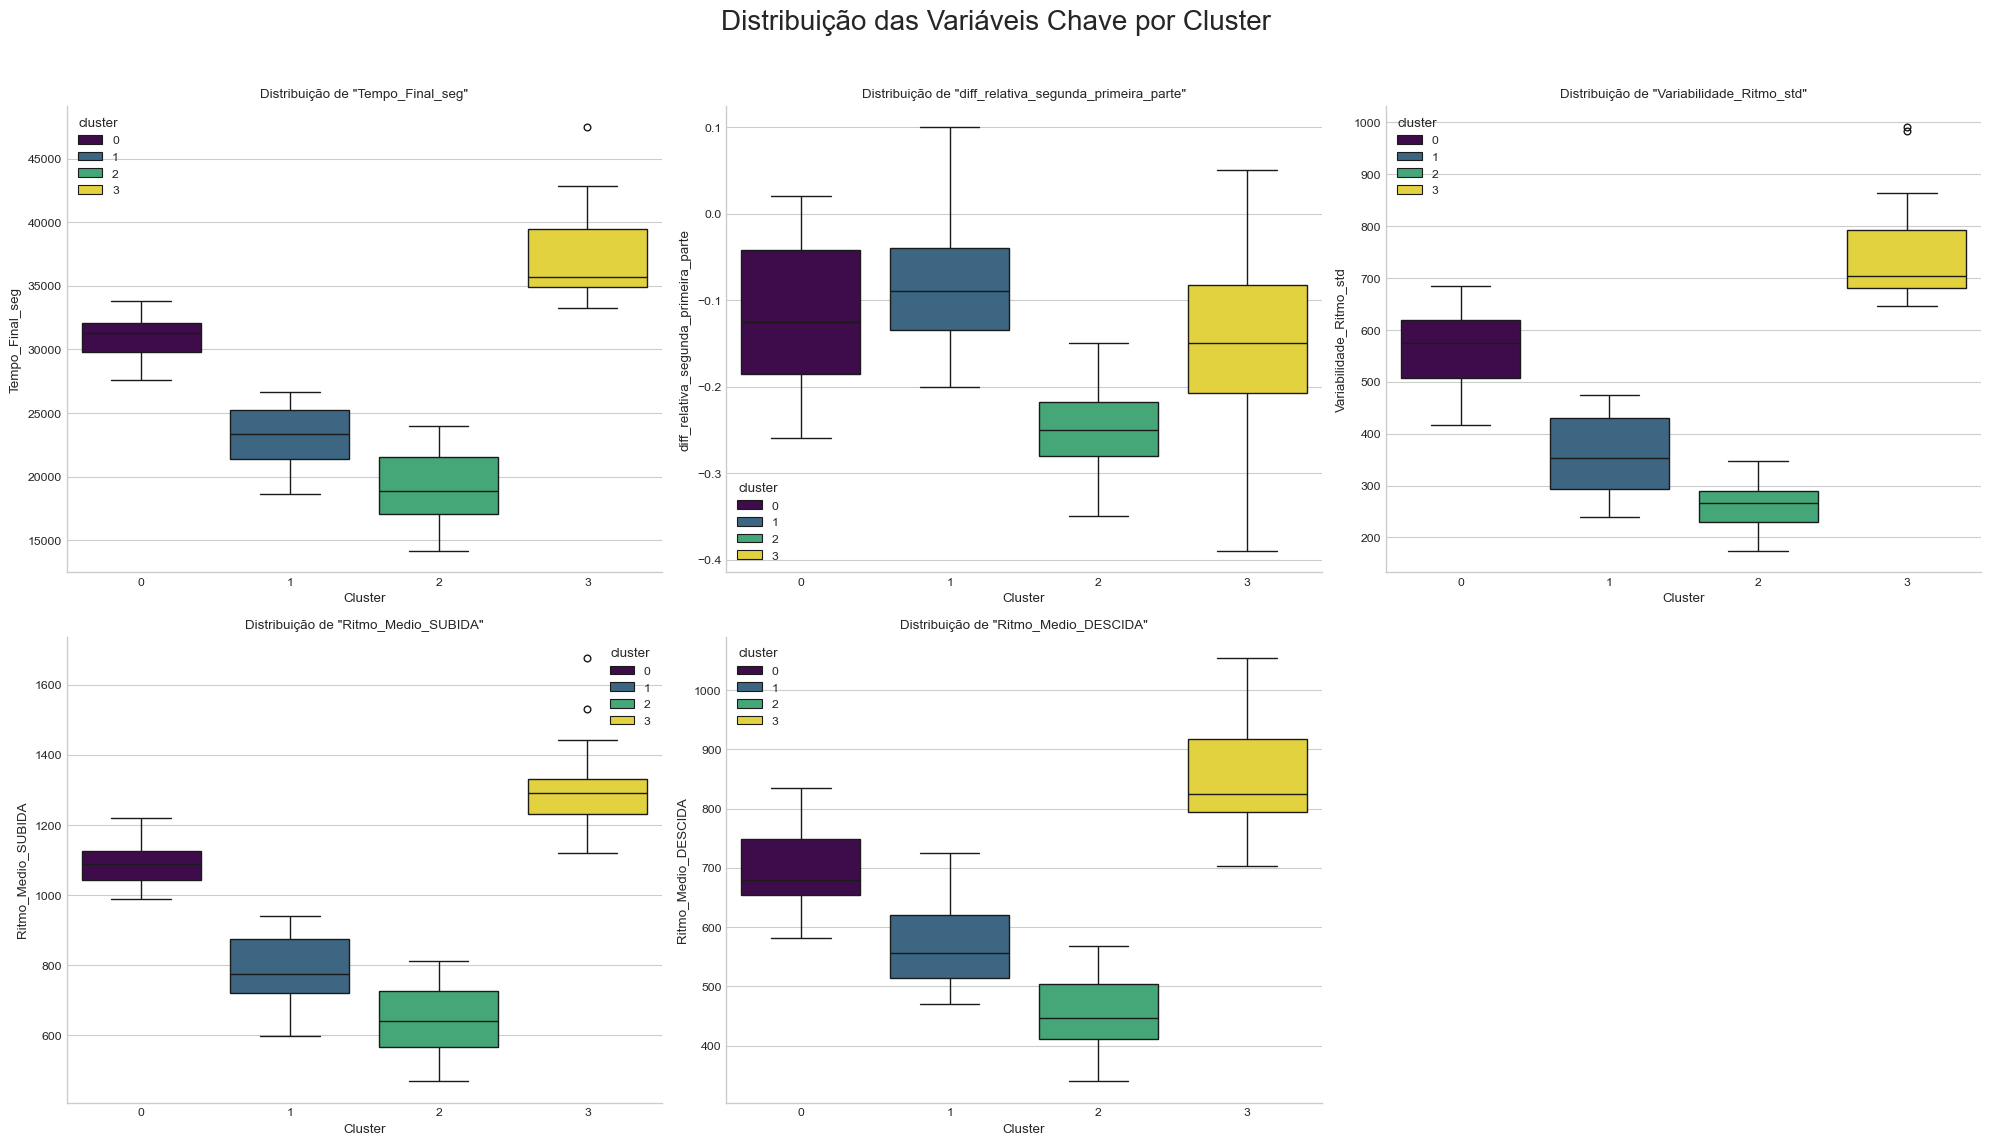

In [115]:
features_usadas = [
    "Tempo_Final_seg",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# T√≠tulo principal para todos os gr√°ficos
fig.suptitle("Distribui√ß√£o das Vari√°veis Chave por Cluster", fontsize=20)


# 3. "Achate" o array de eixos para facilitar o loop
# O 'axes' √© uma matriz 2x3. axes.flatten() o transforma em uma lista simples [ax1, ax2, ..., ax6]
axes = axes.flatten()


# 4. Fa√ßa o loop, associando cada feature a um eixo
for i, feature in enumerate(features_usadas):
    # O par√¢metro 'ax=axes[i]' diz ao seaborn para desenhar no subplot correto
    sns.boxplot(
        data=df_cluster,
        x="cluster",
        y=feature,
        hue="cluster",
        palette="viridis",
        ax=axes[i],
    )

    # Use ax.set_title() em vez de plt.title()
    axes[i].set_title(f'Distribui√ß√£o de "{feature}"')
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)


# 5. Como temos uma grade 2x3 (6 posi√ß√µes) e apenas 5 gr√°ficos, vamos esconder o √∫ltimo eixo vazio
fig.delaxes(axes[5])


# 6. Ajuste o layout para evitar sobreposi√ß√£o de t√≠tulos e exiba o gr√°fico
plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # rect ajusta para o suptitle caber
plt.show()

**Cluster 2 (Verde)**: Elite / Atletas de Alta Performance - 44 Individuos
Este √© inequivocamente o grupo de elite da prova. Eles se destacam em todas as m√©tricas analisadas.

- *Performance Geral*: Com o menor tempo final m√©dio (19138s), este grupo, como visto no boxplot, est√° em uma categoria pr√≥pria, com o box inteiro posicionado bem abaixo dos outros.

- *Gest√£o e Consist√™ncia*: Eles n√£o s√£o apenas r√°pidos, mas tamb√©m os mais consistentes, com a menor Variabilidade_Ritmo_std (259s). Al√©m disso, apresentam a maior diff_relativa negativa (-0.25), indicando que s√£o os mais eficientes em gerenciar a energia na primeira metade dif√≠cil para capitalizar na segunda metade mais f√°cil.

- *Habilidade em Terreno*: Dominam todos os terrenos, sendo os mais r√°pidos tanto em subidas (ritmo m√©dio de 640s) quanto em descidas (455s).

> *Persona*: O corredor de elite. Completo, estrat√©gico, consistente e superior em todos os aspectos t√©cnicos da corrida de montanha.

**Cluster 1 (Azul)**: Amadores Avan√ßados / Ritmo Forte - 27 Individuos
Este grupo representa o pelot√£o da frente dos corredores amadores, um grupo forte que persegue a elite.

- *Performance Geral*: Possuem o segundo melhor tempo final m√©dio (23152s), posicionando-se claramente entre a elite e o restante dos competidores. S√£o tamb√©m o segundo grupo mais consistente (Variabilidade_Ritmo_std de 359s).

- *Gest√£o e Consist√™ncia*: A principal caracter√≠stica deste grupo √© sua ''diff_relativa' pr√≥xima de zero (-0.08). Eles s√£o os que menos aceleram, proporcionalmente, na segunda metade. Isso sugere uma estrat√©gia de "for√ßa bruta", onde mant√™m um ritmo muito forte desde o in√≠cio, inclusive na parte dif√≠cil, o que lhes garante um bom tempo final, mas com menos "sobra" para acelerar no final.

- *Habilidade em Terreno*: S√£o competentes em todos os terrenos, com o segundo melhor ritmo m√©dio em subidas e descidas.

> *Persona*: O competidor amador forte. R√°pido e consistente, adota uma estrat√©gia de ritmo forte o tempo todo, com menor varia√ß√£o entre as metades da prova.

**Cluster 0 (Roxo)**: Intermedi√°rios / Meio do Pelot√£o - 20 individuos
Este cluster representa o cora√ß√£o da prova, o maior grupo de corredores que completam o desafio em um tempo respeit√°vel.

- *Performance Geral*: Com um tempo final m√©dio de 30920s, eles formam o pelot√£o intermedi√°rio. Sua variabilidade de ritmo (560s) √© moderada, superior √† dos grupos mais r√°pidos.

- *Gest√£o e *Consist√™ncia*: Apresentam uma diff_relativa de -0.12, um valor intermedi√°rio que representa um comportamento "padr√£o" de desacelera√ß√£o na parte dif√≠cil e acelera√ß√£o na parte f√°cil, mas sem a mesma efici√™ncia dos grupos de ponta.

- *Habilidade em Terreno*: Como esperado, seus ritmos em subida (1089s) e descida (696s) s√£o intermedi√°rios, mostrando uma performance s√≥lida, mas sem a especializa√ß√£o dos atletas mais r√°pidos. O boxplot para este grupo √© visivelmente mais "alto", indicando maior diversidade de n√≠veis dentro deste mesmo cluster.

> *Persona*: O corredor intermedi√°rio. Completa a prova com solidez, mas com mais oscila√ß√µes de ritmo e sem a mesma capacidade de resposta nos diferentes terrenos que os atletas de ponta.

**Cluster 3 (Azul)**: Recreacionais / Gest√£o de Sobreviv√™ncia -18 Individuos
Este grupo representa os atletas cujo principal objetivo √© completar o percurso, gerenciando o esfor√ßo para cruzar a linha de chegada.

- *Performance Geral*: S√£o o grupo com o maior tempo final m√©dio (37460s).

- *Gest√£o e Consist√™ncia*: A caracter√≠stica que mais os define √© a alt√≠ssima Variabilidade_Ritmo_std (752s). O boxplot desta vari√°vel para o Cluster 3 √© extremamente alto e destacado dos demais, sugerindo uma estrat√©gia que alterna muito entre caminhada (especialmente nas subidas) e corrida.

- *Habilidade em Terreno*: Consequentemente, possuem o ritmo m√©dio mais lento em subidas (1317s) e descidas (848s). Sua diff_relativa (-0.15) √© relativamente alta porque, ao caminhar muito lentamente na primeira metade dif√≠cil, eles t√™m uma margem enorme para "acelerar" (mesmo que para um trote leve) na segunda metade.

> *Persona*: O corredor recreacional. Focado em terminar a prova, utiliza uma estrat√©gia de ritmo controlado (corrida/caminhada) para gerenciar a energia ao longo do percurso desafiador, resultando em alta variabilidade de ritmo.

### Clusterizando com mais Vari√°veis

In [116]:
df_cluster2 = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_cluster2.set_index("Nome Atleta", inplace=True)
df_cluster2.columns

Index(['Unnamed: 0', 'sexo', 'faixa_etaria', 'peso', 'Tempo_Final_seg', 'Ritmo_Medio_seg', 'Variabilidade_Ritmo_std', 'Variabilidade_Ritmo_min_std', 'Ritmo_Medio_Primeira_Metade', 'Ritmo_Medio_Segunda_Metade', 'Tempo_Total_Primeira_Metade', 'Tempo_Total_Segunda_Metade', 'Diferenca_Media_Seg_Menos_Pri', 'Diferenca_total_Seg_Menos_Pri', 'diff_relativa_segunda_primeira_parte', 'Ritmo_Medio_Trecho_0-5_km', 'Ritmo_Medio_Trecho_5-10_km', 'Ritmo_Medio_Trecho_10-15_km', 'Ritmo_Medio_Trecho_15-20_km', 'Ritmo_Medio_Trecho_20-25_km', 'Ritmo_Medio_Trecho_25-30_km', 'Ritmo_Medio_Trecho_30-35_km', 'Ritmo_Medio_Trecho_35-40_km', 'Tempo_Total_Trecho_0-5_km', 'Tempo_Total_Trecho_5-10_km', 'Tempo_Total_Trecho_10-15_km', 'Tempo_Total_Trecho_15-20_km', 'Tempo_Total_Trecho_20-25_km', 'Tempo_Total_Trecho_25-30_km', 'Tempo_Total_Trecho_30-35_km', 'Tempo_Total_Trecho_35-40_km', 'Ritmo_Medio_DESCIDA', 'Ritmo_Medio_MISTO', 'Ritmo_Medio_PLANO', 'Ritmo_Medio_SUBIDA', 'Tempo_Total_DESCIDA', 'Tempo_Total_MISTO',
  

In [117]:
df_cluster2.head()

Unnamed: 0    sexo faixa_etaria        peso  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Ritmo_Medio_Trecho_35-40_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_5-10_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Tempo_Total_Trecho_35-40_km  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  \
Nome Atleta                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
ALFREDO GUIMARAES                0  Homens      45 a 54  75 a 84 kg            21774       604.833333               290.291331                     4.838189                   667.777778                  541.888889                        12020                        9754                          -2.10                         -37.76                                 -0.19                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                        357.0                     2095.0                      3000.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0                        357.0           522.933333              474.5              335.5          724.117647                 7844                949                671               12310   
Albert Melo                      1  Homens      25 a 34  75 a 84 kg            31986       888.500000               417.596832                     6.959947                   942.944444                  834.055556                        16973                       15013                          -1.82                         -32.66                                 -0.12                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                        701.0                     2999.0                      4494.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0                        701.0           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583   
Alessandro Sousa(all√™)           2  Homens      45 a 54  65 a 74 kg

In [118]:
features_para_cluster = [
    "Tempo_Final_seg",
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
    "indice_subida",
    "indice_descida_vs_subida",
    "indice_descida",
]

# Criando um novo DataFrame apenas com as features selecionadas e sem dados faltantes
df_cluster2 = df_cluster2[features_para_cluster].dropna()

# Guardando os nomes dos atletas (o √≠ndice) para usarmos depois
nomes_atletas = df_cluster2.index

# --- 2. ESCALONAMENTO DOS DADOS (PASSO OBRIGAT√ìRIO) ---
# Todas as vari√°veis precisam estar na mesma escala de import√¢ncia
scaler = StandardScaler()
dados_escalonados = scaler.fit_transform(df_cluster2)

print("Dados prontos e escalonados! Pr√≥ximo passo: encontrar o n√∫mero de clusters.")

Dados prontos e escalonados! Pr√≥ximo passo: encontrar o n√∫mero de clusters.


In [119]:
df_cluster2.columns

Index(['Tempo_Final_seg', 'Ritmo_Medio_Primeira_Metade', 'Ritmo_Medio_Segunda_Metade', 'Ritmo_Medio_Trecho_0-5_km', 'Ritmo_Medio_Trecho_5-10_km', 'Ritmo_Medio_Trecho_10-15_km', 'Ritmo_Medio_Trecho_15-20_km', 'Ritmo_Medio_Trecho_20-25_km', 'Ritmo_Medio_Trecho_25-30_km', 'Ritmo_Medio_Trecho_30-35_km', 'diff_relativa_segunda_primeira_parte', 'Variabilidade_Ritmo_std', 'Ritmo_Medio_SUBIDA', 'Ritmo_Medio_DESCIDA', 'indice_subida', 'indice_descida_vs_subida', 'indice_descida'], dtype='object')

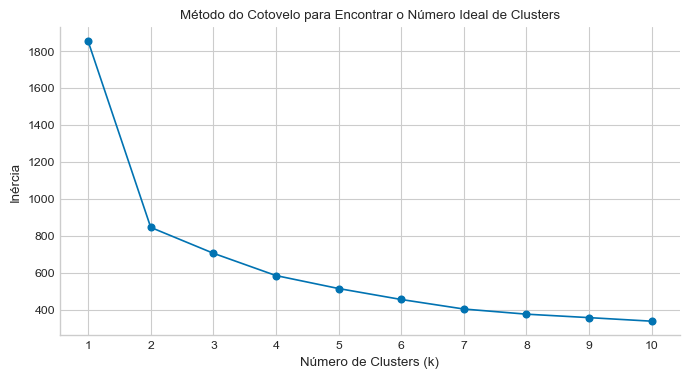

In [120]:
# --- 3. M√âTODO DO COTOVELO ---
inercia = []
range_clusters = range(1, 11)  # Vamos testar de 1 a 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_escalonados)
    inercia.append(kmeans.inertia_)

# Plotando o gr√°fico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inercia, marker="o")
plt.title("M√©todo do Cotovelo para Encontrar o N√∫mero Ideal de Clusters")
plt.xlabel("N√∫mero de Clusters (k)")
plt.ylabel("In√©rcia")
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

In [121]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o n√∫mero ideal de clusters que encontramos foi 3
numero_ideal_clusters = 4

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os r√≥tulos dos clusters de volta ao nosso DataFrame
labels_cluster = kmeans_final.labels_
df_resultados_cluster = pd.DataFrame({"cluster": labels_cluster}, index=nomes_atletas)

df_cluster2_com_labels = df_cluster2.merge(
    df_resultados_cluster, left_index=True, right_index=True, how="left"
)


# --- 5. INTERPRETA√á√ÉO DOS CLUSTERS (PROFILING) ---
# Este √© o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a m√©dia de cada vari√°vel.
perfis_clusters = df_cluster2_com_labels.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA  indice_subida  indice_descida_vs_subida  indice_descida
cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                   
0               22871.56                       695.53                     

In [122]:
df_cluster2_com_labels.head()

Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA  indice_subida  indice_descida_vs_subida  indice_descida  cluster
Nome Atleta                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
ALFREDO GUIMARAES                 21774                   667.777778                  541.888889                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                                 -0.19               290.291331          724.117647           522.933333       0.197218                 -0.277834       -0.135409        0
Albert Melo                       31986                   942.944444                  834.055556                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                                 -0.12               417.596832         1034.294118           789.933333       0.164090                 -0.236259       -0.110936        2
Alessandro Sousa(all√™)            33826                   945.388889                  933.833333                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                                 -0.01               669.719569         1219.352941           745.266667       0.297721                 -0.388802       -0.206835        1
Alex Junior Aj                    18496                   598.944444                  428.611111                      366.2                       532.2                        568.6                        869.4                        404.2                        445.6                        478.2                                 -0.28               261.647539          619.529412           443.133333       0.205831                 -0.284726       -0.137500        3
Alexandre Santiago                14626                   467.722222                  365.117647                      316.6                       413.0                        448.6                        658.6                        313.8                        373.0                        401.6                                 -0.22               195.390826          479.882353           366.466667       0.148358                 -0.236341       -0.123046        3

In [124]:
df_cluster2_com_labels["cluster"].value_counts()

cluster
0    34
3    34
1    24
2    17
Name: count, dtype: int64

##### Analisando os clusters

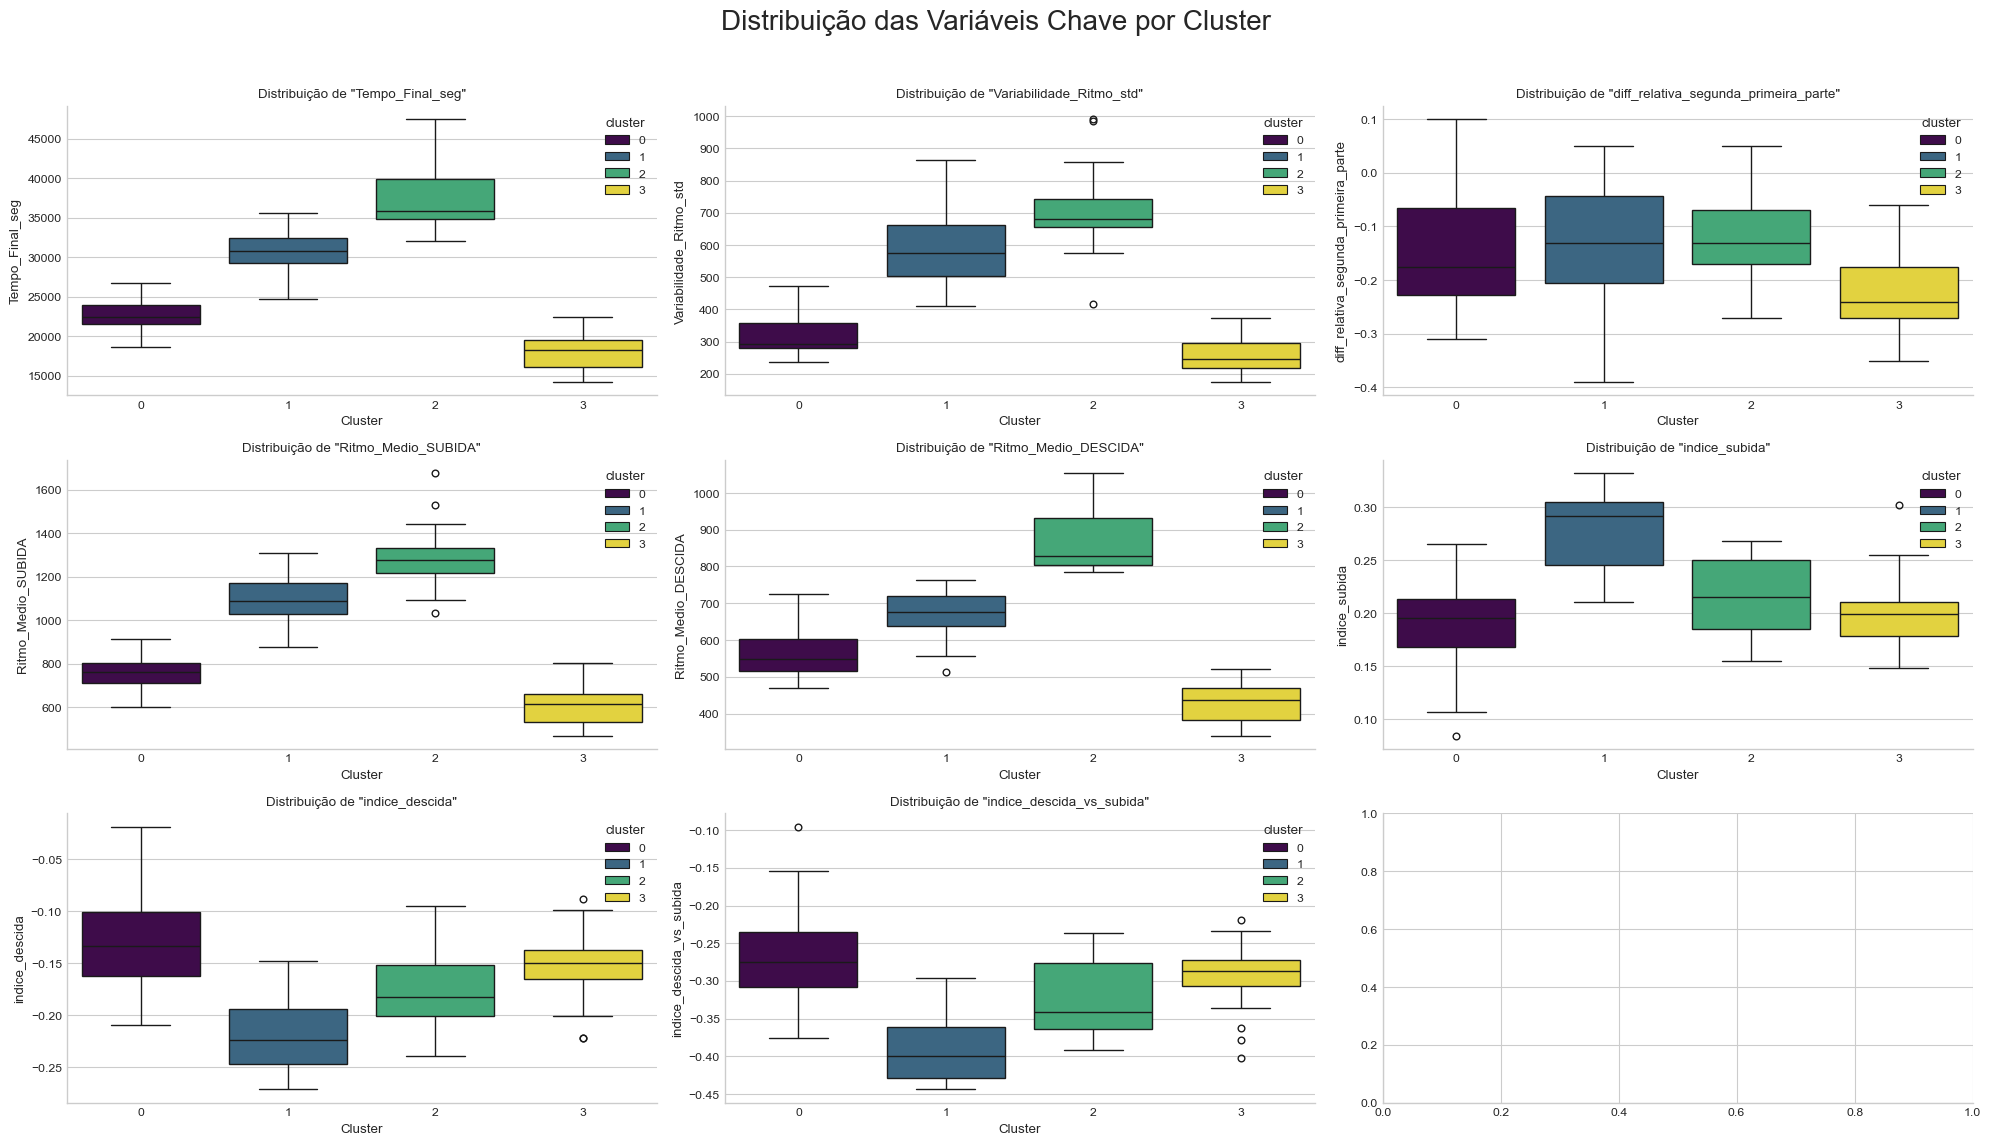

In [125]:
features_usadas = [
    "Tempo_Final_seg",
    "Variabilidade_Ritmo_std",
    "diff_relativa_segunda_primeira_parte",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
    "indice_subida",
    "indice_descida",
    "indice_descida_vs_subida",
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

# T√≠tulo principal para todos os gr√°ficos
fig.suptitle("Distribui√ß√£o das Vari√°veis Chave por Cluster", fontsize=20)


# 3. "Achate" o array de eixos para facilitar o loop
# O 'axes' √© uma matriz 2x3. axes.flatten() o transforma em uma lista simples [ax1, ax2, ..., ax6]
axes = axes.flatten()


# 4. Fa√ßa o loop, associando cada feature a um eixo
for i, feature in enumerate(features_usadas):
    # O par√¢metro 'ax=axes[i]' diz ao seaborn para desenhar no subplot correto
    sns.boxplot(
        data=df_cluster2_com_labels,
        x="cluster",
        y=feature,
        hue="cluster",
        palette="viridis",
        ax=axes[i],
    )

    # Use ax.set_title() em vez de plt.title()
    axes[i].set_title(f'Distribui√ß√£o de "{feature}"')
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)


# 6. Ajuste o layout para evitar sobreposi√ß√£o de t√≠tulos e exiba o gr√°fico
plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # rect ajusta para o suptitle caber
plt.show()

A nova clusteriza√ß√£o revelou quatro personas muito distintas, especialmente ao olharmos os novos √≠ndices que medem a especializa√ß√£o em subida e descida.

**Cluster 3 (Amarelo)**: A Elite Completa
- *Performance*: Continuam sendo o grupo mais r√°pido (Tempo_Final_seg de 18056s). Os boxplots mostram que eles est√£o em uma categoria √† parte em termos de velocidade.

- *Consist√™ncia e Estrat√©gia*: S√£o os mais consistentes (menor Variabilidade_Ritmo_std) e os que melhor executam a estrat√©gia do percurso (maior diff_relativa negativa).

- *Habilidade em Terreno*: A an√°lise dos √≠ndices mostra que eles s√£o simplesmente excelentes em tudo. Seus indice_subida (0.20) e indice_descida (-0.15) s√£o baixos, indicando que, em rela√ß√£o ao seu pr√≥prio ritmo m√©dio alt√≠ssimo, eles perdem pouco tempo subindo e ganham um tempo moderado descendo. S√£o completos, sem pontos fracos.

> *Persona*: A Elite Completa. R√°pidos, estrat√©gicos e tecnicamente proficientes em todos os terrenos.

**Cluster 0 (Roxo)**: Os Escaladores
- *Performance*: S√£o o segundo grupo mais r√°pido (Tempo_Final_seg de 22871s).

- *Consist√™ncia e Estrat√©gia*: S√£o muito consistentes (segunda menor variabilidade) e t√™m uma boa gest√£o de prova.

- *Habilidade em Terreno*: Aqui est√° a grande descoberta! Olhe para os √≠ndices. Eles t√™m o melhor indice_subida de todos (0.19), significando que s√£o os que menos perdem tempo, proporcionalmente, nas subidas. Em contrapartida, t√™m o pior indice_descida (-0.13).

- *Interpreta√ß√£o*: Este grupo garante seu excelente resultado por ser excepcionalmente forte nas subidas. Eles n√£o s√£o os melhores descendo, mas sua for√ßa como escaladores os coloca no p√≥dio dos amadores.

> *Persona*: Os Escaladores de Elite Amadora. Usam a for√ßa na subida como sua principal arma para garantir um tempo final baixo.

**Cluster 1 (Azul)**: Os Especialistas em Descida
- *Performance*: Formam o grupo intermedi√°rio r√°pido (Tempo_Final_seg de 30604s).

- *Consist√™ncia e Estrat√©gia*: S√£o o grupo com a maior quebra de ritmo (Variabilidade_Ritmo_std alta), o que √© interessante.

- *Habilidade em Terreno*: O oposto do Cluster 0! Eles t√™m o pior indice_subida (0.28), mas o melhor indice_descida (-0.22) e, de longe, o melhor indice_descida_vs_subida (-0.39).

Interpreta√ß√£o: Este √© o perfil do especialista em descida. Eles "sofrem" mais nas subidas, mas compensam com uma t√©cnica e coragem excepcionais nas descidas, onde ganham muito tempo. Sua alta variabilidade pode ser explicada por essa grande diferen√ßa de ritmo entre subidas (lentas) e descidas (muito r√°pidas).

Persona: Os Descenders Destemidos. Atletas tecnicamente habilidosos que usam as descidas para construir sua performance.

Cluster 2 (Verde): Os Guerreiros Resistentes
Performance: S√£o o grupo com o maior tempo final (Tempo_Final_seg de 37286s).

Consist√™ncia e Estrat√©gia: Possuem a maior variabilidade, indicando um ritmo que alterna mais entre corrida e caminhada.

Habilidade em Terreno: S√£o os mais lentos em todos os terrenos, mas seus √≠ndices (indice_subida de 0.22 e indice_descida de -0.17) mostram um perfil relativamente equilibrado. A principal caracter√≠stica deles n√£o √© uma especializa√ß√£o, mas sim um ritmo geral mais controlado para garantir a conclus√£o da prova.

Persona: Os Guerreiros Resistentes. Focados em completar o desafio, seu perfil √© de resist√™ncia e perseveran√ßa, mais do que de especializa√ß√£o t√©cnica.

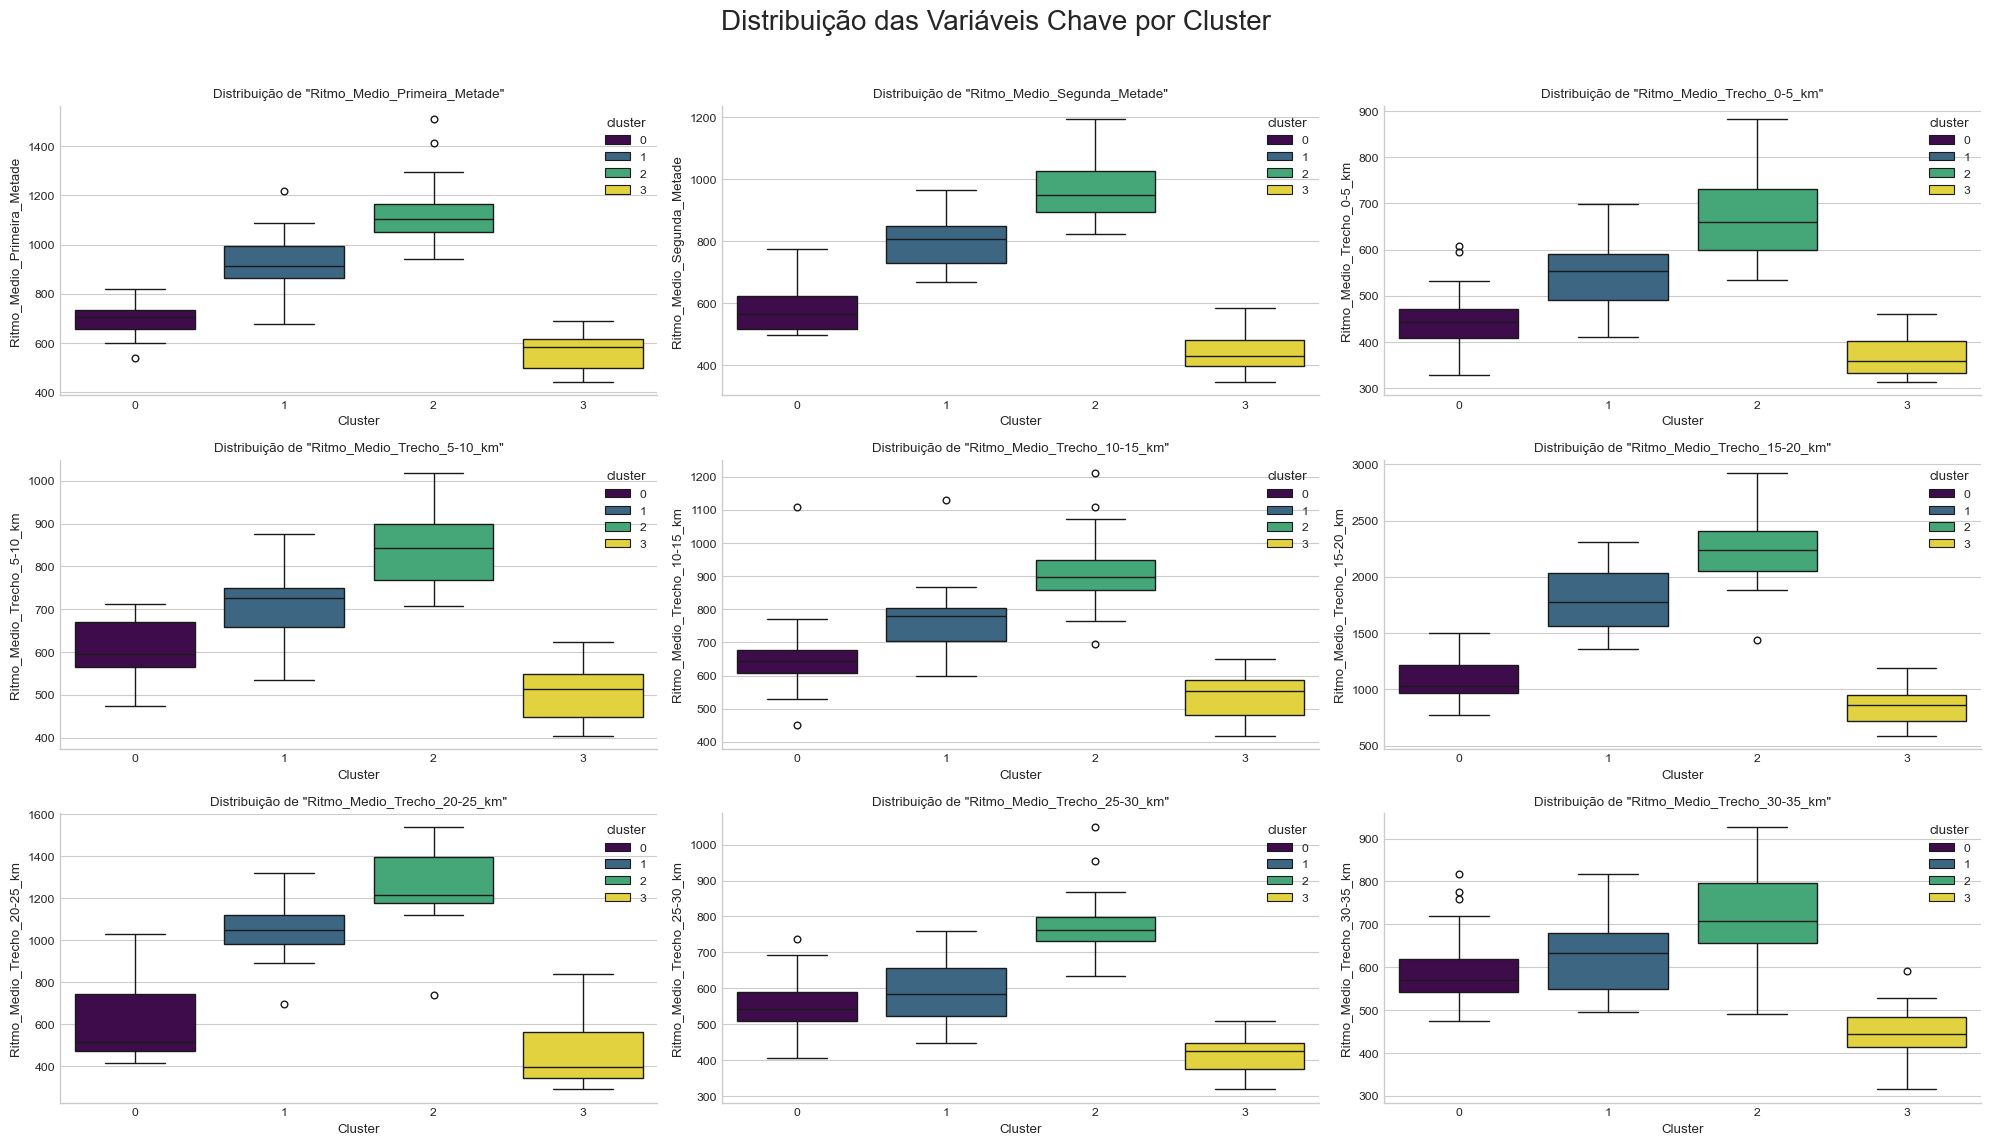

In [126]:
features_usadas = [
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

# T√≠tulo principal para todos os gr√°ficos
fig.suptitle("Distribui√ß√£o das Vari√°veis Chave por Cluster", fontsize=20)


# 3. "Achate" o array de eixos para facilitar o loop
# O 'axes' √© uma matriz 2x3. axes.flatten() o transforma em uma lista simples [ax1, ax2, ..., ax6]
axes = axes.flatten()


# 4. Fa√ßa o loop, associando cada feature a um eixo
for i, feature in enumerate(features_usadas):
    # O par√¢metro 'ax=axes[i]' diz ao seaborn para desenhar no subplot correto
    sns.boxplot(
        data=df_cluster2_com_labels,
        x="cluster",
        y=feature,
        hue="cluster",
        palette="viridis",
        ax=axes[i],
    )

    # Use ax.set_title() em vez de plt.title()
    axes[i].set_title(f'Distribui√ß√£o de "{feature}"')
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)


# 6. Ajuste o layout para evitar sobreposi√ß√£o de t√≠tulos e exiba o gr√°fico
plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # rect ajusta para o suptitle caber
plt.show()

Visualiza√ß√£o

In [127]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicion√°rio de agrega√ß√£o, passando a lista de estat√≠sticas para cada coluna
resumo_completo = df_cluster2_com_labels.groupby("cluster").agg(
    {
        "Variabilidade_Ritmo_std": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualiza√ß√£o.
print("--- Resumo Estat√≠stico Detalhado por varia√ß√£o ritmo std e cluster ---")
print(resumo_completo.round(2))

--- Resumo Estat√≠stico Detalhado por varia√ß√£o ritmo std e cluster ---
        Variabilidade_Ritmo_std                                
                           mean     std     min  median     max
cluster                                                        
0                        325.15   70.33  237.82  292.42  474.11
1                        582.33  115.84  411.43  576.61  864.19
2                        711.45  138.91  417.60  682.08  990.81
3                        258.11   52.14  174.15  246.80  372.34


In [128]:
df_desnivel = df_segmentado[
    ["Trecho_5km", "desnivel_positivo", "desnivel_negativo"]
].drop_duplicates()

df_desnivel_positivo_por_faixa = (
    df_desnivel.groupby("Trecho_5km")
    .agg(
        {
            "desnivel_positivo": "sum",
            "desnivel_negativo": "sum",
        }
    )
    .stack(level=0)
)
df_desnivel_positivo_por_faixa

df_desnivel = df_desnivel_positivo_por_faixa.unstack().reset_index()
df_desnivel = df_desnivel[df_desnivel["Trecho_5km"] != "Trecho 35-40 km"]

df_desnivel["ordem_trecho"] = (
    df_desnivel["Trecho_5km"].str.extract(r"(\d+)").astype(int)
)

# 3. Ordena o DataFrame com base na nova coluna num√©rica.
df_desnivel = df_desnivel.sort_values(by="ordem_trecho")

# 4. Remove a coluna de ordena√ß√£o tempor√°ria e reseta o √≠ndice para um resultado limpo.
df_desnivel = df_desnivel.drop(columns="ordem_trecho").reset_index(drop=True)

df_desnivel

Trecho_5km  desnivel_positivo  desnivel_negativo
0    Trecho 0-5 km              246.0             -148.0
1   Trecho 5-10 km              367.0             -452.0
2  Trecho 10-15 km              473.0              -97.0
3  Trecho 15-20 km              996.0             -429.0
4  Trecho 20-25 km              453.0             -474.0
5  Trecho 25-30 km               43.0             -897.0
6  Trecho 30-35 km              201.0             -284.0

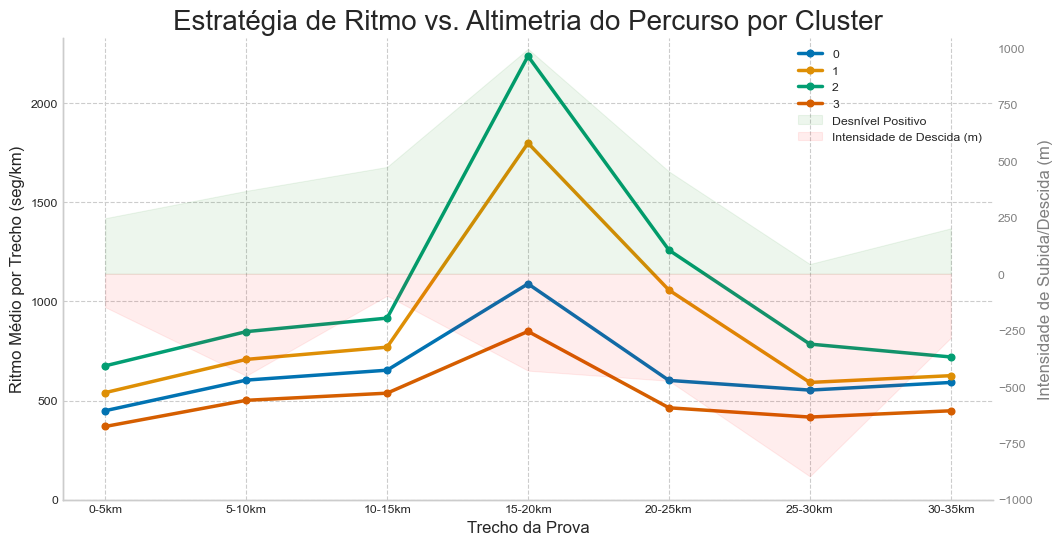

In [129]:
# Crie a figura e o primeiro eixo (para o ritmo)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Pegando apenas as colunas de ritmo por trecho da sua tabela de perfis
colunas_ritmo_trechos = [
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
]
perfis_ritmo = perfis_clusters[
    colunas_ritmo_trechos
].T  # .T para transpor (facilita o plot)

# Renomeando o √≠ndice para ficar mais claro
perfis_ritmo.index = [
    "0-5km",
    "5-10km",
    "10-15km",
    "15-20km",
    "20-25km",
    "25-30km",
    "30-35km",
]

# Plote o gr√°fico de linhas do ritmo no primeiro eixo (ax1)
perfis_ritmo.plot(
    ax=ax1, marker="o", linewidth=2.5, zorder=10
)  # zorder alto para ficar na frente

# Est√©tica do eixo 1 (Ritmo)
ax1.set_title("Estrat√©gia de Ritmo vs. Altimetria do Percurso por Cluster", fontsize=20)
ax1.set_xlabel("Trecho da Prova", fontsize=12)
ax1.set_ylabel("Ritmo M√©dio por Trecho (seg/km)", fontsize=12)
ax1.grid(True, linestyle="--", which="both")
ax1.legend(title="Cluster")
ax1.set_ylim(bottom=0)  # Garante que o eixo Y do ritmo comece no zero

# Crie o segundo eixo (para o desn√≠vel)
ax2 = ax1.twinx()

# Plote o GR√ÅFICO DE √ÅREA do desn√≠vel no segundo eixo (ax2)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_positivo"],
    y2=0,  # Linha base do preenchimento
    color="green",
    alpha=0.07,
    label="Desn√≠vel Positivo",
    zorder=0,  # zorder baixo para ficar no fundo
)

# Est√©tica do eixo 2 (Desn√≠vel)
ax2.set_ylabel("Desn√≠vel Positivo Acumulado (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-100)  # Garante que o eixo Y do desn√≠vel comece no zero

# Plotando a √ÅREA para DESN√çVEL NEGATIVO (Descidas)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_negativo"],
    y2=0,
    color="red",  # Cor diferente para as descidas
    alpha=0.07,
    label="Intensidade de Descida (m)",
    zorder=0,
)

ax2.set_ylabel("Intensidade de Subida/Descida (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-1000)

# Unificar as legendas
lines, labels = ax1.get_legend_handles_labels()
areas, area_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + areas, labels + area_labels, loc="upper right")

plt.show()

**Observa√ß√µes Chave:**
- O "Pico da Morte" (km 15-20): A √°rea verde mostra que o trecho entre 15 e 20 km √©, de longe, a subida mais brutal. √â neste ponto que a performance de todos os grupos √© testada ao limite e as maiores diferen√ßas de tempo s√£o criadas. A separa√ß√£o entre as linhas dos clusters atinge seu m√°ximo aqui.

- A Recompensa (km 20-30): Imediatamente ap√≥s a grande subida, o percurso oferece uma longa se√ß√£o de descida, indicada pela √°rea vermelha. √â aqui que os atletas com melhor t√©cnica de descida podem recuperar tempo.

**Visualizando os Especialistas:**

- Cluster 0 (Azul - Escaladores): No pico da subida (15-20km), a linha azul se afasta e fica bem abaixo da laranja, mostrando sua superioridade como escaladores em rela√ß√£o ao outro grupo amador r√°pido.

- Cluster 1 (Laranja - Descenders): Observe como, ap√≥s o pico, a linha laranja mergulha acentuadamente nos trechos de descida (20-30km), quase alcan√ßando a linha azul. Isso visualiza perfeitamente sua especialidade: eles recuperam nas descidas o tempo que perderam nas subidas.

- A Domin√¢ncia e Consist√™ncia da Elite (Cluster 3 - Vermelho): A linha vermelha n√£o √© apenas a mais baixa (r√°pida) em todos os pontos. Sua "curva" no pico da subida √© visivelmente menos acentuada que a dos outros. Eles sofrem menos no trecho mais dif√≠cil e se recuperam de forma mais eficiente, demonstrando um n√≠vel de condicionamento superior.

- A Realidade do Pelot√£o (Cluster 2 - Verde): A linha verde mostra a hist√≥ria da maioria dos corredores de montanha. O pico de ritmo na grande subida √© extremo, representando uma transi√ß√£o para a caminhada. Eles sobrevivem √† subida e recuperam o ritmo nos trechos mais f√°ceis, focados em completar o percurso.

**Em resumo, este √∫nico gr√°fico confirma que a prova √© definida pela forma como cada atleta gerencia a grande subida no meio do percurso e capitaliza na se√ß√£o de descida subsequente, validando perfeitamente os perfis de "Elite", "Escaladores", "Descenders" e "Guerreiros" que a clusteriza√ß√£o revelou.**

In [130]:
perfis_sexo = (
    df_final_completo_split_5km[
        [
            "sexo",
            "Ritmo_Medio_Trecho_0-5_km",
            "Ritmo_Medio_Trecho_5-10_km",
            "Ritmo_Medio_Trecho_10-15_km",
            "Ritmo_Medio_Trecho_15-20_km",
            "Ritmo_Medio_Trecho_20-25_km",
            "Ritmo_Medio_Trecho_25-30_km",
            "Ritmo_Medio_Trecho_30-35_km",
        ]
    ]
    .groupby("sexo")
    .mean()
    .round(2)
)

print("--- Perfis por Sexo ---")
print(perfis_sexo)

--- Perfis por Sexo ---
          Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km
sexo                                                                                                                                                                                                            
Homens                       454.39                      601.67                       651.80                      1285.22                       730.17                       542.65                       567.08
Mulheres                     542.17                      710.00                       763.68                      1513.28                       840.65                       585.97                       592.34


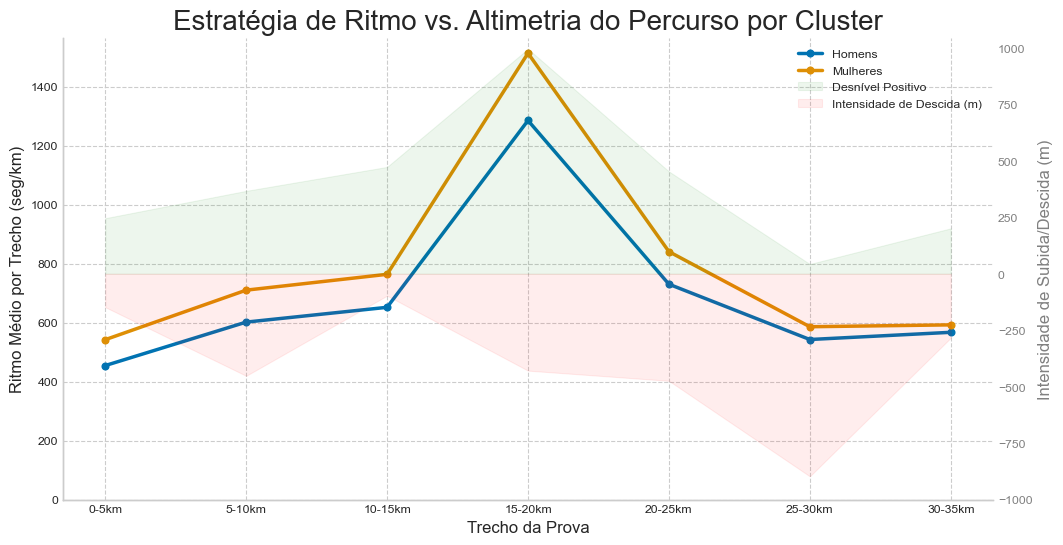

In [131]:
# Crie a figura e o primeiro eixo (para o ritmo)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Pegando apenas as colunas de ritmo por trecho da sua tabela de perfis
colunas_ritmo_trechos = [
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
]
perfis_ritmo_sexo = perfis_sexo[
    colunas_ritmo_trechos
].T  # .T para transpor (facilita o plot)

# Renomeando o √≠ndice para ficar mais claro
perfis_ritmo_sexo.index = [
    "0-5km",
    "5-10km",
    "10-15km",
    "15-20km",
    "20-25km",
    "25-30km",
    "30-35km",
]

# Plote o gr√°fico de linhas do ritmo no primeiro eixo (ax1)
perfis_ritmo_sexo.plot(
    ax=ax1, marker="o", linewidth=2.5, zorder=10
)  # zorder alto para ficar na frente

# Est√©tica do eixo 1 (Ritmo)
ax1.set_title("Estrat√©gia de Ritmo vs. Altimetria do Percurso por Cluster", fontsize=20)
ax1.set_xlabel("Trecho da Prova", fontsize=12)
ax1.set_ylabel("Ritmo M√©dio por Trecho (seg/km)", fontsize=12)
ax1.grid(True, linestyle="--", which="both")
ax1.legend(title="Cluster")
ax1.set_ylim(bottom=0)  # Garante que o eixo Y do ritmo comece no zero

# Crie o segundo eixo (para o desn√≠vel)
ax2 = ax1.twinx()

# Plote o GR√ÅFICO DE √ÅREA do desn√≠vel no segundo eixo (ax2)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_positivo"],
    y2=0,  # Linha base do preenchimento
    color="green",
    alpha=0.07,
    label="Desn√≠vel Positivo",
    zorder=0,  # zorder baixo para ficar no fundo
)

# Est√©tica do eixo 2 (Desn√≠vel)
ax2.set_ylabel("Desn√≠vel Positivo Acumulado (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-100)  # Garante que o eixo Y do desn√≠vel comece no zero

# Plotando a √ÅREA para DESN√çVEL NEGATIVO (Descidas)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_negativo"],
    y2=0,
    color="red",  # Cor diferente para as descidas
    alpha=0.07,
    label="Intensidade de Descida (m)",
    zorder=0,
)

ax2.set_ylabel("Intensidade de Subida/Descida (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-1000)

# Unificar as legendas
lines, labels = ax1.get_legend_handles_labels()
areas, area_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + areas, labels + area_labels, loc="upper right")

plt.show()

## Regress√£o Linear

**Os Pressupostos da Regress√£o Linear M√∫ltipla**
Antes de confiarmos nos resultados de uma regress√£o, precisamos verificar alguns pressupostos. Se eles forem violados, nossas conclus√µes podem ser inv√°lidas. Os principais s√£o:

- Linearidade: A rela√ß√£o entre as vari√°veis independentes (preditoras) e a vari√°vel dependente (alvo) deve ser linear. Podemos fazer uma verifica√ß√£o inicial com gr√°ficos de dispers√£o (scatterplot) entre cada vari√°vel preditora e o Tempo_Final_seg.

- Independ√™ncia dos Res√≠duos: Os res√≠duos (a diferen√ßa entre os valores observados e os previstos pelo modelo) devem ser independentes uns dos outros. Isso √© especialmente importante em dados com estrutura temporal ou espacial. Em seu caso, como cada linha representa um atleta diferente, este pressuposto geralmente √© satisfeito. O teste de Durbin-Watson √© comumente usado para verificar isso.

- Homocedasticidade (Vari√¢ncia Constante dos Res√≠duos): A vari√¢ncia dos res√≠duos deve ser constante para todos os n√≠veis das vari√°veis independentes. Em outras palavras, a dispers√£o dos erros n√£o deve aumentar ou diminuir √† medida que os valores previstos mudam. A viola√ß√£o deste pressuposto chama-se heterocedasticidade. Podemos verificar isso visualmente com um gr√°fico de res√≠duos vs. valores previstos ou com testes estat√≠sticos como o de Breusch-Pagan.

- Normalidade dos Res√≠duos: Os res√≠duos do modelo devem seguir uma distribui√ß√£o normal. Isso √© crucial para a validade dos testes de hip√≥tese (testes t e F) sobre os coeficientes do modelo. Podemos avaliar a normalidade com um histograma dos res√≠duos, um Q-Q Plot ou testes formais como Shapiro-Wilk.

- Aus√™ncia de Multicolinearidade Perfeita: As vari√°veis independentes n√£o devem ser perfeitamente correlacionadas entre si. Uma multicolinearidade alta (n√£o necessariamente perfeita) tamb√©m √© um problema, pois infla a vari√¢ncia dos coeficientes de regress√£o, tornando-os inst√°veis e dif√≠ceis de interpretar. O Fator de Infla√ß√£o de Vari√¢ncia (VIF) √© a m√©trica padr√£o para diagnosticar isso.

#### Prepara√ß√£o dos Dados

Juntando nossas base completa com todos dados em segundos com nossa base onde est√£o nossos clusters

In [132]:
df_geral_segundos = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_geral_segundos = df_geral_segundos.drop(columns=["Unnamed: 0"])
df_geral_segundos.head()

Nome Atleta    sexo faixa_etaria        peso  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Ritmo_Medio_Trecho_35-40_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_5-10_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Tempo_Total_Trecho_35-40_km  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  indice_subida  \
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg            21774       604.833333               290.291331                     4.838189                   667.777778                  541.888889                        12020                        9754                          -2.10                         -37.76                                 -0.19                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                        357.0                     2095.0                      3000.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0                        357.0           522.933333              474.5              335.5          724.117647                 7844                949                671               12310       0.197218   
1             Albert Melo  Homens      25 a 34  75 a 84 kg            31986       888.500000               417.596832                     6.959947                   942.944444                  834.055556                        16973                       15013                          -1.82                         -32.66                                 -0.12                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                        701.0                     2999.0                      4494.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0                        701.0           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583       0.164090   
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg            33826       939.611111               669.719569                    11.161993                   945.388889                  933.833333                        17017                       16809                          -0.20                          -3.47                                 -0.01                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                        271.0                     2541.0                      3471.0                       3740.0                      10132.0                       6423.0                       3588.0                       3660.0                        271.0           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729       0.297721   
3          Alex Junior Aj  Homens

In [133]:
df_cluster2_com_labels.reset_index(inplace=True)
df_cluster2_com_labels.head()

Nome Atleta  Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA  indice_subida  indice_descida_vs_subida  indice_descida  cluster
0       ALFREDO GUIMARAES            21774                   667.777778                  541.888889                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                                 -0.19               290.291331          724.117647           522.933333       0.197218                 -0.277834       -0.135409        0
1             Albert Melo            31986                   942.944444                  834.055556                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                                 -0.12               417.596832         1034.294118           789.933333       0.164090                 -0.236259       -0.110936        2
2  Alessandro Sousa(all√™)            33826                   945.388889                  933.833333                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                                 -0.01               669.719569         1219.352941           745.266667       0.297721                 -0.388802       -0.206835        1
3          Alex Junior Aj            18496                   598.944444                  428.611111                      366.2                       532.2                        568.6                        869.4                        404.2                        445.6                        478.2                                 -0.28               261.647539          619.529412           443.133333       0.205831                 -0.284726       -0.137500        3
4      Alexandre Santiago            14626                   467.722222                  365.117647                      316.6                       413.0                        448.6                        658.6                        313.8                        373.0                        401.6                                 -0.22               195.390826          479.882353           366.466667       0.148358                 -0.236341       -0.123046        3

In [134]:
df_final_com_clusters = pd.merge(
    left=df_geral_segundos,
    right=df_cluster2_com_labels[["Nome Atleta", "cluster"]],
    left_on="Nome Atleta",
    right_on="Nome Atleta",
    how="left",
)
df_final_com_clusters.head()

Nome Atleta    sexo faixa_etaria        peso  Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Ritmo_Medio_Trecho_35-40_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_5-10_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Tempo_Total_Trecho_35-40_km  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  indice_subida  \
0       ALFREDO GUIMARAES  Homens      45 a 54  75 a 84 kg            21774       604.833333               290.291331                     4.838189                   667.777778                  541.888889                        12020                        9754                          -2.10                         -37.76                                 -0.19                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                        357.0                     2095.0                      3000.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0                        357.0           522.933333              474.5              335.5          724.117647                 7844                949                671               12310       0.197218   
1             Albert Melo  Homens      25 a 34  75 a 84 kg            31986       888.500000               417.596832                     6.959947                   942.944444                  834.055556                        16973                       15013                          -1.82                         -32.66                                 -0.12                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                        701.0                     2999.0                      4494.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0                        701.0           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583       0.164090   
2  Alessandro Sousa(all√™)  Homens      45 a 54  65 a 74 kg            33826       939.611111               669.719569                    11.161993                   945.388889                  933.833333                        17017                       16809                          -0.20                          -3.47                                 -0.01                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                        271.0                     2541.0                      3471.0                       3740.0                      10132.0                       6423.0                       3588.0                       3660.0                        271.0           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729       0.297721   
3          Alex Junior Aj  Homens

In [135]:
df_final_com_clusters.isnull().sum()

Nome Atleta                              0
sexo                                     0
faixa_etaria                             0
peso                                     0
Tempo_Final_seg                          0
Ritmo_Medio_seg                          0
Variabilidade_Ritmo_std                  0
Variabilidade_Ritmo_min_std              0
Ritmo_Medio_Primeira_Metade              0
Ritmo_Medio_Segunda_Metade               0
Tempo_Total_Primeira_Metade              0
Tempo_Total_Segunda_Metade               0
Diferenca_Media_Seg_Menos_Pri            0
Diferenca_total_Seg_Menos_Pri            0
diff_relativa_segunda_primeira_parte     0
Ritmo_Medio_Trecho_0-5_km                0
Ritmo_Medio_Trecho_5-10_km               0
Ritmo_Medio_Trecho_10-15_km              0
Ritmo_Medio_Trecho_15-20_km              0
Ritmo_Medio_Trecho_20-25_km              0
Ritmo_Medio_Trecho_25-30_km              0
Ritmo_Medio_Trecho_30-35_km              0
Ritmo_Medio_Trecho_35-40_km             39
Tempo_Total

### Modelagem

Ap√≥s uma detalhada An√°lise Explorat√≥ria de Dados (EDA), a aplica√ß√£o de testes de hip√≥teses e a segmenta√ß√£o de atletas por meio de clusteriza√ß√£o, identificamos as principais vari√°veis que se associam ao desempenho dos corredores. Ficou claro que fatores como sexo, faixa et√°ria, consist√™ncia do ritmo e os perfis de estrat√©gia ("personas") t√™m uma rela√ß√£o significativa com o tempo final de prova.

Nesta se√ß√£o, avan√ßamos da descri√ß√£o para a predi√ß√£o. O objetivo √© construir um modelo de Regress√£o Linear M√∫ltipla para unificar essas descobertas em uma √∫nica estrutura explicativa e quantitativa. Buscaremos n√£o apenas confirmar se uma vari√°vel √© importante, mas tamb√©m medir o tamanho do seu impacto no resultado final, considerando a influ√™ncia simult√¢nea de m√∫ltiplos fatores.

Para isso, adotaremos uma abordagem iterativa, construindo modelos com complexidade crescente. Iniciaremos com um modelo base, utilizando preditores demogr√°ficos e de ritmo. Em seguida, avaliaremos se a adi√ß√£o dos clusters e, posteriormente, dos √≠ndices t√©cnicos (como indice_subida), melhora a capacidade do modelo de explicar a varia√ß√£o no tempo de prova. Essa an√°lise nos permitir√° determinar quais caracter√≠sticas s√£o os preditores mais robustos do desempenho em corridas de montanha.

***Prepara√ß√£o Inicial (Para todos os modelos)***

- Vari√°vel Alvo (Y): Sua vari√°vel dependente ser√° o Tempo_Final_seg.

- Limpeza de Colunas: A coluna Ritmo_Medio_Trecho_35-40_km possui muitos valores faltantes. Como ela n√£o √© central para a an√°lise agregada, o ideal √© remov√™-la para n√£o perder atletas.

- Vari√°veis Categ√≥ricas: Vamos transformar sexo, faixa_etaria e peso em vari√°veis num√©ricas usando One-Hot Encoding (pd.get_dummies).

In [136]:
# Supondo que seu dataframe se chama 'df'
df_modelo = df_final_com_clusters.copy()
df_modelo["cluster"] = df_modelo["cluster"].astype("category")

# 1. Prepara√ß√£o
# Remover colunas com muitos NaNs ou que n√£o ser√£o usadas
df_modelo = df_modelo.drop(
    columns=[
        "Ritmo_Medio_Trecho_35-40_km",
        "Tempo_Total_Trecho_35-40_km",
        "Nome Atleta",
    ]
)

df_modelo_dummies = pd.get_dummies(df_modelo, drop_first=True)
for col in df_modelo_dummies.columns:
    if df_modelo_dummies[col].dtype == "bool":
        df_modelo_dummies[col] = df_modelo_dummies[col].astype(int)

df_modelo_dummies.head()

Tempo_Final_seg  Ritmo_Medio_seg  Variabilidade_Ritmo_std  Variabilidade_Ritmo_min_std  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Tempo_Total_Primeira_Metade  Tempo_Total_Segunda_Metade  Diferenca_Media_Seg_Menos_Pri  Diferenca_total_Seg_Menos_Pri  diff_relativa_segunda_primeira_parte  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  Tempo_Total_Trecho_0-5_km  Tempo_Total_Trecho_5-10_km  Tempo_Total_Trecho_10-15_km  Tempo_Total_Trecho_15-20_km  Tempo_Total_Trecho_20-25_km  Tempo_Total_Trecho_25-30_km  Tempo_Total_Trecho_30-35_km  Ritmo_Medio_DESCIDA  Ritmo_Medio_MISTO  Ritmo_Medio_PLANO  Ritmo_Medio_SUBIDA  Tempo_Total_DESCIDA  Tempo_Total_MISTO  Tempo_Total_PLANO  Tempo_Total_SUBIDA  indice_subida  indice_descida_vs_subida  indice_descida  sexo_Mulheres  faixa_etaria_25 a 34  faixa_etaria_35 a 44  \
0            21774       604.833333               290.291331                     4.838189                   667.777778                  541.888889                        12020                        9754                          -2.10                         -37.76                                 -0.19                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                     2095.0                      3000.0                       3174.0                       4915.0                       2477.0                       2699.0                       3057.0           522.933333              474.5              335.5          724.117647                 7844                949                671               12310       0.197218                 -0.277834       -0.135409              0                     0                     0   
1            31986       888.500000               417.596832                     6.959947                   942.944444                  834.055556                        16973                       15013                          -1.82                         -32.66                                 -0.12                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                     2999.0                      4494.0                       4127.0                       7214.0                       3687.0                       4125.0                       4639.0           789.933333              742.0              535.0         1034.294118                11849               1484               1070               17583       0.164090                 -0.236259       -0.110936              0                     1                     0   
2            33826       939.611111               669.719569                    11.161993                   945.388889                  933.833333                        17017                       16809                          -0.20                          -3.47                                 -0.01                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                     2541.0                      3471.0                       3740.0                      10132.0                       6423.0                       3588.0                       3660.0           745.266667              628.0              331.0         1219.352941                11179               1256                662               20729       0.297721                 -0.388802       -0.206835              0                     0                     0   
3            18496       513.777778               261.647539                   

#### Modelo Base - Ponto de Partida

Vamos criar um modelo mais simples para servir como ponto de partida.

 - *Objetivo*: Quantificar o impacto dos fatores demogr√°ficos e da consist√™ncia do ritmo, que sua an√°lise explorat√≥ria e testes de hip√≥teses j√° mostraram ser cruciais.

**Vari√°veis Preditoras (X):**

> *Variabilidade_Ritmo_std*: A an√°lise de correla√ß√£o mostrou que √© um forte candidato.
>
> *sexo*: O teste de Mann-Whitney U foi significativo.
>
> *faixa_etaria*: O Kruskal-Wallis indicou diferen√ßas.
>
> *cluster*: A clusteriza√ß√£o criou perfis de performance distintos, o que a torna uma vari√°vel preditora potencialmente poderosa.
>
> *indice_subida* e *indice_descid*: Estes √≠ndices que voc√™ criou parecem capturar a especialidade do atleta, o que √© um insight fant√°stico.    

Selecionando Vari√°veis que vamos usar

In [137]:
print(df_modelo_dummies.columns)

Index(['Tempo_Final_seg', 'Ritmo_Medio_seg', 'Variabilidade_Ritmo_std', 'Variabilidade_Ritmo_min_std', 'Ritmo_Medio_Primeira_Metade', 'Ritmo_Medio_Segunda_Metade', 'Tempo_Total_Primeira_Metade', 'Tempo_Total_Segunda_Metade', 'Diferenca_Media_Seg_Menos_Pri', 'Diferenca_total_Seg_Menos_Pri', 'diff_relativa_segunda_primeira_parte', 'Ritmo_Medio_Trecho_0-5_km', 'Ritmo_Medio_Trecho_5-10_km', 'Ritmo_Medio_Trecho_10-15_km', 'Ritmo_Medio_Trecho_15-20_km', 'Ritmo_Medio_Trecho_20-25_km', 'Ritmo_Medio_Trecho_25-30_km', 'Ritmo_Medio_Trecho_30-35_km', 'Tempo_Total_Trecho_0-5_km', 'Tempo_Total_Trecho_5-10_km', 'Tempo_Total_Trecho_10-15_km', 'Tempo_Total_Trecho_15-20_km', 'Tempo_Total_Trecho_20-25_km', 'Tempo_Total_Trecho_25-30_km', 'Tempo_Total_Trecho_30-35_km', 'Ritmo_Medio_DESCIDA', 'Ritmo_Medio_MISTO', 'Ritmo_Medio_PLANO', 'Ritmo_Medio_SUBIDA', 'Tempo_Total_DESCIDA', 'Tempo_Total_MISTO', 'Tempo_Total_PLANO', 'Tempo_Total_SUBIDA', 'indice_subida', 'indice_descida_vs_subida', 'indice_descida',
    

In [138]:
# Vari√°vel Alvo e Preditoras
y = df_modelo_dummies["Tempo_Final_seg"]
X1 = df_modelo_dummies[
    [
        "Variabilidade_Ritmo_std",
        "sexo_Mulheres",
        "faixa_etaria_25 a 34",
        "faixa_etaria_35 a 44",
        "faixa_etaria_45 a 54",
        "faixa_etaria_55 a 64",
        "cluster_1",
        "cluster_2",
        "cluster_3",
        "indice_subida",
        "indice_descida",
    ]
]

Treinando Modelo

In [139]:
# Adicionar uma constante (intercepto) ao modelo
X_inicial = sm.add_constant(X1)
X_inicial.head()

const  Variabilidade_Ritmo_std  sexo_Mulheres  faixa_etaria_25 a 34  faixa_etaria_35 a 44  faixa_etaria_45 a 54  faixa_etaria_55 a 64  cluster_1  cluster_2  cluster_3  indice_subida  indice_descida
0    1.0               290.291331              0                     0                     0                     1                     0          0          0          0       0.197218       -0.135409
1    1.0               417.596832              0                     1                     0                     0                     0          0          1          0       0.164090       -0.110936
2    1.0               669.719569              0                     0                     0                     1                     0          1          0          0       0.297721       -0.206835
3    1.0               261.647539              0                     0                     0                     0                     0          0          0          1       0.205831       -0.137500
4    1.0               195.390826              0                     0                     1                     0                     0          0          0          1       0.148358       -0.123046

In [140]:
print(X_inicial.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   const                    109 non-null    float64
 1   Variabilidade_Ritmo_std  109 non-null    float64
 2   sexo_Mulheres            109 non-null    int64  
 3   faixa_etaria_25 a 34     109 non-null    int64  
 4   faixa_etaria_35 a 44     109 non-null    int64  
 5   faixa_etaria_45 a 54     109 non-null    int64  
 6   faixa_etaria_55 a 64     109 non-null    int64  
 7   cluster_1                109 non-null    int64  
 8   cluster_2                109 non-null    int64  
 9   cluster_3                109 non-null    int64  
 10  indice_subida            109 non-null    float64
 11  indice_descida           109 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 10.3 KB
None


In [141]:
# Rodar o modelo
modelo_final = sm.OLS(y, X_inicial).fit()

print("\n----------------------------------------------------")
print("‚úÖ MODELO AJUSTADO COM SUCESSO! RESULTADO ABAIXO:")
print("----------------------------------------------------")
print(modelo_final.summary())


----------------------------------------------------
‚úÖ MODELO AJUSTADO COM SUCESSO! RESULTADO ABAIXO:
----------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     195.5
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           4.87e-61
Time:                        23:04:43   Log-Likelihood:                -953.65
No. Observations:                 109   AIC:                             1931.
Df Residuals:                      97   BIC:                             1964.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err       

**1. Vis√£o Geral do Modelo: Qu√£o bom ele √©? üéØ**
> R-squared (R¬≤): 0.957 e Adj. R-squared: 0.952

* **Interpreta√ß√£o**: Extraordin√°rio! O seu modelo explica 95.2% da varia√ß√£o no tempo final dos atletas. Este √© um valor excepcionalmente alto e indica que as vari√°veis que voc√™ escolheu t√™m um poder preditivo muito forte. Para um estudo em ci√™ncias do esporte, um resultado como este √© fant√°stico.

* **F-statistic**: 195.5 e Prob (F-statistic): 4.87e-61

* **Interpreta√ß√£o:** O p-valor do Teste F √© praticamente zero. Isso significa que o modelo como um todo √© altamente significativo. Rejeitamos a hip√≥tese de que todos os coeficientes s√£o zero. Em outras palavras, o seu modelo √© muito melhor para prever o tempo final do que simplesmente usar a m√©dia geral.

* **Conclus√£o Parcial**: No geral, o modelo tem um ajuste excelente aos dados.

**2. An√°lise dos Coeficientes: O que Realmente Influencia o Tempo? üèÉ‚Äç‚ôÇÔ∏è**
Esta √© a parte principal. Vamos olhar para cada vari√°vel e seu p-valor (P>|t|) para ver se ela √© estatisticamente significante (geralmente, p < 0.05).

    **Vari√°veis Significantes:**

> **Variabilidade_Ritmo_std (*coef = 24.47, p = 0.000*):**

- **Interpreta√ß√£o**: Esta √© uma das suas vari√°veis mais importantes. Para cada 1 segundo de aumento no desvio padr√£o do ritmo (maior variabilidade), o tempo final de prova aumenta, em m√©dia, 24.5 segundos, mantendo todas as outras vari√°veis constantes. Isso quantifica brilhantemente o que voc√™ j√° sabia: a consist√™ncia √© um fator crucial para o desempenho.

> **cluster_3 (A Elite) (*coef = -2985.6, p = 0.000*):**

- **Interpreta√ß√£o**: Ser do Cluster 3 (a elite), em compara√ß√£o com o grupo de refer√™ncia (Cluster 0, "Os Escaladores"), est√° associado a uma redu√ß√£o de 2986 segundos (aprox. 50 minutos) no tempo de prova. Isso confirma que este grupo est√° em um n√≠vel de performance completamente diferente.

> **cluster_2 (Guerreiros Resistentes) (*coef = 5091.5, p = 0.000*):**

- **Interpreta√ß√£o**: Pertencer ao Cluster 2, em compara√ß√£o com o Cluster 0, est√° associado a um aumento de 5091 segundos (aprox. 85 minutos) no tempo de prova.

> **cluster_1 (Especialistas em Descida) (*coef = 1761.0, p = 0.011*):**

- **Interpreta√ß√£o**: Ser do Cluster 1, em compara√ß√£o com o Cluster 0, est√° associado a um aumento de 1761 segundos (aprox. 29 minutos) no tempo de prova. Sua an√°lise de cluster provou ser uma vari√°vel preditora extremamente poderosa.

> **sexo_Mulheres (*coef = 754.8, p = 0.050*):**

- **Interpreta√ß√£o**: As mulheres, em m√©dia, levam cerca de 755 segundos (aprox. 12.5 minutos) a mais que os homens, ap√≥s controlar por todas as outras vari√°veis. Com um p-valor de exatamente 0.050, esta vari√°vel √© considerada marginalmente significativa.

    **Vari√°veis N√£o Significantes:**

**faixa_etaria_... (todos os *p-valores > 0.7*):**

- **Interpreta√ß√£o**: Nenhuma das faixas et√°rias teve um efeito estatisticamente significativo sobre o tempo final depois que controlamos pela variabilidade e, principalmente, pelo cluster de performance. Isso √© muito interessante! Sugere que o perfil de atleta (cluster) √© mais importante do que a idade em si. A idade provavelmente j√° est√° embutida na defini√ß√£o dos clusters.

> **indice_subida e indice_descida (*p-valores > 0.2*):**

- **Interpreta√ß√£o**: Surpreendentemente, os seus excelentes √≠ndices de habilidade em subida/descida n√£o foram significantes. Por qu√™? A resposta est√° no diagn√≥stico abaixo.

**3. Diagn√≥stico do Modelo e Pr√≥ximos Passos ü©∫**
A parte inferior da tabela nos ajuda a verificar os pressupostos e a encontrar problemas.

> **Prob(Omnibus): 0.014 e Prob(JB): 0.0156**

- **Diagn√≥stico**: Ambos os testes t√™m p-valor < 0.05. Isso indica que os res√≠duos do modelo n√£o seguem uma distribui√ß√£o normal, o que viola um dos pressupostos. Isso pode afetar a confiabilidade dos p-valores, mas com um R¬≤ t√£o alto, as conclus√µes principais provavelmente se mant√™m.

> **Cond. No. (N√∫mero de Condi√ß√£o): 3.06e+04 e a Nota [2]**

- **Diagn√≥stico**: Este √© o nosso alerta vermelho üö®. A nota diz: "O n√∫mero de condi√ß√£o √© grande... Isso pode indicar que h√° forte multicolinearidade".

**O que √© Multicolinearidade? Significa que algumas de suas vari√°veis preditoras est√£o altamente correlacionadas entre si. Por exemplo, √© prov√°vel que o indice_subida esteja correlacionado com o cluster (o cluster dos "Escaladores" deve ter um bom √≠ndice de subida). Quando isso acontece, o modelo n√£o consegue separar o efeito individual de cada vari√°vel, o que infla os erros padr√£o e faz com que vari√°veis potencialmente importantes (como seus √≠ndices) pare√ßam n√£o significantes.**

#### Otimizando Modelo

Plano de A√ß√£o para Refinar o Modelo (Modelo Robusto):
O modelo atual √© excelente, mas a multicolinearidade o torna um pouco "inchado" e dif√≠cil de interpretar. Vamos criar um modelo mais parcimonioso (mais simples e robusto).

Remover Vari√°veis N√£o Significantes (Backward Elimination): A abordagem mais cl√°ssica √© remover, uma por uma, as vari√°veis com o maior p-valor (acima de 0.05) e reajustar o modelo a cada passo.

Comece removendo a faixa_etaria_55 a 64 (p = 0.919).

Reajuste o modelo.

Continue removendo a pr√≥xima vari√°vel com o maior p-valor (provavelmente outra faixa et√°ria) at√© que restem apenas vari√°veis significantes.

Verificar VIF (Fator de Infla√ß√£o de Vari√¢ncia): Uma abordagem mais direta para a multicolinearidade √© calcular o VIF para cada vari√°vel. Vari√°veis com VIF > 5 (ou 10) s√£o candidatas a serem removidas.

In [142]:
# --- REFINAMENTO DO MODELO: PASSO 1 ---

# A lista de preditoras original tinha 11 vari√°veis.
# Vamos remover 'faixa_etaria_55 a 64', que teve o maior p-valor (0.919).

colunas_refinadas_1 = [
    "Variabilidade_Ritmo_std",
    "sexo_Mulheres",
    "faixa_etaria_25 a 34",
    "faixa_etaria_35 a 44",
    "faixa_etaria_45 a 54",
    # "faixa_etaria_55 a 64" REMOVIDA
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "indice_subida",
    "indice_descida",
]

# Usamos o mesmo DataFrame limpo da etapa anterior (df_para_modelo)
y = df_modelo_dummies["Tempo_Final_seg"]
X_refinado1 = df_modelo_dummies[colunas_refinadas_1]

# Adicionar a constante e rodar o novo modelo
X_refinado1 = sm.add_constant(X_refinado1)
modelo_refinado_1 = sm.OLS(y, X_refinado1).fit()

# Analisar o novo resumo
print("--- MODELO REFINADO (1¬™ Rodada de Elimina√ß√£o) ---")
print(modelo_refinado_1.summary())

--- MODELO REFINADO (1¬™ Rodada de Elimina√ß√£o) ---
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     217.3
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           3.23e-62
Time:                        23:04:43   Log-Likelihood:                -953.66
No. Observations:                 109   AIC:                             1929.
Df Residuals:                      98   BIC:                             1959.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [143]:
# --- REFINAMENTO DO MODELO: PASSO 1 ---

# A lista de preditoras original tinha 11 vari√°veis.
# Vamos remover 'faixa_etaria_55 a 64', que teve o maior p-valor (0.919).

colunas_refinadas_1 = [
    "Variabilidade_Ritmo_std",
    "sexo_Mulheres",  # "faixa_etaria_25 a 34",
    "faixa_etaria_35 a 44",
    "faixa_etaria_45 a 54",
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "indice_subida",
    "indice_descida",
]

# Usamos o mesmo DataFrame limpo da etapa anterior (df_para_modelo)
y = df_modelo_dummies["Tempo_Final_seg"]
X_refinado1 = df_modelo_dummies[colunas_refinadas_1]

# Adicionar a constante e rodar o novo modelo
X_refinado1 = sm.add_constant(X_refinado1)
modelo_refinado_1 = sm.OLS(y, X_refinado1).fit()

# Analisar o novo resumo
print("--- MODELO REFINADO (2¬™ Rodada de Elimina√ß√£o) ---")
print(modelo_refinado_1.summary())

--- MODELO REFINADO (2¬™ Rodada de Elimina√ß√£o) ---
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     243.6
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           2.13e-63
Time:                        23:04:43   Log-Likelihood:                -953.72
No. Observations:                 109   AIC:                             1927.
Df Residuals:                      99   BIC:                             1954.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

O mais interessante aconteceu agora: ao remover a segunda vari√°vel de idade, o Adj. R-squared subiu de 0.952 para 0.953! ‚úÖ

Isso √© o melhor cen√°rio poss√≠vel no refinamento de um modelo. Significa que n√£o apenas removemos uma vari√°vel in√∫til, mas que a sua remo√ß√£o tornou o modelo ligeiramente mais preciso e eficiente. Estamos trocando complexidade por poder explicativo, o que √© o objetivo da parcim√¥nia.

In [144]:
# --- REFINAMENTO DO MODELO: PASSO 3 ---

# Agora removemos 'faixa_etaria_35 a 44' (p=0.785).

colunas_refinadas_3 = [
    "Variabilidade_Ritmo_std",
    "sexo_Mulheres",
    # "faixa_etaria_35 a 44" REMOVIDA
    "faixa_etaria_45 a 54",
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "indice_subida",
    "indice_descida",
]

# Usamos o mesmo DataFrame limpo (df_para_modelo)
y = df_modelo_dummies["Tempo_Final_seg"]
X_refinado3 = df_modelo_dummies[colunas_refinadas_3]


# Adicionar a constante e rodar o novo modelo
X_refinado3 = sm.add_constant(X_refinado3)
modelo_refinado_3 = sm.OLS(y, X_refinado3).fit()

# Analisar o novo resumo
print("--- MODELO REFINADO (3¬™ Rodada de Elimina√ß√£o) ---")
print(modelo_refinado_3.summary())

--- MODELO REFINADO (3¬™ Rodada de Elimina√ß√£o) ---
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     276.6
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           1.28e-64
Time:                        23:04:44   Log-Likelihood:                -953.76
No. Observations:                 109   AIC:                             1926.
Df Residuals:                     100   BIC:                             1950.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [145]:
# --- REFINAMENTO DO MODELO: PASSO 4 ---

# Agora removemos 'faixa_etaria_45 a 54' (p=0.857).

colunas_refinadas_4 = [
    "Variabilidade_Ritmo_std",
    "sexo_Mulheres",
    # "faixa_etaria_45 a 54" REMOVIDA
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "indice_subida",
    "indice_descida",
]

# Usamos o mesmo DataFrame limpo (df_para_modelo)
y = df_modelo_dummies["Tempo_Final_seg"]
X_refinado4 = df_modelo_dummies[colunas_refinadas_4]

# Adicionar a constante e rodar o novo modelo
X_refinado4 = sm.add_constant(X_refinado4)
modelo_refinado_4 = sm.OLS(y, X_refinado4).fit()

# Analisar o novo resumo
print("--- MODELO REFINADO (4¬™ Rodada de Elimina√ß√£o) ---")
print(modelo_refinado_4.summary())

--- MODELO REFINADO (4¬™ Rodada de Elimina√ß√£o) ---
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     319.1
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           7.02e-66
Time:                        23:04:44   Log-Likelihood:                -953.78
No. Observations:                 109   AIC:                             1924.
Df Residuals:                     101   BIC:                             1945.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [146]:
# --- REFINAMENTO DO MODELO: PASSO 4 ---

# Agora removemos 'faixa_etaria_45 a 54' (p=0.857).

colunas_refinadas_4 = [
    "Variabilidade_Ritmo_std",
    "sexo_Mulheres",
    # "faixa_etaria_45 a 54" REMOVIDA
    "cluster_1",
    "cluster_2",
    "cluster_3",
]

# Usamos o mesmo DataFrame limpo (df_para_modelo)
y = df_modelo_dummies["Tempo_Final_seg"]
X_refinado4 = df_modelo_dummies[colunas_refinadas_4]

# Adicionar a constante e rodar o novo modelo
X_refinado4 = sm.add_constant(X_refinado4)
modelo_refinado_4 = sm.OLS(y, X_refinado4).fit()

# Analisar o novo resumo
print("--- MODELO REFINADO (5¬™ Rodada de Elimina√ß√£o) ---")
print(modelo_refinado_4.summary())

--- MODELO REFINADO (5¬™ Rodada de Elimina√ß√£o) ---
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     448.9
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           3.21e-68
Time:                        23:04:44   Log-Likelihood:                -954.56
No. Observations:                 109   AIC:                             1921.
Df Residuals:                     103   BIC:                             1937.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [147]:
# --- REFINAMENTO DO MODELO: PASSO 5 ---
# Agora removemos sexo_mulheres (p=0.088).

colunas_refinadas_5 = [
    "Variabilidade_Ritmo_std",
    "cluster_1",
    "cluster_2",
    "cluster_3",
]

# Usamos o mesmo DataFrame limpo (df_para_modelo)
y = df_modelo_dummies["Tempo_Final_seg"]
X_final = df_modelo_dummies[colunas_refinadas_5]

# Adicionar a constante e rodar o novo modelo
X_final = sm.add_constant(X_final)
modelo_final = sm.OLS(y, X_final).fit()

# Analisar o novo resumo
print("--- MODELO REFINADO (6¬™ Rodada de Elimina√ß√£o) ---")
print(modelo_final.summary())


--- MODELO REFINADO (6¬™ Rodada de Elimina√ß√£o) ---
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     549.9
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           5.55e-69
Time:                        23:04:44   Log-Likelihood:                -956.11
No. Observations:                 109   AIC:                             1922.
Df Residuals:                     104   BIC:                             1936.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

Este modelo final conta uma hist√≥ria clara e poderosa sobre o que determina o desempenho na prova. Ele revela que a performance pode ser explicada fundamentalmente por dois pilares: a consist√™ncia do atleta e o seu perfil geral de performance.

Os Dois Pilares do Desempenho
**Consist√™ncia √© Rei (Variabilidade_Ritmo_std):**

>> Coeficiente: 24.25

- **Interpreta√ß√£o**: Esta √© a regra de ouro do seu estudo. Para cada 1 segundo de aumento na oscila√ß√£o do ritmo (desvio padr√£o), o tempo final de prova aumenta, em m√©dia, em 24,25 segundos. Essa √© uma penalidade alt√≠ssima por falta de consist√™ncia e um dos achados mais fortes do seu trabalho.

**O Perfil do Atleta √© Decisivo (cluster):**

- **Interpreta√ß√£o**: A sua clusteriza√ß√£o capturou a ess√™ncia do que separa os atletas. Usando o Cluster 0 ("Os Escaladores") como ponto de refer√™ncia:

> **Cluster 3 ("A Elite")**: S√£o, em m√©dia, 3190 segundos (aprox. 53 minutos) mais r√°pidos. O coeficiente negativo (-3189.9) confirma seu status de elite.

> **Cluster 1 ("Especialistas em Descida")**: S√£o, em m√©dia, 1497 segundos (aprox. 25 minutos) mais lentos.

> **Cluster 2 ("Guerreiros Resistentes"):** S√£o, em m√©dia, 5048 segundos (aprox. 84 minutos) mais lentos.

Este modelo final √© elegante porque resume toda a complexidade da prova em quatro preditores claros e quantific√°veis.

#### Pressuspostos

In [148]:
# 3. Multicolinearidade (VIF) - VERS√ÉO CORRIGIDA
# O c√°lculo √© feito no DataFrame ANTES de adicionar a constante ('const')
vif_data = pd.DataFrame()
vif_data["feature"] = X_final.columns.drop(
    "const"
)  # Removido para funcionar corretamente
# N√≥s removemos a constante ANTES de chamar o VIF
X_sem_constante = X_final.drop("const", axis=1)
vif_data["VIF"] = [
    variance_inflation_factor(X_sem_constante.values, i)
    for i in range(X_sem_constante.shape[1])
]

print("\nFator de Infla√ß√£o de Vari√¢ncia (VIF) do Modelo Final:")
print(vif_data)


Fator de Infla√ß√£o de Vari√¢ncia (VIF) do Modelo Final:
                   feature       VIF
0  Variabilidade_Ritmo_std  5.257312
1                cluster_1  2.822791
2                cluster_2  2.927205
3                cluster_3  1.507316


O processo de elimina√ß√£o foi altamente bem-sucedido em mitigar a multicolinearidade, que antes era severa (Cond. No. > 30.000). O VIF de 5.26 √© aceit√°vel e tem uma explica√ß√£o l√≥gica: a consist√™ncia do ritmo (Variabilidade_Ritmo_std) √© um dos fatores que definem os perfis de performance (cluster), portanto, uma correla√ß√£o moderada entre eles √© esperada. O problema n√£o √© mais considerado severo e os coeficientes do modelo s√£o interpret√°veis.

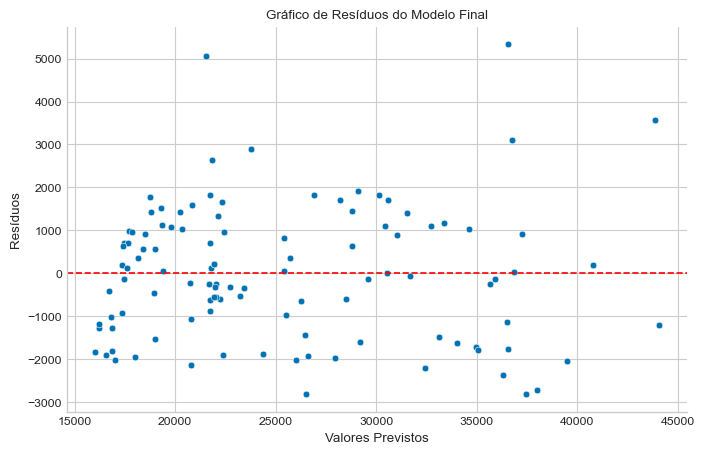

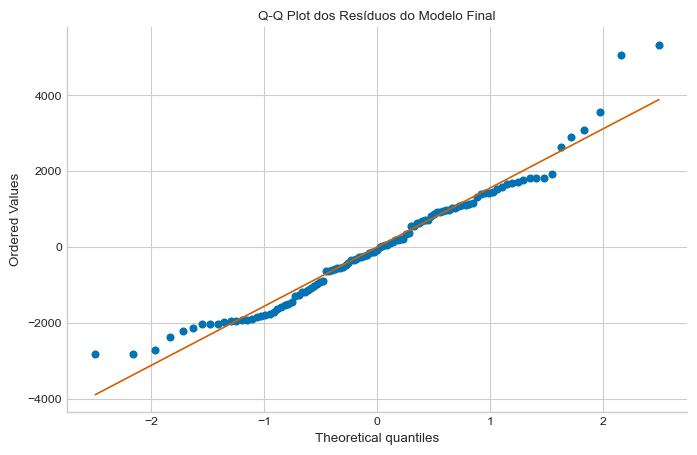

In [149]:
# Extrair res√≠duos e valores previstos do modelo_final
residuos_finais = modelo_final.resid
valores_previstos_finais = modelo_final.predict(X_final)

# 1. Linearidade e Homocedasticidade (Gr√°fico de Res√≠duos)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=valores_previstos_finais, y=residuos_finais)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Previstos")
plt.ylabel("Res√≠duos")
plt.title("Gr√°fico de Res√≠duos do Modelo Final")
plt.show()

# 2. Normalidade dos Res√≠duos (Q-Q Plot)
plt.figure(figsize=(8, 5))
stats.probplot(residuos_finais, dist="norm", plot=plt)
plt.title("Q-Q Plot dos Res√≠duos do Modelo Final")
plt.show()

1. Linearidade e Homocedasticidade (Gr√°fico de Res√≠duos vs. Valores Previstos)
- Evid√™ncia: O gr√°fico de dispers√£o dos res√≠duos versus os valores previstos pelo modelo.

- An√°lise: Observa-se uma nuvem de pontos distribu√≠da de forma aleat√≥ria em torno da linha horizontal em y=0. N√£o h√° padr√µes discern√≠veis, como uma curva (o que indicaria problemas de linearidade) ou um funil (o que indicaria heteroscedasticidade, ou seja, a vari√¢ncia dos erros n√£o √© constante).

- Conclus√£o: Os pressupostos de linearidade e homocedasticidade foram satisfeitos de maneira adequada.

2. Normalidade dos Res√≠duos (Q-Q Plot)
- Evid√™ncia: O gr√°fico Q-Q (Quantil-Quantil) dos res√≠duos.

- An√°lise: O gr√°fico compara os quantis dos res√≠duos do modelo com os quantis de uma distribui√ß√£o normal te√≥rica. Nota-se que, embora os pontos centrais se alinhem bem com a linha diagonal vermelha, h√° um desvio claro nas caudas. Os pontos nas extremidades (valores muito altos ou muito baixos) se afastam da linha, indicando que o modelo possui mais erros extremos (outliers) do que o esperado em uma distribui√ß√£o normal perfeita.

- Conclus√£o: O pressuposto de normalidade dos res√≠duos foi violado. Este resultado visual confirma os p-valores baixos dos testes de Omnibus e Jarque-Bera no sum√°rio do modelo.

3. Independ√™ncia dos Res√≠duos (Durbin-Watson):

- Durbin-Watson: 1.981

- Como Interpretar e Escrever: "O teste de Durbin-Watson resultou em um valor de 1.981, muito pr√≥ximo de 2, indicando a aus√™ncia de autocorrela√ß√£o de primeira ordem nos res√≠duos. O pressuposto de independ√™ncia dos erros foi, portanto, atendido."

## Gr√°ficos TCC.

In [150]:
df_cluster2 = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")

features_para_cluster = [
    "Nome Atleta",
    "Tempo_Final_seg",
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
    "indice_subida",
    "indice_descida_vs_subida",
    "indice_descida",
]

# Criando um novo DataFrame apenas com as features selecionadas e sem dados faltantes
df_cluster2 = df_cluster2[features_para_cluster].dropna()
df_cluster2.head()

Nome Atleta  Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA  indice_subida  indice_descida_vs_subida  indice_descida
0       ALFREDO GUIMARAES            21774                   667.777778                  541.888889                      419.0                       600.0                        634.8                        983.0                        495.4                        539.8                        611.4                                 -0.19               290.291331          724.117647           522.933333       0.197218                 -0.277834       -0.135409
1             Albert Melo            31986                   942.944444                  834.055556                      599.8                       898.8                        825.4                       1442.8                        737.4                        825.0                        927.8                                 -0.12               417.596832         1034.294118           789.933333       0.164090                 -0.236259       -0.110936
2  Alessandro Sousa(all√™)            33826                   945.388889                  933.833333                      508.2                       694.2                        748.0                       2026.4                       1284.6                        717.6                        732.0                                 -0.01               669.719569         1219.352941           745.266667       0.297721                 -0.388802       -0.206835
3          Alex Junior Aj            18496                   598.944444                  428.611111                      366.2                       532.2                        568.6                        869.4                        404.2                        445.6                        478.2                                 -0.28               261.647539          619.529412           443.133333       0.205831                 -0.284726       -0.137500
4      Alexandre Santiago            14626                   467.722222                  365.117647                      316.6                       413.0                        448.6                        658.6                        313.8                        373.0                        401.6                                 -0.22               195.390826          479.882353           366.466667       0.148358                 -0.236341       -0.123046

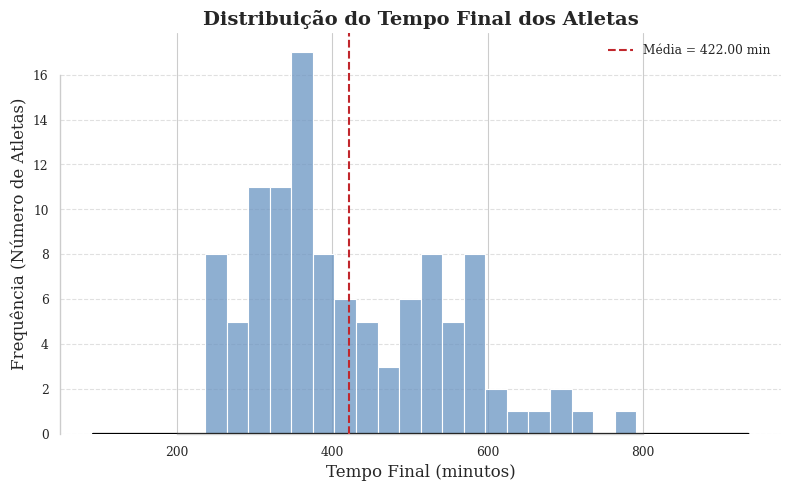

In [151]:
# Supondo que 'df_agregado_por_atleta' j√° foi carregado e preparado

# --- Bloco de Estilo para TCC (COLE AQUI O BLOCO ACIMA) ---
sns.set_theme(style="whitegrid", context="paper", palette="colorblind")
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# ---------------------------------------------------------

# 2. Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(8, 5))

# 3. Plotar o histograma e a linha de densidade (KDE)
sns.histplot(
    data=df_agregado_por_atleta,  # Use seu DataFrame aqui
    x="Tempo_Final_min",
    kde=False,
    bins=20,
    color="#6994c2",
    edgecolor="white",
    ax=ax,
)
sns.kdeplot(
    data=df_agregado_por_atleta,  # E aqui tamb√©m
    x="Tempo_Final_min",
    color="black",
    linewidth=1.5,
    ax=ax,
)

# 4. Adicionar linha vertical com o valor da m√©dia
media_tempo = df_agregado_por_atleta["Tempo_Final_min"].mean()
ax.axvline(
    x=media_tempo,
    color="#c1272d",
    linestyle="--",
    linewidth=1.5,
    label=f"M√©dia = {media_tempo:.2f} min",
)

# 5. Configurar t√≠tulos, r√≥tulos e legendas
ax.set_title("Distribui√ß√£o do Tempo Final dos Atletas", fontsize=14, fontweight="bold")
ax.set_xlabel("Tempo Final (minutos)", fontsize=12)
ax.set_ylabel("Frequ√™ncia (N√∫mero de Atletas)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.legend()

# 6. Limpar o visual do gr√°fico removendo bordas desnecess√°rias
sns.despine(ax=ax, trim=True)

# 7. Ajustar layout e salvar em alta resolu√ß√£o
plt.tight_layout()

# Salva a figura em alta resolu√ß√£o para o TCC
# O bbox_inches='tight' remove excesso de margem branca.
plt.savefig(
    r"Escrita\Projeto_TCC_FINAL\Imagens\distribuicao_tempo_final.png",
    dpi=300,
    bbox_inches="tight",
)

# Exibe o gr√°fico no notebook
plt.show()

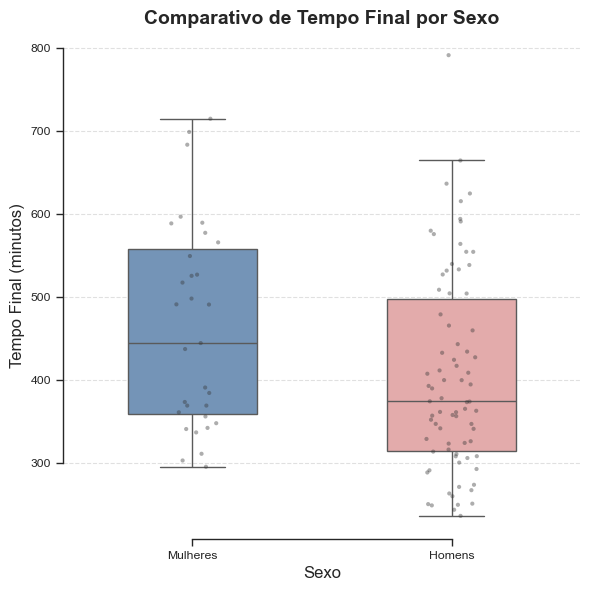

In [152]:
# 1. Definir o tema visual
sns.set_theme(style="ticks", context="paper")

# 2. Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(6, 6))

# 3. Plotar os boxplots com a sintaxe atualizada do Seaborn
sns.boxplot(
    data=df_agregado_por_atleta,
    x="sexo",
    y="Tempo_Final_min",
    order=["Mulheres", "Homens"],
    palette=["#eda1a1", "#6994c2"],
    hue="sexo",  # CORRIGIDO: Adicionado para seguir a nova sintaxe
    legend=False,  # CORRIGIDO: Adicionado para remover legenda redundante
    width=0.5,
    fliersize=0,
    ax=ax,
)

# 4. Sobrepor os pontos individuais (tamb√©m atualizado)
sns.stripplot(
    data=df_agregado_por_atleta,
    x="sexo",
    y="Tempo_Final_min",
    order=["Mulheres", "Homens"],
    hue="sexo",  # CORRIGIDO: Adicionado para consist√™ncia
    palette=["#333333", "#333333"],  # Cor escura para os pontos
    legend=False,  # CORRIGIDO: Adicionado
    size=3,
    alpha=0.4,
    ax=ax,
)

# 5. Configurar t√≠tulos e r√≥tulos
ax.set_title("Comparativo de Tempo Final por Sexo", fontsize=14, fontweight="bold")
ax.set_xlabel("Sexo", fontsize=12)
ax.set_ylabel("Tempo Final (minutos)", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# 6. Limpar o visual do gr√°fico
sns.despine(ax=ax, trim=True)

# 7. Ajustar layout e salvar em alta resolu√ß√£o
plt.tight_layout()
plt.savefig(r"Escrita\Projeto_TCC_FINAL\Imagens\boxplot_tempo_por_sexo.png", dpi=300)
plt.show()

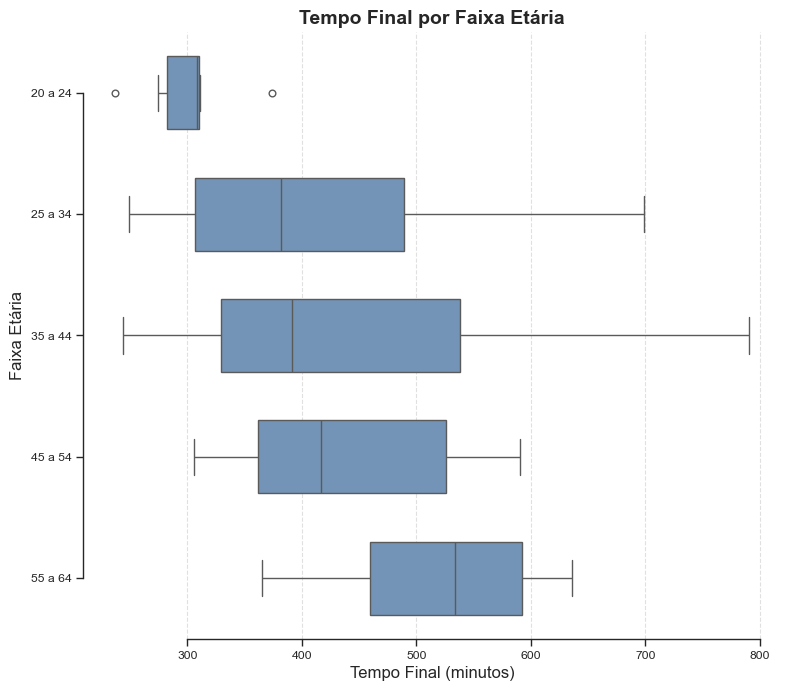

In [153]:
# 1. Definir o tema visual
sns.set_theme(style="ticks", context="paper")

# 2. Criar a figura e os eixos
# Ajustamos o figsize para um layout mais vertical
fig, ax = plt.subplots(figsize=(8, 7))

# 3. Definir a ordem das categorias (sua l√≥gica original est√° √≥tima)
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)

# 4. Plotar o boxplot na horizontal para melhor legibilidade
# Basta inverter as vari√°veis x e y
sns.boxplot(
    data=df_agregado_por_atleta,
    y="faixa_etaria",  # Categoria no eixo Y
    x="Tempo_Final_min",  # Valor no eixo X
    order=faixa_etaria_order,
    color="#6994c2",  # Cor √∫nica e profissional
    width=0.6,
    ax=ax,
)

# 5. Configurar t√≠tulos e r√≥tulos para o gr√°fico horizontal
ax.set_title("Tempo Final por Faixa Et√°ria", fontsize=14, fontweight="bold")
ax.set_xlabel("Tempo Final (minutos)", fontsize=12)
ax.set_ylabel("Faixa Et√°ria", fontsize=12)
# Grid agora no eixo X, que √© o eixo de valores
ax.grid(axis="x", linestyle="--", alpha=0.6)

# 6. Limpar o visual do gr√°fico
sns.despine(ax=ax, trim=True)

# 7. Ajustar layout e salvar em alta resolu√ß√£o
plt.tight_layout()
plt.savefig(
    r"Escrita\Projeto_TCC_FINAL\Imagens\boxplot_tempo_por_faixa_etaria.png", dpi=300
)
plt.show()

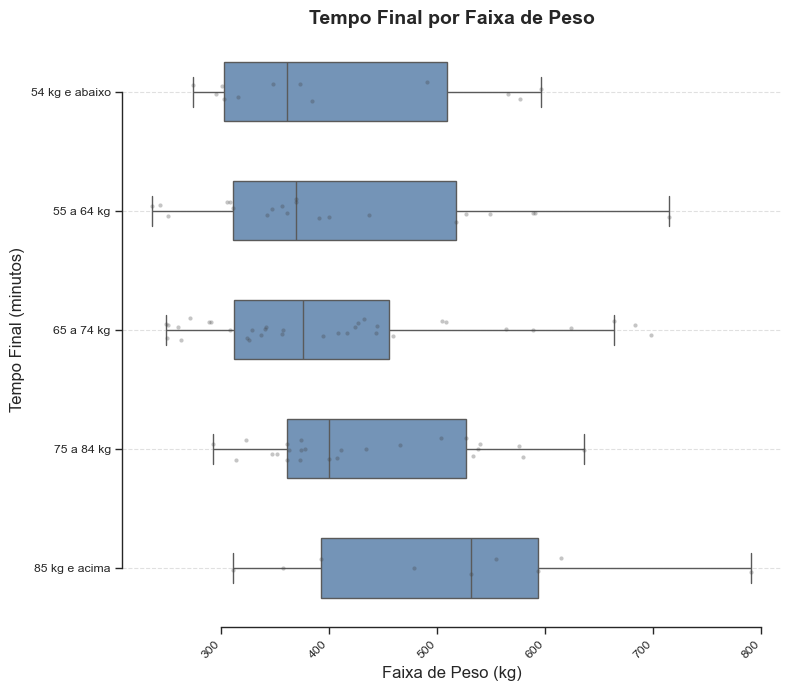

In [158]:
# 1. Definir o tema visual
sns.set_theme(style="ticks", context="paper")

# 2. Criar a figura e os eixos
# Ajustamos o figsize para um layout mais vertical
fig, ax = plt.subplots(figsize=(8, 7))


# 3. Definir a ordem das categorias
peso_order = sorted([x for x in df_peso["peso_agrupada"].unique() if x is not None])

# 4. Plotar o boxplot
sns.boxplot(
    data=df_peso,
    y="peso_agrupada",
    x="Tempo_Final_min",
    order=peso_order,
    color="#6994c2",
    width=0.5,
    fliersize=0,  # Removemos outliers para n√£o sobrepor com o stripplot
    ax=ax,
)

# 5. Sobrepor os pontos individuais
sns.stripplot(
    data=df_peso,
    y="peso_agrupada",
    x="Tempo_Final_min",
    order=peso_order,
    color=".25",
    size=3,
    alpha=0.3,
    ax=ax,
)

# 6. Configurar t√≠tulos e r√≥tulos
ax.set_title("Tempo Final por Faixa de Peso", fontsize=14, fontweight="bold")
ax.set_xlabel("Faixa de Peso (kg)", fontsize=12)
ax.set_ylabel("Tempo Final (minutos)", fontsize=12)
# Ajustamos a rota√ß√£o dos r√≥tulos para melhor alinhamento
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.6)

# 7. Limpar o visual do gr√°fico
sns.despine(ax=ax, trim=True)

# 8. Ajustar layout e salvar em alta resolu√ß√£o

plt.tight_layout()
plt.savefig(r"Escrita\Projeto_TCC_FINAL\Imagens\boxplot_tempo_por_peso.png", dpi=300)
plt.show()

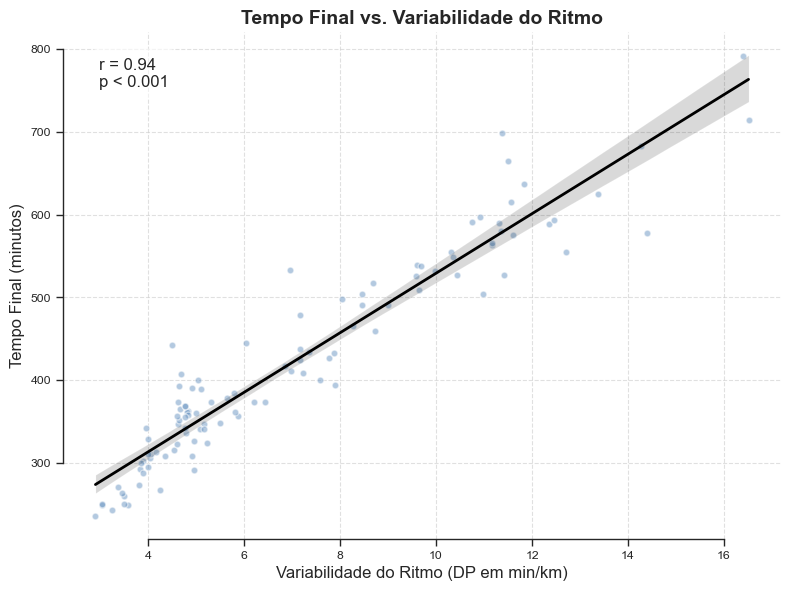

In [155]:
# Extraindo as duas vari√°veis para o teste
tempo_final = df_agregado_por_atleta["Tempo_Final_min"]
variabilidade_ritmo = df_agregado_por_atleta["Variabilidade_Ritmo_min_std"]

# Calculando a Correla√ß√£o de Spearman
coeficiente_rho, p_valor = stats.spearmanr(tempo_final, variabilidade_ritmo)

# Formata o texto que ser√° exibido no gr√°fico
p_text = f"p < 0.001" if p_valor < 0.001 else f"p = {p_valor:.3f}"
annotation_text = f"r = {coeficiente_rho:.2f}\n{p_text}"


# 2. Definir o tema visual
sns.set_theme(style="ticks", context="paper")

# 3. Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(8, 6))

# 4. Plotar o gr√°fico de regress√£o com estilo aprimorado
sns.regplot(
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    data=df_agregado_por_atleta,
    scatter_kws={"alpha": 0.5, "color": "#6994c2", "edgecolor": "white"},
    line_kws={"color": "black", "linewidth": 2},
    ax=ax,
)

# 5. Adicionar a anota√ß√£o com os resultados estat√≠sticos
# Os valores 0.05 e 0.95 representam a posi√ß√£o em porcentagem dos eixos
ax.text(
    0.05,
    0.95,
    annotation_text,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.5),
)

# 6. Configurar t√≠tulos e r√≥tulos
ax.set_title("Tempo Final vs. Variabilidade do Ritmo", fontsize=14, fontweight="bold")
ax.set_xlabel("Variabilidade do Ritmo (DP em min/km)", fontsize=12)
ax.set_ylabel("Tempo Final (minutos)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# 7. Limpar o visual do gr√°fico
sns.despine(ax=ax, trim=True)

# 8. Ajustar layout e salvar em alta resolu√ß√£o
plt.tight_layout()
plt.savefig(
    r"Escrita\Projeto_TCC_FINAL\Imagens\scatterplot_correlacao_ritmo.png", dpi=300
)
plt.show()

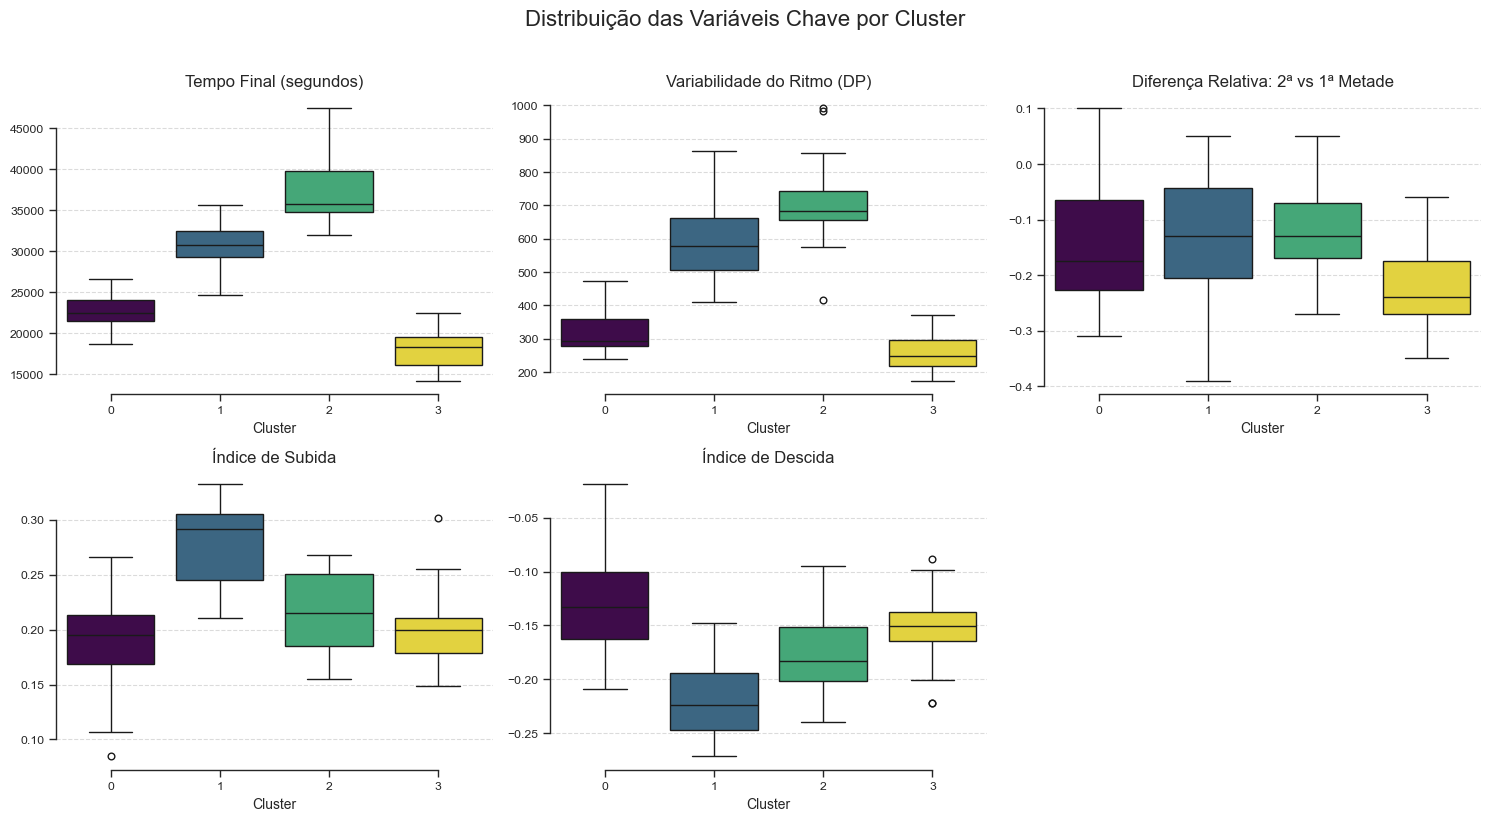

In [156]:
import math

features_usadas = [
    "Tempo_Final_seg",
    "Variabilidade_Ritmo_std",
    "diff_relativa_segunda_primeira_parte",
    "indice_subida",
    "indice_descida",
]

titulos_features = {
    "Tempo_Final_seg": "Tempo Final (segundos)",
    "Variabilidade_Ritmo_std": "Variabilidade do Ritmo (DP)",
    "diff_relativa_segunda_primeira_parte": "Diferen√ßa Relativa: 2¬™ vs 1¬™ Metade",
    "indice_subida": "√çndice de Subida",
    "indice_descida": "√çndice de Descida",
}

# 2. Calcular dinamicamente o n√∫mero de linhas e colunas para os subplots
n_features = len(features_usadas)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)  # Arredonda para cima

# 3. Definir o tema e criar a figura
sns.set_theme(style="ticks", context="paper")
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
fig.suptitle("Distribui√ß√£o das Vari√°veis Chave por Cluster", fontsize=16, y=1.02)
axes = axes.flatten()  # Transforma a matriz de eixos em uma lista

# 4. Loop para criar cada boxplot
for i, feature in enumerate(features_usadas):
    ax = axes[i]
    sns.boxplot(
        data=df_cluster2_com_labels,
        x="cluster",
        y=feature,
        hue="cluster",  # Recomendado pela nova sintaxe do Seaborn
        palette="viridis",
        legend=False,  # Legenda √© redundante aqui
        ax=ax,
    )
    ax.set_title(
        titulos_features.get(feature, feature), fontsize=12
    )  # Usa o t√≠tulo do dicion√°rio
    ax.set_xlabel("Cluster", fontsize=10)
    ax.set_ylabel("")  # O t√≠tulo j√° informa a vari√°vel
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    sns.despine(ax=ax, trim=True)

# 5. Esconder os eixos que n√£o foram usados
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

# 6. Ajustar o layout e salvar
plt.tight_layout()
plt.savefig(r"Escrita\Projeto_TCC_FINAL\Imagens\boxplot_clusters_features.png", dpi=300)
plt.show()

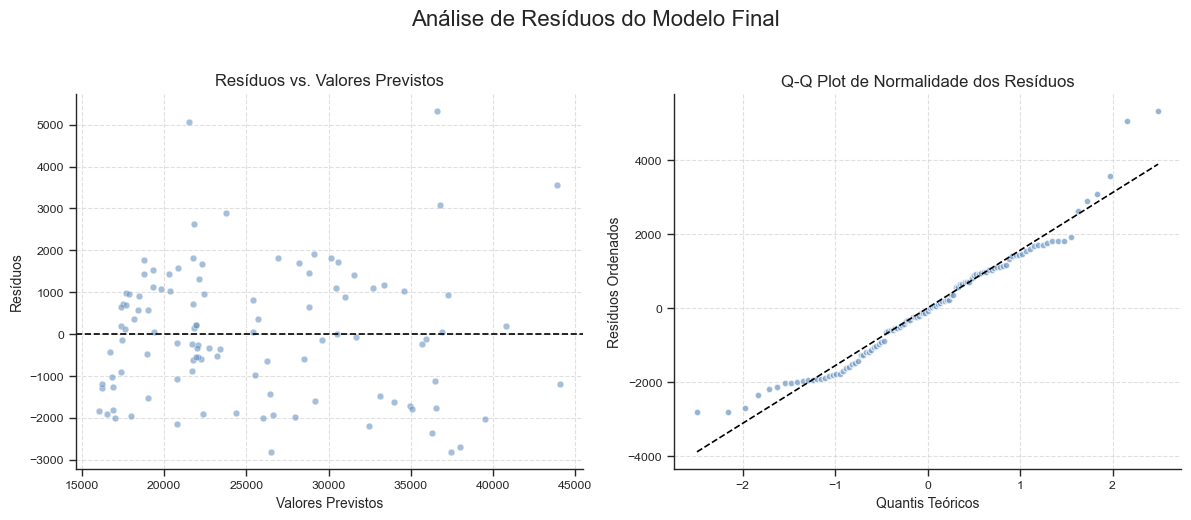

In [157]:
# 1. Definir o tema e criar a figura com 2 subplots (1 linha, 2 colunas)
sns.set_theme(style="ticks", context="paper")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("An√°lise de Res√≠duos do Modelo Final", fontsize=16, y=1.03)


# --- Gr√°fico (a): Res√≠duos vs. Valores Previstos ---
ax1 = axes[0]
sns.scatterplot(
    x=valores_previstos_finais,
    y=residuos_finais,
    alpha=0.6,
    color="#6994c2",
    edgecolor="white",
    ax=ax1,
)
ax1.axhline(0, color="black", linestyle="--")
ax1.set_title("Res√≠duos vs. Valores Previstos", fontsize=12)
ax1.set_xlabel("Valores Previstos", fontsize=10)
ax1.set_ylabel("Res√≠duos", fontsize=10)
ax1.grid(linestyle="--", alpha=0.6)
sns.despine(ax=ax1)


# --- Gr√°fico (b): Q-Q Plot de Normalidade ---
ax2 = axes[1]
stats.probplot(residuos_finais, dist="norm", plot=ax2)

# Customizando a apar√™ncia do Q-Q Plot para o padr√£o TCC
line0 = ax2.get_lines()[0]  # Pontos
line1 = ax2.get_lines()[1]  # Linha de refer√™ncia
line0.set_markerfacecolor("#6994c2")
line0.set_markeredgecolor("white")
line0.set_alpha(0.7)
line1.set_color("black")
line1.set_linestyle("--")

ax2.set_title("Q-Q Plot de Normalidade dos Res√≠duos", fontsize=12)
ax2.set_xlabel("Quantis Te√≥ricos", fontsize=10)
ax2.set_ylabel("Res√≠duos Ordenados", fontsize=10)
ax2.grid(linestyle="--", alpha=0.6)
sns.despine(ax=ax2)


# 3. Ajustar layout e salvar
plt.tight_layout()
plt.savefig(r"Escrita\Projeto_TCC_FINAL\Imagens\analise_residuos_modelo.png", dpi=300)
plt.show()